In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(8749832, 828)
(8749832, 8)
validation
(1260688, 828)
(1260688, 8)
test
(987784, 828)
(987784, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/875 [..............................] - ETA: 18:29 - loss: 2.2672 - STD: 0.0666 - MAE: 0.2205

  5/875 [..............................] - ETA: 13s - loss: 2.1173 - STD: 0.0485 - MAE: 0.2172  

  9/875 [..............................] - ETA: 13s - loss: 2.0995 - STD: 0.0525 - MAE: 0.2163

 13/875 [..............................] - ETA: 13s - loss: 2.0862 - STD: 0.0452 - MAE: 0.2166

 17/875 [..............................] - ETA: 13s - loss: 2.0788 - STD: 0.0412 - MAE: 0.2167

 21/875 [..............................] - ETA: 13s - loss: 2.0719 - STD: 0.0394 - MAE: 0.2166

 25/875 [..............................] - ETA: 13s - loss: 2.0644 - STD: 0.0384 - MAE: 0.2165

 29/875 [..............................] - ETA: 13s - loss: 2.0559 - STD: 0.0385 - MAE: 0.2162

 33/875 [>.............................] - ETA: 13s - loss: 2.0445 - STD: 0.0392 - MAE: 0.2158

 37/875 [>.............................] - ETA: 13s - loss: 2.0305 - STD: 0.0408 - MAE: 0.2153

 41/875 [>.............................] - ETA: 13s - loss: 2.0164 - STD: 0.0431 - MAE: 0.2146

 45/875 [>.............................] - ETA: 13s - loss: 2.0020 - STD: 0.0460 - MAE: 0.2139

 49/875 [>.............................] - ETA: 12s - loss: 1.9878 - STD: 0.0488 - MAE: 0.2131

 53/875 [>.............................] - ETA: 12s - loss: 1.9734 - STD: 0.0511 - MAE: 0.2124

 57/875 [>.............................] - ETA: 12s - loss: 1.9585 - STD: 0.0533 - MAE: 0.2117

 61/875 [=>............................] - ETA: 12s - loss: 1.9436 - STD: 0.0555 - MAE: 0.2110

 65/875 [=>............................] - ETA: 12s - loss: 1.9277 - STD: 0.0577 - MAE: 0.2102

 69/875 [=>............................] - ETA: 12s - loss: 1.9112 - STD: 0.0600 - MAE: 0.2093

 73/875 [=>............................] - ETA: 12s - loss: 1.8942 - STD: 0.0626 - MAE: 0.2083

 77/875 [=>............................] - ETA: 12s - loss: 1.8777 - STD: 0.0653 - MAE: 0.2073

 81/875 [=>............................] - ETA: 12s - loss: 1.8620 - STD: 0.0682 - MAE: 0.2062

 85/875 [=>............................] - ETA: 12s - loss: 1.8468 - STD: 0.0709 - MAE: 0.2052

 89/875 [==>...........................] - ETA: 12s - loss: 1.8327 - STD: 0.0735 - MAE: 0.2042

 93/875 [==>...........................] - ETA: 12s - loss: 1.8191 - STD: 0.0759 - MAE: 0.2032

 97/875 [==>...........................] - ETA: 12s - loss: 1.8061 - STD: 0.0782 - MAE: 0.2023

101/875 [==>...........................] - ETA: 11s - loss: 1.7935 - STD: 0.0805 - MAE: 0.2014

105/875 [==>...........................] - ETA: 11s - loss: 1.7814 - STD: 0.0826 - MAE: 0.2006

109/875 [==>...........................] - ETA: 11s - loss: 1.7696 - STD: 0.0846 - MAE: 0.1997

113/875 [==>...........................] - ETA: 11s - loss: 1.7586 - STD: 0.0866 - MAE: 0.1989

117/875 [===>..........................] - ETA: 11s - loss: 1.7480 - STD: 0.0885 - MAE: 0.1982

121/875 [===>..........................] - ETA: 11s - loss: 1.7373 - STD: 0.0903 - MAE: 0.1974

125/875 [===>..........................] - ETA: 11s - loss: 1.7279 - STD: 0.0921 - MAE: 0.1966

129/875 [===>..........................] - ETA: 11s - loss: 1.7185 - STD: 0.0938 - MAE: 0.1959

133/875 [===>..........................] - ETA: 11s - loss: 1.7096 - STD: 0.0955 - MAE: 0.1952

137/875 [===>..........................] - ETA: 11s - loss: 1.7009 - STD: 0.0970 - MAE: 0.1946

141/875 [===>..........................] - ETA: 11s - loss: 1.6926 - STD: 0.0985 - MAE: 0.1939

145/875 [===>..........................] - ETA: 11s - loss: 1.6847 - STD: 0.0999 - MAE: 0.1933

149/875 [====>.........................] - ETA: 11s - loss: 1.6770 - STD: 0.1013 - MAE: 0.1927

153/875 [====>.........................] - ETA: 11s - loss: 1.6697 - STD: 0.1026 - MAE: 0.1921

157/875 [====>.........................] - ETA: 11s - loss: 1.6626 - STD: 0.1039 - MAE: 0.1916

161/875 [====>.........................] - ETA: 10s - loss: 1.6558 - STD: 0.1051 - MAE: 0.1911

165/875 [====>.........................] - ETA: 10s - loss: 1.6493 - STD: 0.1063 - MAE: 0.1905

169/875 [====>.........................] - ETA: 10s - loss: 1.6429 - STD: 0.1074 - MAE: 0.1900

173/875 [====>.........................] - ETA: 10s - loss: 1.6368 - STD: 0.1085 - MAE: 0.1895

177/875 [=====>........................] - ETA: 10s - loss: 1.6307 - STD: 0.1096 - MAE: 0.1891

181/875 [=====>........................] - ETA: 10s - loss: 1.6249 - STD: 0.1106 - MAE: 0.1886

185/875 [=====>........................] - ETA: 10s - loss: 1.6193 - STD: 0.1116 - MAE: 0.1881

189/875 [=====>........................] - ETA: 10s - loss: 1.6138 - STD: 0.1126 - MAE: 0.1877

193/875 [=====>........................] - ETA: 10s - loss: 1.6087 - STD: 0.1135 - MAE: 0.1873

197/875 [=====>........................] - ETA: 10s - loss: 1.6035 - STD: 0.1144 - MAE: 0.1869

201/875 [=====>........................] - ETA: 10s - loss: 1.5988 - STD: 0.1153 - MAE: 0.1865

205/875 [======>.......................] - ETA: 10s - loss: 1.5941 - STD: 0.1162 - MAE: 0.1861

209/875 [======>.......................] - ETA: 10s - loss: 1.5894 - STD: 0.1171 - MAE: 0.1857

213/875 [======>.......................] - ETA: 10s - loss: 1.5849 - STD: 0.1178 - MAE: 0.1853

217/875 [======>.......................] - ETA: 10s - loss: 1.5806 - STD: 0.1186 - MAE: 0.1850

221/875 [======>.......................] - ETA: 10s - loss: 1.5763 - STD: 0.1194 - MAE: 0.1846

225/875 [======>.......................] - ETA: 9s - loss: 1.5722 - STD: 0.1201 - MAE: 0.1843 

229/875 [======>.......................] - ETA: 9s - loss: 1.5682 - STD: 0.1209 - MAE: 0.1840

233/875 [======>.......................] - ETA: 9s - loss: 1.5645 - STD: 0.1215 - MAE: 0.1837

237/875 [=======>......................] - ETA: 9s - loss: 1.5608 - STD: 0.1222 - MAE: 0.1834

241/875 [=======>......................] - ETA: 9s - loss: 1.5570 - STD: 0.1229 - MAE: 0.1830

245/875 [=======>......................] - ETA: 9s - loss: 1.5533 - STD: 0.1235 - MAE: 0.1827

249/875 [=======>......................] - ETA: 9s - loss: 1.5498 - STD: 0.1242 - MAE: 0.1825

253/875 [=======>......................] - ETA: 9s - loss: 1.5462 - STD: 0.1248 - MAE: 0.1822

257/875 [=======>......................] - ETA: 9s - loss: 1.5428 - STD: 0.1254 - MAE: 0.1819

261/875 [=======>......................] - ETA: 9s - loss: 1.5395 - STD: 0.1260 - MAE: 0.1816

265/875 [========>.....................] - ETA: 9s - loss: 1.5361 - STD: 0.1266 - MAE: 0.1813

269/875 [========>.....................] - ETA: 9s - loss: 1.5328 - STD: 0.1271 - MAE: 0.1810

273/875 [========>.....................] - ETA: 9s - loss: 1.5295 - STD: 0.1277 - MAE: 0.1808

277/875 [========>.....................] - ETA: 9s - loss: 1.5263 - STD: 0.1283 - MAE: 0.1805

281/875 [========>.....................] - ETA: 9s - loss: 1.5233 - STD: 0.1288 - MAE: 0.1803

285/875 [========>.....................] - ETA: 9s - loss: 1.5203 - STD: 0.1293 - MAE: 0.1800

289/875 [========>.....................] - ETA: 9s - loss: 1.5174 - STD: 0.1298 - MAE: 0.1798

293/875 [=========>....................] - ETA: 8s - loss: 1.5146 - STD: 0.1303 - MAE: 0.1795

297/875 [=========>....................] - ETA: 8s - loss: 1.5118 - STD: 0.1308 - MAE: 0.1793

301/875 [=========>....................] - ETA: 8s - loss: 1.5090 - STD: 0.1313 - MAE: 0.1790

305/875 [=========>....................] - ETA: 8s - loss: 1.5063 - STD: 0.1318 - MAE: 0.1788

309/875 [=========>....................] - ETA: 8s - loss: 1.5036 - STD: 0.1322 - MAE: 0.1786

313/875 [=========>....................] - ETA: 8s - loss: 1.5009 - STD: 0.1327 - MAE: 0.1784

317/875 [=========>....................] - ETA: 8s - loss: 1.4983 - STD: 0.1331 - MAE: 0.1781

321/875 [==========>...................] - ETA: 8s - loss: 1.4957 - STD: 0.1336 - MAE: 0.1779

325/875 [==========>...................] - ETA: 8s - loss: 1.4931 - STD: 0.1340 - MAE: 0.1777

329/875 [==========>...................] - ETA: 8s - loss: 1.4906 - STD: 0.1344 - MAE: 0.1775

333/875 [==========>...................] - ETA: 8s - loss: 1.4882 - STD: 0.1349 - MAE: 0.1773

337/875 [==========>...................] - ETA: 8s - loss: 1.4859 - STD: 0.1353 - MAE: 0.1771

341/875 [==========>...................] - ETA: 8s - loss: 1.4837 - STD: 0.1357 - MAE: 0.1769

345/875 [==========>...................] - ETA: 8s - loss: 1.4815 - STD: 0.1361 - MAE: 0.1767

349/875 [==========>...................] - ETA: 8s - loss: 1.4794 - STD: 0.1365 - MAE: 0.1765

353/875 [===========>..................] - ETA: 8s - loss: 1.4773 - STD: 0.1368 - MAE: 0.1763

357/875 [===========>..................] - ETA: 7s - loss: 1.4752 - STD: 0.1372 - MAE: 0.1762

361/875 [===========>..................] - ETA: 7s - loss: 1.4730 - STD: 0.1376 - MAE: 0.1760

365/875 [===========>..................] - ETA: 7s - loss: 1.4709 - STD: 0.1379 - MAE: 0.1758

369/875 [===========>..................] - ETA: 7s - loss: 1.4686 - STD: 0.1383 - MAE: 0.1756

373/875 [===========>..................] - ETA: 7s - loss: 1.4665 - STD: 0.1386 - MAE: 0.1754

377/875 [===========>..................] - ETA: 7s - loss: 1.4644 - STD: 0.1390 - MAE: 0.1752

381/875 [============>.................] - ETA: 7s - loss: 1.4623 - STD: 0.1393 - MAE: 0.1751

385/875 [============>.................] - ETA: 7s - loss: 1.4602 - STD: 0.1397 - MAE: 0.1749

389/875 [============>.................] - ETA: 7s - loss: 1.4583 - STD: 0.1400 - MAE: 0.1747

393/875 [============>.................] - ETA: 7s - loss: 1.4563 - STD: 0.1403 - MAE: 0.1746

397/875 [============>.................] - ETA: 7s - loss: 1.4543 - STD: 0.1407 - MAE: 0.1744

401/875 [============>.................] - ETA: 7s - loss: 1.4524 - STD: 0.1410 - MAE: 0.1742

405/875 [============>.................] - ETA: 7s - loss: 1.4505 - STD: 0.1413 - MAE: 0.1741

409/875 [=============>................] - ETA: 7s - loss: 1.4485 - STD: 0.1416 - MAE: 0.1739

413/875 [=============>................] - ETA: 7s - loss: 1.4467 - STD: 0.1419 - MAE: 0.1737

417/875 [=============>................] - ETA: 7s - loss: 1.4449 - STD: 0.1422 - MAE: 0.1736

421/875 [=============>................] - ETA: 6s - loss: 1.4432 - STD: 0.1425 - MAE: 0.1734

425/875 [=============>................] - ETA: 6s - loss: 1.4413 - STD: 0.1428 - MAE: 0.1733

429/875 [=============>................] - ETA: 6s - loss: 1.4395 - STD: 0.1431 - MAE: 0.1731

433/875 [=============>................] - ETA: 6s - loss: 1.4377 - STD: 0.1434 - MAE: 0.1730

437/875 [=============>................] - ETA: 6s - loss: 1.4360 - STD: 0.1437 - MAE: 0.1728

441/875 [==============>...............] - ETA: 6s - loss: 1.4343 - STD: 0.1440 - MAE: 0.1727

445/875 [==============>...............] - ETA: 6s - loss: 1.4326 - STD: 0.1443 - MAE: 0.1725

449/875 [==============>...............] - ETA: 6s - loss: 1.4310 - STD: 0.1445 - MAE: 0.1724

453/875 [==============>...............] - ETA: 6s - loss: 1.4294 - STD: 0.1448 - MAE: 0.1722

457/875 [==============>...............] - ETA: 6s - loss: 1.4278 - STD: 0.1451 - MAE: 0.1721

461/875 [==============>...............] - ETA: 6s - loss: 1.4261 - STD: 0.1453 - MAE: 0.1719

465/875 [==============>...............] - ETA: 6s - loss: 1.4244 - STD: 0.1456 - MAE: 0.1718

469/875 [===============>..............] - ETA: 6s - loss: 1.4228 - STD: 0.1459 - MAE: 0.1717

473/875 [===============>..............] - ETA: 6s - loss: 1.4211 - STD: 0.1461 - MAE: 0.1715

477/875 [===============>..............] - ETA: 6s - loss: 1.4195 - STD: 0.1464 - MAE: 0.1714

481/875 [===============>..............] - ETA: 6s - loss: 1.4180 - STD: 0.1466 - MAE: 0.1713

485/875 [===============>..............] - ETA: 5s - loss: 1.4165 - STD: 0.1469 - MAE: 0.1711

489/875 [===============>..............] - ETA: 5s - loss: 1.4150 - STD: 0.1471 - MAE: 0.1710

493/875 [===============>..............] - ETA: 5s - loss: 1.4135 - STD: 0.1474 - MAE: 0.1709

497/875 [================>.............] - ETA: 5s - loss: 1.4120 - STD: 0.1476 - MAE: 0.1707

501/875 [================>.............] - ETA: 5s - loss: 1.4105 - STD: 0.1479 - MAE: 0.1706

505/875 [================>.............] - ETA: 5s - loss: 1.4090 - STD: 0.1481 - MAE: 0.1705

509/875 [================>.............] - ETA: 5s - loss: 1.4076 - STD: 0.1483 - MAE: 0.1703

513/875 [================>.............] - ETA: 5s - loss: 1.4063 - STD: 0.1486 - MAE: 0.1702

517/875 [================>.............] - ETA: 5s - loss: 1.4050 - STD: 0.1488 - MAE: 0.1701

521/875 [================>.............] - ETA: 5s - loss: 1.4038 - STD: 0.1490 - MAE: 0.1700

525/875 [=================>............] - ETA: 5s - loss: 1.4024 - STD: 0.1493 - MAE: 0.1699

529/875 [=================>............] - ETA: 5s - loss: 1.4012 - STD: 0.1495 - MAE: 0.1697

533/875 [=================>............] - ETA: 5s - loss: 1.3999 - STD: 0.1497 - MAE: 0.1696

537/875 [=================>............] - ETA: 5s - loss: 1.3985 - STD: 0.1499 - MAE: 0.1695

541/875 [=================>............] - ETA: 5s - loss: 1.3972 - STD: 0.1501 - MAE: 0.1694

545/875 [=================>............] - ETA: 5s - loss: 1.3958 - STD: 0.1503 - MAE: 0.1693

549/875 [=================>............] - ETA: 4s - loss: 1.3946 - STD: 0.1505 - MAE: 0.1692

553/875 [=================>............] - ETA: 4s - loss: 1.3933 - STD: 0.1507 - MAE: 0.1691

557/875 [==================>...........] - ETA: 4s - loss: 1.3920 - STD: 0.1509 - MAE: 0.1689

561/875 [==================>...........] - ETA: 4s - loss: 1.3908 - STD: 0.1511 - MAE: 0.1688

565/875 [==================>...........] - ETA: 4s - loss: 1.3896 - STD: 0.1513 - MAE: 0.1687

569/875 [==================>...........] - ETA: 4s - loss: 1.3884 - STD: 0.1515 - MAE: 0.1686

573/875 [==================>...........] - ETA: 4s - loss: 1.3871 - STD: 0.1517 - MAE: 0.1685

577/875 [==================>...........] - ETA: 4s - loss: 1.3859 - STD: 0.1519 - MAE: 0.1684

581/875 [==================>...........] - ETA: 4s - loss: 1.3847 - STD: 0.1521 - MAE: 0.1683

585/875 [===================>..........] - ETA: 4s - loss: 1.3835 - STD: 0.1523 - MAE: 0.1682

589/875 [===================>..........] - ETA: 4s - loss: 1.3822 - STD: 0.1525 - MAE: 0.1681

593/875 [===================>..........] - ETA: 4s - loss: 1.3811 - STD: 0.1527 - MAE: 0.1680

597/875 [===================>..........] - ETA: 4s - loss: 1.3799 - STD: 0.1529 - MAE: 0.1679

601/875 [===================>..........] - ETA: 4s - loss: 1.3786 - STD: 0.1531 - MAE: 0.1678

605/875 [===================>..........] - ETA: 4s - loss: 1.3774 - STD: 0.1532 - MAE: 0.1676

609/875 [===================>..........] - ETA: 4s - loss: 1.3762 - STD: 0.1534 - MAE: 0.1675

613/875 [====================>.........] - ETA: 4s - loss: 1.3751 - STD: 0.1536 - MAE: 0.1674

617/875 [====================>.........] - ETA: 3s - loss: 1.3739 - STD: 0.1538 - MAE: 0.1673

621/875 [====================>.........] - ETA: 3s - loss: 1.3729 - STD: 0.1540 - MAE: 0.1672

625/875 [====================>.........] - ETA: 3s - loss: 1.3718 - STD: 0.1542 - MAE: 0.1671

629/875 [====================>.........] - ETA: 3s - loss: 1.3706 - STD: 0.1543 - MAE: 0.1670

633/875 [====================>.........] - ETA: 3s - loss: 1.3695 - STD: 0.1545 - MAE: 0.1669

637/875 [====================>.........] - ETA: 3s - loss: 1.3684 - STD: 0.1547 - MAE: 0.1668

641/875 [====================>.........] - ETA: 3s - loss: 1.3673 - STD: 0.1549 - MAE: 0.1667

645/875 [=====================>........] - ETA: 3s - loss: 1.3661 - STD: 0.1550 - MAE: 0.1666

649/875 [=====================>........] - ETA: 3s - loss: 1.3650 - STD: 0.1552 - MAE: 0.1665

653/875 [=====================>........] - ETA: 3s - loss: 1.3639 - STD: 0.1554 - MAE: 0.1664

657/875 [=====================>........] - ETA: 3s - loss: 1.3629 - STD: 0.1555 - MAE: 0.1663

661/875 [=====================>........] - ETA: 3s - loss: 1.3619 - STD: 0.1557 - MAE: 0.1663

665/875 [=====================>........] - ETA: 3s - loss: 1.3608 - STD: 0.1559 - MAE: 0.1662

669/875 [=====================>........] - ETA: 3s - loss: 1.3597 - STD: 0.1560 - MAE: 0.1661

673/875 [======================>.......] - ETA: 3s - loss: 1.3587 - STD: 0.1562 - MAE: 0.1660

677/875 [======================>.......] - ETA: 3s - loss: 1.3577 - STD: 0.1564 - MAE: 0.1659

681/875 [======================>.......] - ETA: 3s - loss: 1.3567 - STD: 0.1565 - MAE: 0.1658

685/875 [======================>.......] - ETA: 3s - loss: 1.3557 - STD: 0.1567 - MAE: 0.1657

689/875 [======================>.......] - ETA: 3s - loss: 1.3547 - STD: 0.1569 - MAE: 0.1656

693/875 [======================>.......] - ETA: 2s - loss: 1.3537 - STD: 0.1570 - MAE: 0.1655

697/875 [======================>.......] - ETA: 2s - loss: 1.3528 - STD: 0.1572 - MAE: 0.1654

701/875 [=======================>......] - ETA: 2s - loss: 1.3518 - STD: 0.1573 - MAE: 0.1653

705/875 [=======================>......] - ETA: 2s - loss: 1.3508 - STD: 0.1575 - MAE: 0.1652

709/875 [=======================>......] - ETA: 2s - loss: 1.3499 - STD: 0.1576 - MAE: 0.1652

713/875 [=======================>......] - ETA: 2s - loss: 1.3489 - STD: 0.1578 - MAE: 0.1651

717/875 [=======================>......] - ETA: 2s - loss: 1.3480 - STD: 0.1579 - MAE: 0.1650

721/875 [=======================>......] - ETA: 2s - loss: 1.3471 - STD: 0.1581 - MAE: 0.1649

725/875 [=======================>......] - ETA: 2s - loss: 1.3463 - STD: 0.1582 - MAE: 0.1648

729/875 [=======================>......] - ETA: 2s - loss: 1.3454 - STD: 0.1584 - MAE: 0.1647

733/875 [========================>.....] - ETA: 2s - loss: 1.3445 - STD: 0.1585 - MAE: 0.1647

737/875 [========================>.....] - ETA: 2s - loss: 1.3436 - STD: 0.1587 - MAE: 0.1646

741/875 [========================>.....] - ETA: 2s - loss: 1.3427 - STD: 0.1588 - MAE: 0.1645

745/875 [========================>.....] - ETA: 2s - loss: 1.3417 - STD: 0.1590 - MAE: 0.1644

749/875 [========================>.....] - ETA: 2s - loss: 1.3408 - STD: 0.1591 - MAE: 0.1643

753/875 [========================>.....] - ETA: 1s - loss: 1.3399 - STD: 0.1592 - MAE: 0.1642

757/875 [========================>.....] - ETA: 1s - loss: 1.3389 - STD: 0.1594 - MAE: 0.1642

761/875 [=========================>....] - ETA: 1s - loss: 1.3380 - STD: 0.1595 - MAE: 0.1641

765/875 [=========================>....] - ETA: 1s - loss: 1.3371 - STD: 0.1597 - MAE: 0.1640

769/875 [=========================>....] - ETA: 1s - loss: 1.3363 - STD: 0.1598 - MAE: 0.1639

773/875 [=========================>....] - ETA: 1s - loss: 1.3354 - STD: 0.1599 - MAE: 0.1638

777/875 [=========================>....] - ETA: 1s - loss: 1.3344 - STD: 0.1601 - MAE: 0.1637

781/875 [=========================>....] - ETA: 1s - loss: 1.3336 - STD: 0.1602 - MAE: 0.1637

785/875 [=========================>....] - ETA: 1s - loss: 1.3327 - STD: 0.1603 - MAE: 0.1636

789/875 [==========================>...] - ETA: 1s - loss: 1.3319 - STD: 0.1605 - MAE: 0.1635

793/875 [==========================>...] - ETA: 1s - loss: 1.3312 - STD: 0.1606 - MAE: 0.1634

797/875 [==========================>...] - ETA: 1s - loss: 1.3305 - STD: 0.1608 - MAE: 0.1634

801/875 [==========================>...] - ETA: 1s - loss: 1.3297 - STD: 0.1609 - MAE: 0.1633

805/875 [==========================>...] - ETA: 1s - loss: 1.3289 - STD: 0.1610 - MAE: 0.1632

809/875 [==========================>...] - ETA: 1s - loss: 1.3281 - STD: 0.1611 - MAE: 0.1631

813/875 [==========================>...] - ETA: 1s - loss: 1.3273 - STD: 0.1613 - MAE: 0.1631

817/875 [===========================>..] - ETA: 0s - loss: 1.3264 - STD: 0.1614 - MAE: 0.1630

821/875 [===========================>..] - ETA: 0s - loss: 1.3255 - STD: 0.1615 - MAE: 0.1629

825/875 [===========================>..] - ETA: 0s - loss: 1.3246 - STD: 0.1617 - MAE: 0.1628

829/875 [===========================>..] - ETA: 0s - loss: 1.3238 - STD: 0.1618 - MAE: 0.1628

833/875 [===========================>..] - ETA: 0s - loss: 1.3230 - STD: 0.1619 - MAE: 0.1627

837/875 [===========================>..] - ETA: 0s - loss: 1.3222 - STD: 0.1620 - MAE: 0.1626

841/875 [===========================>..] - ETA: 0s - loss: 1.3213 - STD: 0.1622 - MAE: 0.1625

845/875 [===========================>..] - ETA: 0s - loss: 1.3206 - STD: 0.1623 - MAE: 0.1624

849/875 [============================>.] - ETA: 0s - loss: 1.3197 - STD: 0.1624 - MAE: 0.1624

853/875 [============================>.] - ETA: 0s - loss: 1.3189 - STD: 0.1625 - MAE: 0.1623

857/875 [============================>.] - ETA: 0s - loss: 1.3181 - STD: 0.1627 - MAE: 0.1622

861/875 [============================>.] - ETA: 0s - loss: 1.3174 - STD: 0.1628 - MAE: 0.1621

865/875 [============================>.] - ETA: 0s - loss: 1.3166 - STD: 0.1629 - MAE: 0.1621

869/875 [============================>.] - ETA: 0s - loss: 1.3158 - STD: 0.1630 - MAE: 0.1620

873/875 [============================>.] - ETA: 0s - loss: 1.3151 - STD: 0.1631 - MAE: 0.1619

875/875 [==============================] - 17s 18ms/step - loss: 1.3147 - STD: 0.1632 - MAE: 0.1619 - val_loss: 1.2721 - val_STD: 0.1835 - val_MAE: 0.1537


Epoch 2/10000


  1/875 [..............................] - ETA: 39s - loss: 1.1419 - STD: 0.1895 - MAE: 0.1457

  5/875 [..............................] - ETA: 12s - loss: 1.1431 - STD: 0.1894 - MAE: 0.1459

  9/875 [..............................] - ETA: 13s - loss: 1.1393 - STD: 0.1895 - MAE: 0.1457

 13/875 [..............................] - ETA: 13s - loss: 1.1379 - STD: 0.1894 - MAE: 0.1457

 17/875 [..............................] - ETA: 13s - loss: 1.1381 - STD: 0.1894 - MAE: 0.1457

 21/875 [..............................] - ETA: 13s - loss: 1.1397 - STD: 0.1896 - MAE: 0.1457

 25/875 [..............................] - ETA: 13s - loss: 1.1422 - STD: 0.1897 - MAE: 0.1458

 28/875 [..............................] - ETA: 13s - loss: 1.1431 - STD: 0.1898 - MAE: 0.1458

 32/875 [>.............................] - ETA: 13s - loss: 1.1470 - STD: 0.1899 - MAE: 0.1459

 36/875 [>.............................] - ETA: 13s - loss: 1.1478 - STD: 0.1900 - MAE: 0.1460

 40/875 [>.............................] - ETA: 12s - loss: 1.1477 - STD: 0.1900 - MAE: 0.1460

 44/875 [>.............................] - ETA: 12s - loss: 1.1471 - STD: 0.1899 - MAE: 0.1460

 48/875 [>.............................] - ETA: 12s - loss: 1.1465 - STD: 0.1898 - MAE: 0.1460

 52/875 [>.............................] - ETA: 12s - loss: 1.1459 - STD: 0.1898 - MAE: 0.1459

 56/875 [>.............................] - ETA: 12s - loss: 1.1459 - STD: 0.1898 - MAE: 0.1459

 60/875 [=>............................] - ETA: 12s - loss: 1.1460 - STD: 0.1899 - MAE: 0.1459

 64/875 [=>............................] - ETA: 12s - loss: 1.1460 - STD: 0.1900 - MAE: 0.1459

 68/875 [=>............................] - ETA: 12s - loss: 1.1455 - STD: 0.1900 - MAE: 0.1458

 72/875 [=>............................] - ETA: 12s - loss: 1.1449 - STD: 0.1900 - MAE: 0.1458

 76/875 [=>............................] - ETA: 12s - loss: 1.1452 - STD: 0.1901 - MAE: 0.1458

 80/875 [=>............................] - ETA: 12s - loss: 1.1454 - STD: 0.1902 - MAE: 0.1458

 84/875 [=>............................] - ETA: 12s - loss: 1.1464 - STD: 0.1902 - MAE: 0.1458

 88/875 [==>...........................] - ETA: 12s - loss: 1.1473 - STD: 0.1902 - MAE: 0.1459

 92/875 [==>...........................] - ETA: 12s - loss: 1.1476 - STD: 0.1902 - MAE: 0.1459

 96/875 [==>...........................] - ETA: 12s - loss: 1.1476 - STD: 0.1902 - MAE: 0.1459

100/875 [==>...........................] - ETA: 12s - loss: 1.1474 - STD: 0.1902 - MAE: 0.1459

104/875 [==>...........................] - ETA: 12s - loss: 1.1473 - STD: 0.1902 - MAE: 0.1459

108/875 [==>...........................] - ETA: 11s - loss: 1.1466 - STD: 0.1902 - MAE: 0.1458

112/875 [==>...........................] - ETA: 11s - loss: 1.1455 - STD: 0.1902 - MAE: 0.1458

116/875 [==>...........................] - ETA: 11s - loss: 1.1448 - STD: 0.1903 - MAE: 0.1457

120/875 [===>..........................] - ETA: 11s - loss: 1.1440 - STD: 0.1903 - MAE: 0.1456

124/875 [===>..........................] - ETA: 11s - loss: 1.1433 - STD: 0.1904 - MAE: 0.1456

128/875 [===>..........................] - ETA: 11s - loss: 1.1428 - STD: 0.1905 - MAE: 0.1455

132/875 [===>..........................] - ETA: 11s - loss: 1.1423 - STD: 0.1905 - MAE: 0.1455

136/875 [===>..........................] - ETA: 11s - loss: 1.1417 - STD: 0.1906 - MAE: 0.1454

140/875 [===>..........................] - ETA: 11s - loss: 1.1410 - STD: 0.1906 - MAE: 0.1454

144/875 [===>..........................] - ETA: 11s - loss: 1.1406 - STD: 0.1907 - MAE: 0.1454

148/875 [====>.........................] - ETA: 11s - loss: 1.1400 - STD: 0.1907 - MAE: 0.1453

152/875 [====>.........................] - ETA: 11s - loss: 1.1396 - STD: 0.1907 - MAE: 0.1453

156/875 [====>.........................] - ETA: 11s - loss: 1.1391 - STD: 0.1908 - MAE: 0.1452

160/875 [====>.........................] - ETA: 11s - loss: 1.1387 - STD: 0.1908 - MAE: 0.1452

164/875 [====>.........................] - ETA: 11s - loss: 1.1382 - STD: 0.1909 - MAE: 0.1451

168/875 [====>.........................] - ETA: 11s - loss: 1.1378 - STD: 0.1909 - MAE: 0.1451

172/875 [====>.........................] - ETA: 10s - loss: 1.1373 - STD: 0.1910 - MAE: 0.1450

176/875 [=====>........................] - ETA: 10s - loss: 1.1371 - STD: 0.1910 - MAE: 0.1450

180/875 [=====>........................] - ETA: 10s - loss: 1.1366 - STD: 0.1911 - MAE: 0.1450

184/875 [=====>........................] - ETA: 10s - loss: 1.1361 - STD: 0.1912 - MAE: 0.1449

188/875 [=====>........................] - ETA: 10s - loss: 1.1357 - STD: 0.1912 - MAE: 0.1449

192/875 [=====>........................] - ETA: 10s - loss: 1.1357 - STD: 0.1913 - MAE: 0.1449

196/875 [=====>........................] - ETA: 10s - loss: 1.1361 - STD: 0.1913 - MAE: 0.1449

200/875 [=====>........................] - ETA: 10s - loss: 1.1363 - STD: 0.1914 - MAE: 0.1449

204/875 [=====>........................] - ETA: 10s - loss: 1.1363 - STD: 0.1914 - MAE: 0.1448

208/875 [======>.......................] - ETA: 10s - loss: 1.1360 - STD: 0.1914 - MAE: 0.1448

212/875 [======>.......................] - ETA: 10s - loss: 1.1356 - STD: 0.1914 - MAE: 0.1448

216/875 [======>.......................] - ETA: 10s - loss: 1.1352 - STD: 0.1915 - MAE: 0.1448

220/875 [======>.......................] - ETA: 10s - loss: 1.1347 - STD: 0.1915 - MAE: 0.1447

224/875 [======>.......................] - ETA: 10s - loss: 1.1343 - STD: 0.1915 - MAE: 0.1447

228/875 [======>.......................] - ETA: 10s - loss: 1.1339 - STD: 0.1915 - MAE: 0.1447

232/875 [======>.......................] - ETA: 10s - loss: 1.1336 - STD: 0.1916 - MAE: 0.1446

236/875 [=======>......................] - ETA: 9s - loss: 1.1333 - STD: 0.1916 - MAE: 0.1446 

240/875 [=======>......................] - ETA: 9s - loss: 1.1330 - STD: 0.1917 - MAE: 0.1446

244/875 [=======>......................] - ETA: 9s - loss: 1.1326 - STD: 0.1917 - MAE: 0.1446

248/875 [=======>......................] - ETA: 9s - loss: 1.1322 - STD: 0.1917 - MAE: 0.1445

252/875 [=======>......................] - ETA: 9s - loss: 1.1318 - STD: 0.1918 - MAE: 0.1445

256/875 [=======>......................] - ETA: 9s - loss: 1.1317 - STD: 0.1918 - MAE: 0.1444

260/875 [=======>......................] - ETA: 9s - loss: 1.1316 - STD: 0.1918 - MAE: 0.1444

264/875 [========>.....................] - ETA: 9s - loss: 1.1313 - STD: 0.1919 - MAE: 0.1444

268/875 [========>.....................] - ETA: 9s - loss: 1.1308 - STD: 0.1919 - MAE: 0.1444

272/875 [========>.....................] - ETA: 9s - loss: 1.1305 - STD: 0.1920 - MAE: 0.1443

276/875 [========>.....................] - ETA: 9s - loss: 1.1302 - STD: 0.1920 - MAE: 0.1443

280/875 [========>.....................] - ETA: 9s - loss: 1.1298 - STD: 0.1921 - MAE: 0.1442

284/875 [========>.....................] - ETA: 9s - loss: 1.1294 - STD: 0.1921 - MAE: 0.1442

288/875 [========>.....................] - ETA: 9s - loss: 1.1291 - STD: 0.1921 - MAE: 0.1442

292/875 [=========>....................] - ETA: 9s - loss: 1.1287 - STD: 0.1922 - MAE: 0.1442

296/875 [=========>....................] - ETA: 9s - loss: 1.1285 - STD: 0.1922 - MAE: 0.1441

300/875 [=========>....................] - ETA: 8s - loss: 1.1281 - STD: 0.1923 - MAE: 0.1441

304/875 [=========>....................] - ETA: 8s - loss: 1.1277 - STD: 0.1923 - MAE: 0.1441

308/875 [=========>....................] - ETA: 8s - loss: 1.1275 - STD: 0.1923 - MAE: 0.1440

312/875 [=========>....................] - ETA: 8s - loss: 1.1274 - STD: 0.1924 - MAE: 0.1440

316/875 [=========>....................] - ETA: 8s - loss: 1.1273 - STD: 0.1924 - MAE: 0.1440

320/875 [=========>....................] - ETA: 8s - loss: 1.1270 - STD: 0.1925 - MAE: 0.1440

324/875 [==========>...................] - ETA: 8s - loss: 1.1266 - STD: 0.1925 - MAE: 0.1439

328/875 [==========>...................] - ETA: 8s - loss: 1.1262 - STD: 0.1925 - MAE: 0.1439

332/875 [==========>...................] - ETA: 8s - loss: 1.1258 - STD: 0.1926 - MAE: 0.1438

336/875 [==========>...................] - ETA: 8s - loss: 1.1254 - STD: 0.1926 - MAE: 0.1438

340/875 [==========>...................] - ETA: 8s - loss: 1.1250 - STD: 0.1927 - MAE: 0.1438

344/875 [==========>...................] - ETA: 8s - loss: 1.1247 - STD: 0.1927 - MAE: 0.1437

348/875 [==========>...................] - ETA: 8s - loss: 1.1243 - STD: 0.1927 - MAE: 0.1437

352/875 [===========>..................] - ETA: 8s - loss: 1.1240 - STD: 0.1928 - MAE: 0.1437

356/875 [===========>..................] - ETA: 8s - loss: 1.1236 - STD: 0.1928 - MAE: 0.1436

360/875 [===========>..................] - ETA: 8s - loss: 1.1234 - STD: 0.1929 - MAE: 0.1436

364/875 [===========>..................] - ETA: 7s - loss: 1.1231 - STD: 0.1929 - MAE: 0.1436

368/875 [===========>..................] - ETA: 7s - loss: 1.1228 - STD: 0.1929 - MAE: 0.1436

372/875 [===========>..................] - ETA: 7s - loss: 1.1225 - STD: 0.1930 - MAE: 0.1435

376/875 [===========>..................] - ETA: 7s - loss: 1.1222 - STD: 0.1930 - MAE: 0.1435

380/875 [============>.................] - ETA: 7s - loss: 1.1219 - STD: 0.1931 - MAE: 0.1435

384/875 [============>.................] - ETA: 7s - loss: 1.1215 - STD: 0.1931 - MAE: 0.1434

388/875 [============>.................] - ETA: 7s - loss: 1.1211 - STD: 0.1931 - MAE: 0.1434

392/875 [============>.................] - ETA: 7s - loss: 1.1207 - STD: 0.1932 - MAE: 0.1433

396/875 [============>.................] - ETA: 7s - loss: 1.1204 - STD: 0.1932 - MAE: 0.1433

400/875 [============>.................] - ETA: 7s - loss: 1.1201 - STD: 0.1933 - MAE: 0.1433

404/875 [============>.................] - ETA: 7s - loss: 1.1198 - STD: 0.1933 - MAE: 0.1433

408/875 [============>.................] - ETA: 7s - loss: 1.1195 - STD: 0.1933 - MAE: 0.1432

412/875 [=============>................] - ETA: 7s - loss: 1.1192 - STD: 0.1934 - MAE: 0.1432

416/875 [=============>................] - ETA: 7s - loss: 1.1190 - STD: 0.1934 - MAE: 0.1432

420/875 [=============>................] - ETA: 7s - loss: 1.1189 - STD: 0.1934 - MAE: 0.1431

424/875 [=============>................] - ETA: 7s - loss: 1.1185 - STD: 0.1935 - MAE: 0.1431

428/875 [=============>................] - ETA: 6s - loss: 1.1182 - STD: 0.1935 - MAE: 0.1431

432/875 [=============>................] - ETA: 6s - loss: 1.1179 - STD: 0.1935 - MAE: 0.1431

436/875 [=============>................] - ETA: 6s - loss: 1.1176 - STD: 0.1936 - MAE: 0.1430

440/875 [==============>...............] - ETA: 6s - loss: 1.1172 - STD: 0.1936 - MAE: 0.1430

444/875 [==============>...............] - ETA: 6s - loss: 1.1169 - STD: 0.1936 - MAE: 0.1430

448/875 [==============>...............] - ETA: 6s - loss: 1.1167 - STD: 0.1937 - MAE: 0.1429

452/875 [==============>...............] - ETA: 6s - loss: 1.1164 - STD: 0.1937 - MAE: 0.1429

456/875 [==============>...............] - ETA: 6s - loss: 1.1163 - STD: 0.1938 - MAE: 0.1429

460/875 [==============>...............] - ETA: 6s - loss: 1.1162 - STD: 0.1938 - MAE: 0.1429

464/875 [==============>...............] - ETA: 6s - loss: 1.1162 - STD: 0.1938 - MAE: 0.1429

468/875 [===============>..............] - ETA: 6s - loss: 1.1161 - STD: 0.1939 - MAE: 0.1428

472/875 [===============>..............] - ETA: 6s - loss: 1.1161 - STD: 0.1939 - MAE: 0.1428

476/875 [===============>..............] - ETA: 6s - loss: 1.1158 - STD: 0.1939 - MAE: 0.1428

480/875 [===============>..............] - ETA: 6s - loss: 1.1155 - STD: 0.1939 - MAE: 0.1428

484/875 [===============>..............] - ETA: 6s - loss: 1.1152 - STD: 0.1940 - MAE: 0.1428

488/875 [===============>..............] - ETA: 6s - loss: 1.1148 - STD: 0.1940 - MAE: 0.1427

492/875 [===============>..............] - ETA: 5s - loss: 1.1146 - STD: 0.1940 - MAE: 0.1427

496/875 [================>.............] - ETA: 5s - loss: 1.1144 - STD: 0.1940 - MAE: 0.1427

500/875 [================>.............] - ETA: 5s - loss: 1.1141 - STD: 0.1941 - MAE: 0.1427

504/875 [================>.............] - ETA: 5s - loss: 1.1138 - STD: 0.1941 - MAE: 0.1426

508/875 [================>.............] - ETA: 5s - loss: 1.1135 - STD: 0.1941 - MAE: 0.1426

512/875 [================>.............] - ETA: 5s - loss: 1.1132 - STD: 0.1942 - MAE: 0.1426

516/875 [================>.............] - ETA: 5s - loss: 1.1130 - STD: 0.1942 - MAE: 0.1425

520/875 [================>.............] - ETA: 5s - loss: 1.1129 - STD: 0.1943 - MAE: 0.1425

524/875 [================>.............] - ETA: 5s - loss: 1.1126 - STD: 0.1943 - MAE: 0.1425

528/875 [=================>............] - ETA: 5s - loss: 1.1124 - STD: 0.1943 - MAE: 0.1425

532/875 [=================>............] - ETA: 5s - loss: 1.1121 - STD: 0.1943 - MAE: 0.1424

536/875 [=================>............] - ETA: 5s - loss: 1.1118 - STD: 0.1944 - MAE: 0.1424

540/875 [=================>............] - ETA: 5s - loss: 1.1115 - STD: 0.1944 - MAE: 0.1424

544/875 [=================>............] - ETA: 5s - loss: 1.1112 - STD: 0.1944 - MAE: 0.1424

548/875 [=================>............] - ETA: 5s - loss: 1.1109 - STD: 0.1945 - MAE: 0.1423

552/875 [=================>............] - ETA: 4s - loss: 1.1106 - STD: 0.1945 - MAE: 0.1423

556/875 [==================>...........] - ETA: 4s - loss: 1.1104 - STD: 0.1945 - MAE: 0.1423

560/875 [==================>...........] - ETA: 4s - loss: 1.1102 - STD: 0.1946 - MAE: 0.1423

564/875 [==================>...........] - ETA: 4s - loss: 1.1099 - STD: 0.1946 - MAE: 0.1422

568/875 [==================>...........] - ETA: 4s - loss: 1.1096 - STD: 0.1946 - MAE: 0.1422

572/875 [==================>...........] - ETA: 4s - loss: 1.1093 - STD: 0.1947 - MAE: 0.1422

576/875 [==================>...........] - ETA: 4s - loss: 1.1091 - STD: 0.1947 - MAE: 0.1421

580/875 [==================>...........] - ETA: 4s - loss: 1.1088 - STD: 0.1947 - MAE: 0.1421

584/875 [===================>..........] - ETA: 4s - loss: 1.1084 - STD: 0.1948 - MAE: 0.1421

588/875 [===================>..........] - ETA: 4s - loss: 1.1082 - STD: 0.1948 - MAE: 0.1421

592/875 [===================>..........] - ETA: 4s - loss: 1.1081 - STD: 0.1948 - MAE: 0.1420

596/875 [===================>..........] - ETA: 4s - loss: 1.1078 - STD: 0.1949 - MAE: 0.1420

600/875 [===================>..........] - ETA: 4s - loss: 1.1076 - STD: 0.1949 - MAE: 0.1420

604/875 [===================>..........] - ETA: 4s - loss: 1.1074 - STD: 0.1949 - MAE: 0.1420

608/875 [===================>..........] - ETA: 4s - loss: 1.1072 - STD: 0.1950 - MAE: 0.1419

612/875 [===================>..........] - ETA: 4s - loss: 1.1070 - STD: 0.1950 - MAE: 0.1419

616/875 [====================>.........] - ETA: 3s - loss: 1.1067 - STD: 0.1950 - MAE: 0.1419

620/875 [====================>.........] - ETA: 3s - loss: 1.1065 - STD: 0.1951 - MAE: 0.1419

624/875 [====================>.........] - ETA: 3s - loss: 1.1062 - STD: 0.1951 - MAE: 0.1418

628/875 [====================>.........] - ETA: 3s - loss: 1.1059 - STD: 0.1951 - MAE: 0.1418

632/875 [====================>.........] - ETA: 3s - loss: 1.1057 - STD: 0.1952 - MAE: 0.1418

636/875 [====================>.........] - ETA: 3s - loss: 1.1054 - STD: 0.1952 - MAE: 0.1418

640/875 [====================>.........] - ETA: 3s - loss: 1.1052 - STD: 0.1952 - MAE: 0.1417

644/875 [=====================>........] - ETA: 3s - loss: 1.1051 - STD: 0.1952 - MAE: 0.1417

648/875 [=====================>........] - ETA: 3s - loss: 1.1048 - STD: 0.1953 - MAE: 0.1417

652/875 [=====================>........] - ETA: 3s - loss: 1.1047 - STD: 0.1953 - MAE: 0.1417

656/875 [=====================>........] - ETA: 3s - loss: 1.1045 - STD: 0.1953 - MAE: 0.1416

660/875 [=====================>........] - ETA: 3s - loss: 1.1042 - STD: 0.1954 - MAE: 0.1416

664/875 [=====================>........] - ETA: 3s - loss: 1.1040 - STD: 0.1954 - MAE: 0.1416

668/875 [=====================>........] - ETA: 3s - loss: 1.1037 - STD: 0.1954 - MAE: 0.1416

672/875 [======================>.......] - ETA: 3s - loss: 1.1035 - STD: 0.1955 - MAE: 0.1415

676/875 [======================>.......] - ETA: 3s - loss: 1.1034 - STD: 0.1955 - MAE: 0.1415

680/875 [======================>.......] - ETA: 3s - loss: 1.1031 - STD: 0.1955 - MAE: 0.1415

684/875 [======================>.......] - ETA: 2s - loss: 1.1029 - STD: 0.1956 - MAE: 0.1415

688/875 [======================>.......] - ETA: 2s - loss: 1.1027 - STD: 0.1956 - MAE: 0.1415

692/875 [======================>.......] - ETA: 2s - loss: 1.1025 - STD: 0.1956 - MAE: 0.1414

696/875 [======================>.......] - ETA: 2s - loss: 1.1023 - STD: 0.1956 - MAE: 0.1414

700/875 [=======================>......] - ETA: 2s - loss: 1.1020 - STD: 0.1957 - MAE: 0.1414

704/875 [=======================>......] - ETA: 2s - loss: 1.1018 - STD: 0.1957 - MAE: 0.1414

708/875 [=======================>......] - ETA: 2s - loss: 1.1016 - STD: 0.1957 - MAE: 0.1413

712/875 [=======================>......] - ETA: 2s - loss: 1.1014 - STD: 0.1957 - MAE: 0.1413

716/875 [=======================>......] - ETA: 2s - loss: 1.1013 - STD: 0.1958 - MAE: 0.1413

720/875 [=======================>......] - ETA: 2s - loss: 1.1011 - STD: 0.1958 - MAE: 0.1413

724/875 [=======================>......] - ETA: 2s - loss: 1.1009 - STD: 0.1958 - MAE: 0.1413

728/875 [=======================>......] - ETA: 2s - loss: 1.1007 - STD: 0.1959 - MAE: 0.1412

732/875 [========================>.....] - ETA: 2s - loss: 1.1005 - STD: 0.1959 - MAE: 0.1412

736/875 [========================>.....] - ETA: 2s - loss: 1.1002 - STD: 0.1959 - MAE: 0.1412

740/875 [========================>.....] - ETA: 2s - loss: 1.1000 - STD: 0.1959 - MAE: 0.1412

744/875 [========================>.....] - ETA: 2s - loss: 1.0997 - STD: 0.1960 - MAE: 0.1411

748/875 [========================>.....] - ETA: 1s - loss: 1.0995 - STD: 0.1960 - MAE: 0.1411

752/875 [========================>.....] - ETA: 1s - loss: 1.0994 - STD: 0.1960 - MAE: 0.1411

756/875 [========================>.....] - ETA: 1s - loss: 1.0992 - STD: 0.1960 - MAE: 0.1411

760/875 [=========================>....] - ETA: 1s - loss: 1.0991 - STD: 0.1961 - MAE: 0.1411

764/875 [=========================>....] - ETA: 1s - loss: 1.0989 - STD: 0.1961 - MAE: 0.1410

768/875 [=========================>....] - ETA: 1s - loss: 1.0987 - STD: 0.1961 - MAE: 0.1410

772/875 [=========================>....] - ETA: 1s - loss: 1.0985 - STD: 0.1962 - MAE: 0.1410

776/875 [=========================>....] - ETA: 1s - loss: 1.0982 - STD: 0.1962 - MAE: 0.1410

780/875 [=========================>....] - ETA: 1s - loss: 1.0979 - STD: 0.1962 - MAE: 0.1409

784/875 [=========================>....] - ETA: 1s - loss: 1.0976 - STD: 0.1962 - MAE: 0.1409

788/875 [==========================>...] - ETA: 1s - loss: 1.0973 - STD: 0.1963 - MAE: 0.1409

792/875 [==========================>...] - ETA: 1s - loss: 1.0970 - STD: 0.1963 - MAE: 0.1409

796/875 [==========================>...] - ETA: 1s - loss: 1.0968 - STD: 0.1963 - MAE: 0.1408

800/875 [==========================>...] - ETA: 1s - loss: 1.0965 - STD: 0.1963 - MAE: 0.1408

804/875 [==========================>...] - ETA: 1s - loss: 1.0963 - STD: 0.1964 - MAE: 0.1408

808/875 [==========================>...] - ETA: 1s - loss: 1.0961 - STD: 0.1964 - MAE: 0.1408

812/875 [==========================>...] - ETA: 0s - loss: 1.0958 - STD: 0.1964 - MAE: 0.1407

816/875 [==========================>...] - ETA: 0s - loss: 1.0956 - STD: 0.1965 - MAE: 0.1407

820/875 [===========================>..] - ETA: 0s - loss: 1.0953 - STD: 0.1965 - MAE: 0.1407

824/875 [===========================>..] - ETA: 0s - loss: 1.0950 - STD: 0.1965 - MAE: 0.1407

828/875 [===========================>..] - ETA: 0s - loss: 1.0947 - STD: 0.1966 - MAE: 0.1406

832/875 [===========================>..] - ETA: 0s - loss: 1.0945 - STD: 0.1966 - MAE: 0.1406

836/875 [===========================>..] - ETA: 0s - loss: 1.0944 - STD: 0.1966 - MAE: 0.1406

840/875 [===========================>..] - ETA: 0s - loss: 1.0942 - STD: 0.1966 - MAE: 0.1406

844/875 [===========================>..] - ETA: 0s - loss: 1.0939 - STD: 0.1967 - MAE: 0.1405

848/875 [============================>.] - ETA: 0s - loss: 1.0936 - STD: 0.1967 - MAE: 0.1405

852/875 [============================>.] - ETA: 0s - loss: 1.0934 - STD: 0.1967 - MAE: 0.1405

856/875 [============================>.] - ETA: 0s - loss: 1.0931 - STD: 0.1968 - MAE: 0.1405

860/875 [============================>.] - ETA: 0s - loss: 1.0928 - STD: 0.1968 - MAE: 0.1404

864/875 [============================>.] - ETA: 0s - loss: 1.0926 - STD: 0.1968 - MAE: 0.1404

868/875 [============================>.] - ETA: 0s - loss: 1.0923 - STD: 0.1968 - MAE: 0.1404

872/875 [============================>.] - ETA: 0s - loss: 1.0920 - STD: 0.1969 - MAE: 0.1404

875/875 [==============================] - 15s 17ms/step - loss: 1.0919 - STD: 0.1969 - MAE: 0.1404 - val_loss: 1.2240 - val_STD: 0.1995 - val_MAE: 0.1449


Epoch 3/10000


  1/875 [..............................] - ETA: 42s - loss: 1.0531 - STD: 0.2033 - MAE: 0.1356

  5/875 [..............................] - ETA: 14s - loss: 1.0739 - STD: 0.2031 - MAE: 0.1367

  9/875 [..............................] - ETA: 13s - loss: 1.0662 - STD: 0.2029 - MAE: 0.1365

 13/875 [..............................] - ETA: 13s - loss: 1.0641 - STD: 0.2030 - MAE: 0.1362

 17/875 [..............................] - ETA: 13s - loss: 1.0607 - STD: 0.2029 - MAE: 0.1362

 20/875 [..............................] - ETA: 13s - loss: 1.0589 - STD: 0.2029 - MAE: 0.1361

 24/875 [..............................] - ETA: 13s - loss: 1.0576 - STD: 0.2027 - MAE: 0.1362

 28/875 [..............................] - ETA: 13s - loss: 1.0555 - STD: 0.2027 - MAE: 0.1360

 31/875 [>.............................] - ETA: 13s - loss: 1.0538 - STD: 0.2028 - MAE: 0.1359

 35/875 [>.............................] - ETA: 13s - loss: 1.0525 - STD: 0.2029 - MAE: 0.1358

 39/875 [>.............................] - ETA: 13s - loss: 1.0506 - STD: 0.2028 - MAE: 0.1357

 43/875 [>.............................] - ETA: 13s - loss: 1.0479 - STD: 0.2028 - MAE: 0.1356

 47/875 [>.............................] - ETA: 13s - loss: 1.0468 - STD: 0.2029 - MAE: 0.1355

 51/875 [>.............................] - ETA: 13s - loss: 1.0457 - STD: 0.2029 - MAE: 0.1354

 55/875 [>.............................] - ETA: 12s - loss: 1.0458 - STD: 0.2029 - MAE: 0.1354

 59/875 [=>............................] - ETA: 12s - loss: 1.0453 - STD: 0.2030 - MAE: 0.1354

 63/875 [=>............................] - ETA: 12s - loss: 1.0448 - STD: 0.2031 - MAE: 0.1353

 67/875 [=>............................] - ETA: 12s - loss: 1.0441 - STD: 0.2031 - MAE: 0.1353

 71/875 [=>............................] - ETA: 12s - loss: 1.0432 - STD: 0.2032 - MAE: 0.1352

 75/875 [=>............................] - ETA: 12s - loss: 1.0427 - STD: 0.2033 - MAE: 0.1351

 79/875 [=>............................] - ETA: 12s - loss: 1.0419 - STD: 0.2034 - MAE: 0.1350

 83/875 [=>............................] - ETA: 12s - loss: 1.0411 - STD: 0.2034 - MAE: 0.1350

 87/875 [=>............................] - ETA: 12s - loss: 1.0403 - STD: 0.2034 - MAE: 0.1349

 91/875 [==>...........................] - ETA: 12s - loss: 1.0397 - STD: 0.2035 - MAE: 0.1349

 95/875 [==>...........................] - ETA: 12s - loss: 1.0391 - STD: 0.2035 - MAE: 0.1348

 99/875 [==>...........................] - ETA: 12s - loss: 1.0385 - STD: 0.2035 - MAE: 0.1348

103/875 [==>...........................] - ETA: 11s - loss: 1.0386 - STD: 0.2036 - MAE: 0.1348

107/875 [==>...........................] - ETA: 11s - loss: 1.0391 - STD: 0.2036 - MAE: 0.1348

111/875 [==>...........................] - ETA: 11s - loss: 1.0394 - STD: 0.2037 - MAE: 0.1348

115/875 [==>...........................] - ETA: 11s - loss: 1.0392 - STD: 0.2037 - MAE: 0.1348

119/875 [===>..........................] - ETA: 11s - loss: 1.0393 - STD: 0.2037 - MAE: 0.1348

123/875 [===>..........................] - ETA: 11s - loss: 1.0395 - STD: 0.2037 - MAE: 0.1348

127/875 [===>..........................] - ETA: 11s - loss: 1.0395 - STD: 0.2037 - MAE: 0.1348

131/875 [===>..........................] - ETA: 11s - loss: 1.0394 - STD: 0.2037 - MAE: 0.1348

135/875 [===>..........................] - ETA: 11s - loss: 1.0391 - STD: 0.2037 - MAE: 0.1347

139/875 [===>..........................] - ETA: 11s - loss: 1.0392 - STD: 0.2037 - MAE: 0.1347

143/875 [===>..........................] - ETA: 11s - loss: 1.0392 - STD: 0.2037 - MAE: 0.1347

147/875 [====>.........................] - ETA: 11s - loss: 1.0385 - STD: 0.2037 - MAE: 0.1347

151/875 [====>.........................] - ETA: 11s - loss: 1.0378 - STD: 0.2038 - MAE: 0.1346

155/875 [====>.........................] - ETA: 11s - loss: 1.0374 - STD: 0.2038 - MAE: 0.1346

159/875 [====>.........................] - ETA: 10s - loss: 1.0371 - STD: 0.2038 - MAE: 0.1346

163/875 [====>.........................] - ETA: 10s - loss: 1.0367 - STD: 0.2038 - MAE: 0.1345

167/875 [====>.........................] - ETA: 10s - loss: 1.0365 - STD: 0.2039 - MAE: 0.1345

171/875 [====>.........................] - ETA: 10s - loss: 1.0363 - STD: 0.2039 - MAE: 0.1345

175/875 [=====>........................] - ETA: 10s - loss: 1.0364 - STD: 0.2039 - MAE: 0.1345

179/875 [=====>........................] - ETA: 10s - loss: 1.0363 - STD: 0.2040 - MAE: 0.1345

183/875 [=====>........................] - ETA: 10s - loss: 1.0358 - STD: 0.2040 - MAE: 0.1344

187/875 [=====>........................] - ETA: 10s - loss: 1.0354 - STD: 0.2040 - MAE: 0.1344

191/875 [=====>........................] - ETA: 10s - loss: 1.0350 - STD: 0.2040 - MAE: 0.1344

195/875 [=====>........................] - ETA: 10s - loss: 1.0346 - STD: 0.2041 - MAE: 0.1343

199/875 [=====>........................] - ETA: 10s - loss: 1.0343 - STD: 0.2041 - MAE: 0.1343

203/875 [=====>........................] - ETA: 10s - loss: 1.0343 - STD: 0.2041 - MAE: 0.1343

207/875 [======>.......................] - ETA: 10s - loss: 1.0341 - STD: 0.2042 - MAE: 0.1343

211/875 [======>.......................] - ETA: 10s - loss: 1.0339 - STD: 0.2042 - MAE: 0.1342

215/875 [======>.......................] - ETA: 10s - loss: 1.0337 - STD: 0.2042 - MAE: 0.1342

219/875 [======>.......................] - ETA: 10s - loss: 1.0334 - STD: 0.2043 - MAE: 0.1342

223/875 [======>.......................] - ETA: 9s - loss: 1.0331 - STD: 0.2043 - MAE: 0.1342 

227/875 [======>.......................] - ETA: 9s - loss: 1.0328 - STD: 0.2043 - MAE: 0.1341

231/875 [======>.......................] - ETA: 9s - loss: 1.0326 - STD: 0.2043 - MAE: 0.1341

235/875 [=======>......................] - ETA: 9s - loss: 1.0324 - STD: 0.2043 - MAE: 0.1341

239/875 [=======>......................] - ETA: 9s - loss: 1.0323 - STD: 0.2044 - MAE: 0.1341

243/875 [=======>......................] - ETA: 9s - loss: 1.0322 - STD: 0.2044 - MAE: 0.1341

247/875 [=======>......................] - ETA: 9s - loss: 1.0320 - STD: 0.2044 - MAE: 0.1341

251/875 [=======>......................] - ETA: 9s - loss: 1.0317 - STD: 0.2044 - MAE: 0.1340

255/875 [=======>......................] - ETA: 9s - loss: 1.0317 - STD: 0.2045 - MAE: 0.1340

259/875 [=======>......................] - ETA: 9s - loss: 1.0316 - STD: 0.2045 - MAE: 0.1340

263/875 [========>.....................] - ETA: 9s - loss: 1.0312 - STD: 0.2045 - MAE: 0.1340

267/875 [========>.....................] - ETA: 9s - loss: 1.0309 - STD: 0.2045 - MAE: 0.1339

271/875 [========>.....................] - ETA: 9s - loss: 1.0306 - STD: 0.2046 - MAE: 0.1339

275/875 [========>.....................] - ETA: 9s - loss: 1.0307 - STD: 0.2046 - MAE: 0.1339

279/875 [========>.....................] - ETA: 9s - loss: 1.0306 - STD: 0.2046 - MAE: 0.1339

283/875 [========>.....................] - ETA: 9s - loss: 1.0305 - STD: 0.2046 - MAE: 0.1339

287/875 [========>.....................] - ETA: 8s - loss: 1.0305 - STD: 0.2047 - MAE: 0.1339

291/875 [========>.....................] - ETA: 8s - loss: 1.0305 - STD: 0.2047 - MAE: 0.1339

295/875 [=========>....................] - ETA: 8s - loss: 1.0302 - STD: 0.2047 - MAE: 0.1338

299/875 [=========>....................] - ETA: 8s - loss: 1.0300 - STD: 0.2047 - MAE: 0.1338

303/875 [=========>....................] - ETA: 8s - loss: 1.0296 - STD: 0.2047 - MAE: 0.1338

307/875 [=========>....................] - ETA: 8s - loss: 1.0293 - STD: 0.2047 - MAE: 0.1338

311/875 [=========>....................] - ETA: 8s - loss: 1.0290 - STD: 0.2048 - MAE: 0.1338

315/875 [=========>....................] - ETA: 8s - loss: 1.0288 - STD: 0.2048 - MAE: 0.1337

319/875 [=========>....................] - ETA: 8s - loss: 1.0288 - STD: 0.2048 - MAE: 0.1337

323/875 [==========>...................] - ETA: 8s - loss: 1.0288 - STD: 0.2048 - MAE: 0.1337

327/875 [==========>...................] - ETA: 8s - loss: 1.0286 - STD: 0.2049 - MAE: 0.1337

331/875 [==========>...................] - ETA: 8s - loss: 1.0283 - STD: 0.2049 - MAE: 0.1337

335/875 [==========>...................] - ETA: 8s - loss: 1.0281 - STD: 0.2049 - MAE: 0.1336

339/875 [==========>...................] - ETA: 8s - loss: 1.0279 - STD: 0.2050 - MAE: 0.1336

343/875 [==========>...................] - ETA: 8s - loss: 1.0277 - STD: 0.2050 - MAE: 0.1336

347/875 [==========>...................] - ETA: 8s - loss: 1.0274 - STD: 0.2050 - MAE: 0.1336

351/875 [===========>..................] - ETA: 7s - loss: 1.0276 - STD: 0.2050 - MAE: 0.1336

355/875 [===========>..................] - ETA: 7s - loss: 1.0274 - STD: 0.2050 - MAE: 0.1335

359/875 [===========>..................] - ETA: 7s - loss: 1.0271 - STD: 0.2051 - MAE: 0.1335

363/875 [===========>..................] - ETA: 7s - loss: 1.0269 - STD: 0.2051 - MAE: 0.1335

367/875 [===========>..................] - ETA: 7s - loss: 1.0267 - STD: 0.2051 - MAE: 0.1335

371/875 [===========>..................] - ETA: 7s - loss: 1.0265 - STD: 0.2051 - MAE: 0.1335

375/875 [===========>..................] - ETA: 7s - loss: 1.0264 - STD: 0.2052 - MAE: 0.1334

379/875 [===========>..................] - ETA: 7s - loss: 1.0263 - STD: 0.2052 - MAE: 0.1334

383/875 [============>.................] - ETA: 7s - loss: 1.0260 - STD: 0.2052 - MAE: 0.1334

387/875 [============>.................] - ETA: 7s - loss: 1.0259 - STD: 0.2052 - MAE: 0.1334

391/875 [============>.................] - ETA: 7s - loss: 1.0257 - STD: 0.2053 - MAE: 0.1334

395/875 [============>.................] - ETA: 7s - loss: 1.0254 - STD: 0.2053 - MAE: 0.1333

399/875 [============>.................] - ETA: 7s - loss: 1.0252 - STD: 0.2053 - MAE: 0.1333

403/875 [============>.................] - ETA: 7s - loss: 1.0250 - STD: 0.2053 - MAE: 0.1333

407/875 [============>.................] - ETA: 7s - loss: 1.0247 - STD: 0.2053 - MAE: 0.1333

411/875 [=============>................] - ETA: 7s - loss: 1.0246 - STD: 0.2054 - MAE: 0.1332

415/875 [=============>................] - ETA: 7s - loss: 1.0246 - STD: 0.2054 - MAE: 0.1332

419/875 [=============>................] - ETA: 6s - loss: 1.0244 - STD: 0.2054 - MAE: 0.1332

423/875 [=============>................] - ETA: 6s - loss: 1.0242 - STD: 0.2054 - MAE: 0.1332

427/875 [=============>................] - ETA: 6s - loss: 1.0240 - STD: 0.2055 - MAE: 0.1332

431/875 [=============>................] - ETA: 6s - loss: 1.0239 - STD: 0.2055 - MAE: 0.1332

435/875 [=============>................] - ETA: 6s - loss: 1.0238 - STD: 0.2055 - MAE: 0.1331

439/875 [==============>...............] - ETA: 6s - loss: 1.0238 - STD: 0.2055 - MAE: 0.1331

443/875 [==============>...............] - ETA: 6s - loss: 1.0236 - STD: 0.2056 - MAE: 0.1331

447/875 [==============>...............] - ETA: 6s - loss: 1.0234 - STD: 0.2056 - MAE: 0.1331

451/875 [==============>...............] - ETA: 6s - loss: 1.0232 - STD: 0.2056 - MAE: 0.1331

455/875 [==============>...............] - ETA: 6s - loss: 1.0230 - STD: 0.2056 - MAE: 0.1331

459/875 [==============>...............] - ETA: 6s - loss: 1.0230 - STD: 0.2056 - MAE: 0.1330

463/875 [==============>...............] - ETA: 6s - loss: 1.0229 - STD: 0.2056 - MAE: 0.1330

467/875 [===============>..............] - ETA: 6s - loss: 1.0227 - STD: 0.2057 - MAE: 0.1330

471/875 [===============>..............] - ETA: 6s - loss: 1.0224 - STD: 0.2057 - MAE: 0.1330

475/875 [===============>..............] - ETA: 6s - loss: 1.0222 - STD: 0.2057 - MAE: 0.1330

479/875 [===============>..............] - ETA: 6s - loss: 1.0220 - STD: 0.2057 - MAE: 0.1330

483/875 [===============>..............] - ETA: 5s - loss: 1.0218 - STD: 0.2057 - MAE: 0.1329

487/875 [===============>..............] - ETA: 5s - loss: 1.0216 - STD: 0.2058 - MAE: 0.1329

491/875 [===============>..............] - ETA: 5s - loss: 1.0213 - STD: 0.2058 - MAE: 0.1329

495/875 [===============>..............] - ETA: 5s - loss: 1.0211 - STD: 0.2058 - MAE: 0.1329

499/875 [================>.............] - ETA: 5s - loss: 1.0210 - STD: 0.2058 - MAE: 0.1329

503/875 [================>.............] - ETA: 5s - loss: 1.0208 - STD: 0.2058 - MAE: 0.1328

507/875 [================>.............] - ETA: 5s - loss: 1.0205 - STD: 0.2059 - MAE: 0.1328

511/875 [================>.............] - ETA: 5s - loss: 1.0202 - STD: 0.2059 - MAE: 0.1328

515/875 [================>.............] - ETA: 5s - loss: 1.0200 - STD: 0.2059 - MAE: 0.1328

519/875 [================>.............] - ETA: 5s - loss: 1.0198 - STD: 0.2060 - MAE: 0.1327

522/875 [================>.............] - ETA: 5s - loss: 1.0197 - STD: 0.2060 - MAE: 0.1327

526/875 [=================>............] - ETA: 5s - loss: 1.0195 - STD: 0.2060 - MAE: 0.1327

530/875 [=================>............] - ETA: 5s - loss: 1.0193 - STD: 0.2060 - MAE: 0.1327

534/875 [=================>............] - ETA: 5s - loss: 1.0192 - STD: 0.2061 - MAE: 0.1327

538/875 [=================>............] - ETA: 5s - loss: 1.0189 - STD: 0.2061 - MAE: 0.1326

542/875 [=================>............] - ETA: 5s - loss: 1.0187 - STD: 0.2061 - MAE: 0.1326

546/875 [=================>............] - ETA: 5s - loss: 1.0185 - STD: 0.2061 - MAE: 0.1326

550/875 [=================>............] - ETA: 4s - loss: 1.0184 - STD: 0.2061 - MAE: 0.1326

554/875 [=================>............] - ETA: 4s - loss: 1.0182 - STD: 0.2062 - MAE: 0.1326

558/875 [==================>...........] - ETA: 4s - loss: 1.0181 - STD: 0.2062 - MAE: 0.1325

562/875 [==================>...........] - ETA: 4s - loss: 1.0179 - STD: 0.2062 - MAE: 0.1325

566/875 [==================>...........] - ETA: 4s - loss: 1.0177 - STD: 0.2062 - MAE: 0.1325

570/875 [==================>...........] - ETA: 4s - loss: 1.0176 - STD: 0.2063 - MAE: 0.1325

574/875 [==================>...........] - ETA: 4s - loss: 1.0175 - STD: 0.2063 - MAE: 0.1325

578/875 [==================>...........] - ETA: 4s - loss: 1.0172 - STD: 0.2063 - MAE: 0.1325

582/875 [==================>...........] - ETA: 4s - loss: 1.0171 - STD: 0.2063 - MAE: 0.1324

586/875 [===================>..........] - ETA: 4s - loss: 1.0169 - STD: 0.2063 - MAE: 0.1324

590/875 [===================>..........] - ETA: 4s - loss: 1.0168 - STD: 0.2064 - MAE: 0.1324

594/875 [===================>..........] - ETA: 4s - loss: 1.0168 - STD: 0.2064 - MAE: 0.1324

598/875 [===================>..........] - ETA: 4s - loss: 1.0167 - STD: 0.2064 - MAE: 0.1324

602/875 [===================>..........] - ETA: 4s - loss: 1.0165 - STD: 0.2064 - MAE: 0.1324

606/875 [===================>..........] - ETA: 4s - loss: 1.0163 - STD: 0.2064 - MAE: 0.1323

610/875 [===================>..........] - ETA: 4s - loss: 1.0161 - STD: 0.2064 - MAE: 0.1323

614/875 [====================>.........] - ETA: 3s - loss: 1.0159 - STD: 0.2065 - MAE: 0.1323

618/875 [====================>.........] - ETA: 3s - loss: 1.0157 - STD: 0.2065 - MAE: 0.1323

622/875 [====================>.........] - ETA: 3s - loss: 1.0155 - STD: 0.2065 - MAE: 0.1323

626/875 [====================>.........] - ETA: 3s - loss: 1.0153 - STD: 0.2065 - MAE: 0.1323

630/875 [====================>.........] - ETA: 3s - loss: 1.0154 - STD: 0.2065 - MAE: 0.1322

634/875 [====================>.........] - ETA: 3s - loss: 1.0153 - STD: 0.2066 - MAE: 0.1322

638/875 [====================>.........] - ETA: 3s - loss: 1.0152 - STD: 0.2066 - MAE: 0.1322

642/875 [=====================>........] - ETA: 3s - loss: 1.0150 - STD: 0.2066 - MAE: 0.1322

646/875 [=====================>........] - ETA: 3s - loss: 1.0149 - STD: 0.2066 - MAE: 0.1322

650/875 [=====================>........] - ETA: 3s - loss: 1.0146 - STD: 0.2066 - MAE: 0.1322

654/875 [=====================>........] - ETA: 3s - loss: 1.0144 - STD: 0.2067 - MAE: 0.1321

658/875 [=====================>........] - ETA: 3s - loss: 1.0142 - STD: 0.2067 - MAE: 0.1321

662/875 [=====================>........] - ETA: 3s - loss: 1.0140 - STD: 0.2067 - MAE: 0.1321

666/875 [=====================>........] - ETA: 3s - loss: 1.0138 - STD: 0.2067 - MAE: 0.1321

670/875 [=====================>........] - ETA: 3s - loss: 1.0137 - STD: 0.2067 - MAE: 0.1321

674/875 [======================>.......] - ETA: 3s - loss: 1.0136 - STD: 0.2068 - MAE: 0.1321

678/875 [======================>.......] - ETA: 3s - loss: 1.0136 - STD: 0.2068 - MAE: 0.1320

682/875 [======================>.......] - ETA: 2s - loss: 1.0135 - STD: 0.2068 - MAE: 0.1320

686/875 [======================>.......] - ETA: 2s - loss: 1.0134 - STD: 0.2068 - MAE: 0.1320

690/875 [======================>.......] - ETA: 2s - loss: 1.0133 - STD: 0.2068 - MAE: 0.1320

694/875 [======================>.......] - ETA: 2s - loss: 1.0131 - STD: 0.2069 - MAE: 0.1320

698/875 [======================>.......] - ETA: 2s - loss: 1.0129 - STD: 0.2069 - MAE: 0.1320

702/875 [=======================>......] - ETA: 2s - loss: 1.0128 - STD: 0.2069 - MAE: 0.1320

706/875 [=======================>......] - ETA: 2s - loss: 1.0127 - STD: 0.2069 - MAE: 0.1319

710/875 [=======================>......] - ETA: 2s - loss: 1.0126 - STD: 0.2069 - MAE: 0.1319

714/875 [=======================>......] - ETA: 2s - loss: 1.0124 - STD: 0.2070 - MAE: 0.1319

718/875 [=======================>......] - ETA: 2s - loss: 1.0122 - STD: 0.2070 - MAE: 0.1319

722/875 [=======================>......] - ETA: 2s - loss: 1.0120 - STD: 0.2070 - MAE: 0.1319

726/875 [=======================>......] - ETA: 2s - loss: 1.0119 - STD: 0.2070 - MAE: 0.1319

730/875 [========================>.....] - ETA: 2s - loss: 1.0118 - STD: 0.2070 - MAE: 0.1318

734/875 [========================>.....] - ETA: 2s - loss: 1.0118 - STD: 0.2071 - MAE: 0.1318

738/875 [========================>.....] - ETA: 2s - loss: 1.0118 - STD: 0.2071 - MAE: 0.1318

742/875 [========================>.....] - ETA: 2s - loss: 1.0118 - STD: 0.2071 - MAE: 0.1318

746/875 [========================>.....] - ETA: 1s - loss: 1.0119 - STD: 0.2071 - MAE: 0.1318

750/875 [========================>.....] - ETA: 1s - loss: 1.0120 - STD: 0.2071 - MAE: 0.1318

754/875 [========================>.....] - ETA: 1s - loss: 1.0120 - STD: 0.2071 - MAE: 0.1318

758/875 [========================>.....] - ETA: 1s - loss: 1.0118 - STD: 0.2071 - MAE: 0.1318

762/875 [=========================>....] - ETA: 1s - loss: 1.0117 - STD: 0.2072 - MAE: 0.1318

766/875 [=========================>....] - ETA: 1s - loss: 1.0116 - STD: 0.2072 - MAE: 0.1318

770/875 [=========================>....] - ETA: 1s - loss: 1.0115 - STD: 0.2072 - MAE: 0.1318

774/875 [=========================>....] - ETA: 1s - loss: 1.0114 - STD: 0.2072 - MAE: 0.1318

778/875 [=========================>....] - ETA: 1s - loss: 1.0113 - STD: 0.2072 - MAE: 0.1317

782/875 [=========================>....] - ETA: 1s - loss: 1.0111 - STD: 0.2072 - MAE: 0.1317

786/875 [=========================>....] - ETA: 1s - loss: 1.0109 - STD: 0.2072 - MAE: 0.1317

790/875 [==========================>...] - ETA: 1s - loss: 1.0107 - STD: 0.2073 - MAE: 0.1317

794/875 [==========================>...] - ETA: 1s - loss: 1.0106 - STD: 0.2073 - MAE: 0.1317

798/875 [==========================>...] - ETA: 1s - loss: 1.0104 - STD: 0.2073 - MAE: 0.1317

802/875 [==========================>...] - ETA: 1s - loss: 1.0103 - STD: 0.2073 - MAE: 0.1316

806/875 [==========================>...] - ETA: 1s - loss: 1.0101 - STD: 0.2073 - MAE: 0.1316

810/875 [==========================>...] - ETA: 0s - loss: 1.0100 - STD: 0.2073 - MAE: 0.1316

814/875 [==========================>...] - ETA: 0s - loss: 1.0098 - STD: 0.2073 - MAE: 0.1316

818/875 [===========================>..] - ETA: 0s - loss: 1.0096 - STD: 0.2074 - MAE: 0.1316

822/875 [===========================>..] - ETA: 0s - loss: 1.0095 - STD: 0.2074 - MAE: 0.1316

826/875 [===========================>..] - ETA: 0s - loss: 1.0094 - STD: 0.2074 - MAE: 0.1316

830/875 [===========================>..] - ETA: 0s - loss: 1.0093 - STD: 0.2074 - MAE: 0.1315

834/875 [===========================>..] - ETA: 0s - loss: 1.0092 - STD: 0.2074 - MAE: 0.1315

838/875 [===========================>..] - ETA: 0s - loss: 1.0090 - STD: 0.2075 - MAE: 0.1315

842/875 [===========================>..] - ETA: 0s - loss: 1.0089 - STD: 0.2075 - MAE: 0.1315

846/875 [============================>.] - ETA: 0s - loss: 1.0087 - STD: 0.2075 - MAE: 0.1315

850/875 [============================>.] - ETA: 0s - loss: 1.0085 - STD: 0.2075 - MAE: 0.1315

854/875 [============================>.] - ETA: 0s - loss: 1.0084 - STD: 0.2075 - MAE: 0.1314

858/875 [============================>.] - ETA: 0s - loss: 1.0082 - STD: 0.2075 - MAE: 0.1314

862/875 [============================>.] - ETA: 0s - loss: 1.0081 - STD: 0.2076 - MAE: 0.1314

866/875 [============================>.] - ETA: 0s - loss: 1.0080 - STD: 0.2076 - MAE: 0.1314

870/875 [============================>.] - ETA: 0s - loss: 1.0079 - STD: 0.2076 - MAE: 0.1314

874/875 [============================>.] - ETA: 0s - loss: 1.0078 - STD: 0.2076 - MAE: 0.1314

875/875 [==============================] - 15s 17ms/step - loss: 1.0077 - STD: 0.2076 - MAE: 0.1314 - val_loss: 1.2240 - val_STD: 0.2064 - val_MAE: 0.1416


Epoch 4/10000


  1/875 [..............................] - ETA: 39s - loss: 0.9867 - STD: 0.2121 - MAE: 0.1283

  5/875 [..............................] - ETA: 13s - loss: 0.9976 - STD: 0.2115 - MAE: 0.1294

  9/875 [..............................] - ETA: 13s - loss: 0.9908 - STD: 0.2115 - MAE: 0.1289

 13/875 [..............................] - ETA: 13s - loss: 0.9885 - STD: 0.2115 - MAE: 0.1288

 17/875 [..............................] - ETA: 13s - loss: 0.9851 - STD: 0.2115 - MAE: 0.1286

 21/875 [..............................] - ETA: 13s - loss: 0.9806 - STD: 0.2116 - MAE: 0.1283

 25/875 [..............................] - ETA: 13s - loss: 0.9785 - STD: 0.2117 - MAE: 0.1281

 29/875 [..............................] - ETA: 12s - loss: 0.9778 - STD: 0.2116 - MAE: 0.1281

 33/875 [>.............................] - ETA: 12s - loss: 0.9775 - STD: 0.2116 - MAE: 0.1281

 37/875 [>.............................] - ETA: 12s - loss: 0.9761 - STD: 0.2116 - MAE: 0.1280

 41/875 [>.............................] - ETA: 12s - loss: 0.9752 - STD: 0.2116 - MAE: 0.1279

 45/875 [>.............................] - ETA: 12s - loss: 0.9749 - STD: 0.2116 - MAE: 0.1279

 49/875 [>.............................] - ETA: 12s - loss: 0.9759 - STD: 0.2116 - MAE: 0.1279

 53/875 [>.............................] - ETA: 12s - loss: 0.9755 - STD: 0.2117 - MAE: 0.1279

 57/875 [>.............................] - ETA: 12s - loss: 0.9752 - STD: 0.2117 - MAE: 0.1278

 61/875 [=>............................] - ETA: 12s - loss: 0.9745 - STD: 0.2118 - MAE: 0.1278

 65/875 [=>............................] - ETA: 12s - loss: 0.9742 - STD: 0.2118 - MAE: 0.1278

 69/875 [=>............................] - ETA: 12s - loss: 0.9736 - STD: 0.2118 - MAE: 0.1277

 72/875 [=>............................] - ETA: 12s - loss: 0.9729 - STD: 0.2119 - MAE: 0.1276

 76/875 [=>............................] - ETA: 12s - loss: 0.9721 - STD: 0.2119 - MAE: 0.1276

 80/875 [=>............................] - ETA: 12s - loss: 0.9716 - STD: 0.2120 - MAE: 0.1275

 84/875 [=>............................] - ETA: 12s - loss: 0.9711 - STD: 0.2120 - MAE: 0.1275

 88/875 [==>...........................] - ETA: 12s - loss: 0.9707 - STD: 0.2120 - MAE: 0.1275

 92/875 [==>...........................] - ETA: 12s - loss: 0.9705 - STD: 0.2120 - MAE: 0.1274

 96/875 [==>...........................] - ETA: 11s - loss: 0.9710 - STD: 0.2120 - MAE: 0.1275

100/875 [==>...........................] - ETA: 11s - loss: 0.9708 - STD: 0.2121 - MAE: 0.1274

104/875 [==>...........................] - ETA: 11s - loss: 0.9702 - STD: 0.2121 - MAE: 0.1274

108/875 [==>...........................] - ETA: 11s - loss: 0.9698 - STD: 0.2122 - MAE: 0.1273

112/875 [==>...........................] - ETA: 11s - loss: 0.9692 - STD: 0.2122 - MAE: 0.1273

116/875 [==>...........................] - ETA: 11s - loss: 0.9689 - STD: 0.2122 - MAE: 0.1272

120/875 [===>..........................] - ETA: 11s - loss: 0.9689 - STD: 0.2123 - MAE: 0.1272

124/875 [===>..........................] - ETA: 11s - loss: 0.9696 - STD: 0.2123 - MAE: 0.1273

128/875 [===>..........................] - ETA: 11s - loss: 0.9705 - STD: 0.2123 - MAE: 0.1273

132/875 [===>..........................] - ETA: 11s - loss: 0.9705 - STD: 0.2123 - MAE: 0.1273

136/875 [===>..........................] - ETA: 11s - loss: 0.9711 - STD: 0.2123 - MAE: 0.1273

140/875 [===>..........................] - ETA: 11s - loss: 0.9716 - STD: 0.2123 - MAE: 0.1273

144/875 [===>..........................] - ETA: 11s - loss: 0.9719 - STD: 0.2123 - MAE: 0.1274

148/875 [====>.........................] - ETA: 11s - loss: 0.9719 - STD: 0.2123 - MAE: 0.1274

152/875 [====>.........................] - ETA: 11s - loss: 0.9717 - STD: 0.2123 - MAE: 0.1274

156/875 [====>.........................] - ETA: 10s - loss: 0.9714 - STD: 0.2123 - MAE: 0.1274

160/875 [====>.........................] - ETA: 10s - loss: 0.9711 - STD: 0.2123 - MAE: 0.1273

164/875 [====>.........................] - ETA: 10s - loss: 0.9707 - STD: 0.2123 - MAE: 0.1273

168/875 [====>.........................] - ETA: 10s - loss: 0.9705 - STD: 0.2123 - MAE: 0.1273

172/875 [====>.........................] - ETA: 10s - loss: 0.9702 - STD: 0.2123 - MAE: 0.1273

176/875 [=====>........................] - ETA: 10s - loss: 0.9703 - STD: 0.2124 - MAE: 0.1272

180/875 [=====>........................] - ETA: 10s - loss: 0.9701 - STD: 0.2124 - MAE: 0.1272

184/875 [=====>........................] - ETA: 10s - loss: 0.9698 - STD: 0.2124 - MAE: 0.1272

188/875 [=====>........................] - ETA: 10s - loss: 0.9693 - STD: 0.2124 - MAE: 0.1272

192/875 [=====>........................] - ETA: 10s - loss: 0.9692 - STD: 0.2124 - MAE: 0.1272

196/875 [=====>........................] - ETA: 10s - loss: 0.9691 - STD: 0.2124 - MAE: 0.1271

200/875 [=====>........................] - ETA: 10s - loss: 0.9689 - STD: 0.2125 - MAE: 0.1271

204/875 [=====>........................] - ETA: 10s - loss: 0.9686 - STD: 0.2125 - MAE: 0.1271

208/875 [======>.......................] - ETA: 10s - loss: 0.9686 - STD: 0.2125 - MAE: 0.1271

212/875 [======>.......................] - ETA: 10s - loss: 0.9686 - STD: 0.2125 - MAE: 0.1271

216/875 [======>.......................] - ETA: 10s - loss: 0.9687 - STD: 0.2125 - MAE: 0.1271

220/875 [======>.......................] - ETA: 10s - loss: 0.9686 - STD: 0.2125 - MAE: 0.1271

224/875 [======>.......................] - ETA: 9s - loss: 0.9683 - STD: 0.2126 - MAE: 0.1270 

228/875 [======>.......................] - ETA: 9s - loss: 0.9682 - STD: 0.2125 - MAE: 0.1270

231/875 [======>.......................] - ETA: 9s - loss: 0.9681 - STD: 0.2125 - MAE: 0.1270

235/875 [=======>......................] - ETA: 9s - loss: 0.9677 - STD: 0.2126 - MAE: 0.1270

239/875 [=======>......................] - ETA: 9s - loss: 0.9675 - STD: 0.2126 - MAE: 0.1270

243/875 [=======>......................] - ETA: 9s - loss: 0.9673 - STD: 0.2126 - MAE: 0.1270

247/875 [=======>......................] - ETA: 9s - loss: 0.9671 - STD: 0.2126 - MAE: 0.1270

251/875 [=======>......................] - ETA: 9s - loss: 0.9670 - STD: 0.2126 - MAE: 0.1270

255/875 [=======>......................] - ETA: 9s - loss: 0.9669 - STD: 0.2126 - MAE: 0.1269

259/875 [=======>......................] - ETA: 9s - loss: 0.9669 - STD: 0.2126 - MAE: 0.1269

263/875 [========>.....................] - ETA: 9s - loss: 0.9668 - STD: 0.2126 - MAE: 0.1269

267/875 [========>.....................] - ETA: 9s - loss: 0.9666 - STD: 0.2127 - MAE: 0.1269

271/875 [========>.....................] - ETA: 9s - loss: 0.9664 - STD: 0.2127 - MAE: 0.1269

275/875 [========>.....................] - ETA: 9s - loss: 0.9662 - STD: 0.2127 - MAE: 0.1269

279/875 [========>.....................] - ETA: 9s - loss: 0.9661 - STD: 0.2127 - MAE: 0.1269

283/875 [========>.....................] - ETA: 9s - loss: 0.9666 - STD: 0.2127 - MAE: 0.1269

287/875 [========>.....................] - ETA: 8s - loss: 0.9666 - STD: 0.2127 - MAE: 0.1269

291/875 [========>.....................] - ETA: 8s - loss: 0.9666 - STD: 0.2127 - MAE: 0.1269

295/875 [=========>....................] - ETA: 8s - loss: 0.9664 - STD: 0.2128 - MAE: 0.1269

299/875 [=========>....................] - ETA: 8s - loss: 0.9661 - STD: 0.2128 - MAE: 0.1268

303/875 [=========>....................] - ETA: 8s - loss: 0.9659 - STD: 0.2128 - MAE: 0.1268

307/875 [=========>....................] - ETA: 8s - loss: 0.9658 - STD: 0.2128 - MAE: 0.1268

311/875 [=========>....................] - ETA: 8s - loss: 0.9655 - STD: 0.2128 - MAE: 0.1268

315/875 [=========>....................] - ETA: 8s - loss: 0.9653 - STD: 0.2128 - MAE: 0.1268

319/875 [=========>....................] - ETA: 8s - loss: 0.9650 - STD: 0.2128 - MAE: 0.1268

323/875 [==========>...................] - ETA: 8s - loss: 0.9650 - STD: 0.2129 - MAE: 0.1267

327/875 [==========>...................] - ETA: 8s - loss: 0.9650 - STD: 0.2129 - MAE: 0.1267

331/875 [==========>...................] - ETA: 8s - loss: 0.9649 - STD: 0.2129 - MAE: 0.1267

335/875 [==========>...................] - ETA: 8s - loss: 0.9648 - STD: 0.2129 - MAE: 0.1267

339/875 [==========>...................] - ETA: 8s - loss: 0.9645 - STD: 0.2129 - MAE: 0.1267

343/875 [==========>...................] - ETA: 8s - loss: 0.9642 - STD: 0.2129 - MAE: 0.1267

347/875 [==========>...................] - ETA: 8s - loss: 0.9641 - STD: 0.2130 - MAE: 0.1267

351/875 [===========>..................] - ETA: 7s - loss: 0.9639 - STD: 0.2130 - MAE: 0.1266

355/875 [===========>..................] - ETA: 7s - loss: 0.9637 - STD: 0.2130 - MAE: 0.1266

359/875 [===========>..................] - ETA: 7s - loss: 0.9635 - STD: 0.2130 - MAE: 0.1266

363/875 [===========>..................] - ETA: 7s - loss: 0.9632 - STD: 0.2130 - MAE: 0.1266

367/875 [===========>..................] - ETA: 7s - loss: 0.9630 - STD: 0.2130 - MAE: 0.1266

371/875 [===========>..................] - ETA: 7s - loss: 0.9630 - STD: 0.2131 - MAE: 0.1265

375/875 [===========>..................] - ETA: 7s - loss: 0.9627 - STD: 0.2131 - MAE: 0.1265

379/875 [===========>..................] - ETA: 7s - loss: 0.9626 - STD: 0.2131 - MAE: 0.1265

383/875 [============>.................] - ETA: 7s - loss: 0.9625 - STD: 0.2131 - MAE: 0.1265

387/875 [============>.................] - ETA: 7s - loss: 0.9624 - STD: 0.2131 - MAE: 0.1265

391/875 [============>.................] - ETA: 7s - loss: 0.9625 - STD: 0.2132 - MAE: 0.1265

395/875 [============>.................] - ETA: 7s - loss: 0.9625 - STD: 0.2132 - MAE: 0.1265

399/875 [============>.................] - ETA: 7s - loss: 0.9623 - STD: 0.2132 - MAE: 0.1264

403/875 [============>.................] - ETA: 7s - loss: 0.9623 - STD: 0.2132 - MAE: 0.1264

407/875 [============>.................] - ETA: 7s - loss: 0.9622 - STD: 0.2132 - MAE: 0.1264

411/875 [=============>................] - ETA: 7s - loss: 0.9620 - STD: 0.2133 - MAE: 0.1264

415/875 [=============>................] - ETA: 7s - loss: 0.9619 - STD: 0.2133 - MAE: 0.1264

419/875 [=============>................] - ETA: 6s - loss: 0.9618 - STD: 0.2133 - MAE: 0.1264

423/875 [=============>................] - ETA: 6s - loss: 0.9616 - STD: 0.2133 - MAE: 0.1264

427/875 [=============>................] - ETA: 6s - loss: 0.9613 - STD: 0.2133 - MAE: 0.1263

431/875 [=============>................] - ETA: 6s - loss: 0.9611 - STD: 0.2133 - MAE: 0.1263

435/875 [=============>................] - ETA: 6s - loss: 0.9610 - STD: 0.2134 - MAE: 0.1263

439/875 [==============>...............] - ETA: 6s - loss: 0.9610 - STD: 0.2134 - MAE: 0.1263

443/875 [==============>...............] - ETA: 6s - loss: 0.9610 - STD: 0.2134 - MAE: 0.1263

447/875 [==============>...............] - ETA: 6s - loss: 0.9610 - STD: 0.2134 - MAE: 0.1263

451/875 [==============>...............] - ETA: 6s - loss: 0.9609 - STD: 0.2134 - MAE: 0.1263

455/875 [==============>...............] - ETA: 6s - loss: 0.9608 - STD: 0.2134 - MAE: 0.1263

459/875 [==============>...............] - ETA: 6s - loss: 0.9606 - STD: 0.2135 - MAE: 0.1262

463/875 [==============>...............] - ETA: 6s - loss: 0.9604 - STD: 0.2135 - MAE: 0.1262

467/875 [===============>..............] - ETA: 6s - loss: 0.9603 - STD: 0.2135 - MAE: 0.1262

471/875 [===============>..............] - ETA: 6s - loss: 0.9601 - STD: 0.2135 - MAE: 0.1262

475/875 [===============>..............] - ETA: 6s - loss: 0.9599 - STD: 0.2135 - MAE: 0.1262

479/875 [===============>..............] - ETA: 6s - loss: 0.9597 - STD: 0.2135 - MAE: 0.1262

483/875 [===============>..............] - ETA: 5s - loss: 0.9595 - STD: 0.2135 - MAE: 0.1261

487/875 [===============>..............] - ETA: 5s - loss: 0.9594 - STD: 0.2136 - MAE: 0.1261

491/875 [===============>..............] - ETA: 5s - loss: 0.9592 - STD: 0.2136 - MAE: 0.1261

495/875 [===============>..............] - ETA: 5s - loss: 0.9590 - STD: 0.2136 - MAE: 0.1261

499/875 [================>.............] - ETA: 5s - loss: 0.9589 - STD: 0.2136 - MAE: 0.1261

503/875 [================>.............] - ETA: 5s - loss: 0.9587 - STD: 0.2136 - MAE: 0.1261

507/875 [================>.............] - ETA: 5s - loss: 0.9584 - STD: 0.2137 - MAE: 0.1260

511/875 [================>.............] - ETA: 5s - loss: 0.9584 - STD: 0.2137 - MAE: 0.1260

515/875 [================>.............] - ETA: 5s - loss: 0.9584 - STD: 0.2137 - MAE: 0.1260

519/875 [================>.............] - ETA: 5s - loss: 0.9583 - STD: 0.2137 - MAE: 0.1260

523/875 [================>.............] - ETA: 5s - loss: 0.9582 - STD: 0.2137 - MAE: 0.1260

527/875 [=================>............] - ETA: 5s - loss: 0.9581 - STD: 0.2138 - MAE: 0.1260

531/875 [=================>............] - ETA: 5s - loss: 0.9579 - STD: 0.2138 - MAE: 0.1259

535/875 [=================>............] - ETA: 5s - loss: 0.9579 - STD: 0.2138 - MAE: 0.1259

539/875 [=================>............] - ETA: 5s - loss: 0.9577 - STD: 0.2138 - MAE: 0.1259

543/875 [=================>............] - ETA: 5s - loss: 0.9576 - STD: 0.2138 - MAE: 0.1259

547/875 [=================>............] - ETA: 5s - loss: 0.9575 - STD: 0.2138 - MAE: 0.1259

551/875 [=================>............] - ETA: 4s - loss: 0.9573 - STD: 0.2139 - MAE: 0.1259

555/875 [==================>...........] - ETA: 4s - loss: 0.9572 - STD: 0.2139 - MAE: 0.1259

559/875 [==================>...........] - ETA: 4s - loss: 0.9571 - STD: 0.2139 - MAE: 0.1258

563/875 [==================>...........] - ETA: 4s - loss: 0.9569 - STD: 0.2139 - MAE: 0.1258

567/875 [==================>...........] - ETA: 4s - loss: 0.9568 - STD: 0.2139 - MAE: 0.1258

571/875 [==================>...........] - ETA: 4s - loss: 0.9567 - STD: 0.2139 - MAE: 0.1258

575/875 [==================>...........] - ETA: 4s - loss: 0.9566 - STD: 0.2139 - MAE: 0.1258

579/875 [==================>...........] - ETA: 4s - loss: 0.9566 - STD: 0.2140 - MAE: 0.1258

583/875 [==================>...........] - ETA: 4s - loss: 0.9565 - STD: 0.2140 - MAE: 0.1258

587/875 [===================>..........] - ETA: 4s - loss: 0.9565 - STD: 0.2140 - MAE: 0.1258

591/875 [===================>..........] - ETA: 4s - loss: 0.9566 - STD: 0.2140 - MAE: 0.1258

595/875 [===================>..........] - ETA: 4s - loss: 0.9568 - STD: 0.2140 - MAE: 0.1258

599/875 [===================>..........] - ETA: 4s - loss: 0.9571 - STD: 0.2141 - MAE: 0.1258

603/875 [===================>..........] - ETA: 4s - loss: 0.9573 - STD: 0.2141 - MAE: 0.1258

607/875 [===================>..........] - ETA: 4s - loss: 0.9574 - STD: 0.2141 - MAE: 0.1258

611/875 [===================>..........] - ETA: 4s - loss: 0.9575 - STD: 0.2141 - MAE: 0.1258

615/875 [====================>.........] - ETA: 3s - loss: 0.9575 - STD: 0.2141 - MAE: 0.1258

619/875 [====================>.........] - ETA: 3s - loss: 0.9574 - STD: 0.2141 - MAE: 0.1258

623/875 [====================>.........] - ETA: 3s - loss: 0.9573 - STD: 0.2141 - MAE: 0.1258

627/875 [====================>.........] - ETA: 3s - loss: 0.9571 - STD: 0.2141 - MAE: 0.1258

631/875 [====================>.........] - ETA: 3s - loss: 0.9570 - STD: 0.2141 - MAE: 0.1257

635/875 [====================>.........] - ETA: 3s - loss: 0.9568 - STD: 0.2141 - MAE: 0.1257

639/875 [====================>.........] - ETA: 3s - loss: 0.9567 - STD: 0.2141 - MAE: 0.1257

643/875 [=====================>........] - ETA: 3s - loss: 0.9565 - STD: 0.2142 - MAE: 0.1257

647/875 [=====================>........] - ETA: 3s - loss: 0.9563 - STD: 0.2142 - MAE: 0.1257

651/875 [=====================>........] - ETA: 3s - loss: 0.9562 - STD: 0.2142 - MAE: 0.1257

654/875 [=====================>........] - ETA: 3s - loss: 0.9562 - STD: 0.2142 - MAE: 0.1257

658/875 [=====================>........] - ETA: 3s - loss: 0.9561 - STD: 0.2142 - MAE: 0.1257

662/875 [=====================>........] - ETA: 3s - loss: 0.9559 - STD: 0.2142 - MAE: 0.1256

666/875 [=====================>........] - ETA: 3s - loss: 0.9558 - STD: 0.2142 - MAE: 0.1256

670/875 [=====================>........] - ETA: 3s - loss: 0.9559 - STD: 0.2142 - MAE: 0.1256

674/875 [======================>.......] - ETA: 3s - loss: 0.9558 - STD: 0.2143 - MAE: 0.1256

678/875 [======================>.......] - ETA: 3s - loss: 0.9558 - STD: 0.2143 - MAE: 0.1256

681/875 [======================>.......] - ETA: 2s - loss: 0.9558 - STD: 0.2143 - MAE: 0.1256

685/875 [======================>.......] - ETA: 2s - loss: 0.9557 - STD: 0.2143 - MAE: 0.1256

689/875 [======================>.......] - ETA: 2s - loss: 0.9556 - STD: 0.2143 - MAE: 0.1256

693/875 [======================>.......] - ETA: 2s - loss: 0.9554 - STD: 0.2143 - MAE: 0.1256

697/875 [======================>.......] - ETA: 2s - loss: 0.9552 - STD: 0.2143 - MAE: 0.1256

701/875 [=======================>......] - ETA: 2s - loss: 0.9550 - STD: 0.2143 - MAE: 0.1255

705/875 [=======================>......] - ETA: 2s - loss: 0.9548 - STD: 0.2143 - MAE: 0.1255

709/875 [=======================>......] - ETA: 2s - loss: 0.9547 - STD: 0.2144 - MAE: 0.1255

713/875 [=======================>......] - ETA: 2s - loss: 0.9546 - STD: 0.2144 - MAE: 0.1255

717/875 [=======================>......] - ETA: 2s - loss: 0.9545 - STD: 0.2144 - MAE: 0.1255

721/875 [=======================>......] - ETA: 2s - loss: 0.9544 - STD: 0.2144 - MAE: 0.1255

725/875 [=======================>......] - ETA: 2s - loss: 0.9543 - STD: 0.2144 - MAE: 0.1255

729/875 [=======================>......] - ETA: 2s - loss: 0.9541 - STD: 0.2144 - MAE: 0.1254

733/875 [========================>.....] - ETA: 2s - loss: 0.9540 - STD: 0.2144 - MAE: 0.1254

737/875 [========================>.....] - ETA: 2s - loss: 0.9540 - STD: 0.2145 - MAE: 0.1254

741/875 [========================>.....] - ETA: 2s - loss: 0.9540 - STD: 0.2145 - MAE: 0.1254

745/875 [========================>.....] - ETA: 1s - loss: 0.9539 - STD: 0.2145 - MAE: 0.1254

749/875 [========================>.....] - ETA: 1s - loss: 0.9538 - STD: 0.2145 - MAE: 0.1254

753/875 [========================>.....] - ETA: 1s - loss: 0.9538 - STD: 0.2145 - MAE: 0.1254

757/875 [========================>.....] - ETA: 1s - loss: 0.9538 - STD: 0.2145 - MAE: 0.1254

760/875 [=========================>....] - ETA: 1s - loss: 0.9537 - STD: 0.2145 - MAE: 0.1254

764/875 [=========================>....] - ETA: 1s - loss: 0.9536 - STD: 0.2145 - MAE: 0.1254

768/875 [=========================>....] - ETA: 1s - loss: 0.9535 - STD: 0.2146 - MAE: 0.1254

772/875 [=========================>....] - ETA: 1s - loss: 0.9533 - STD: 0.2146 - MAE: 0.1253

776/875 [=========================>....] - ETA: 1s - loss: 0.9532 - STD: 0.2146 - MAE: 0.1253

780/875 [=========================>....] - ETA: 1s - loss: 0.9530 - STD: 0.2146 - MAE: 0.1253

784/875 [=========================>....] - ETA: 1s - loss: 0.9529 - STD: 0.2146 - MAE: 0.1253

788/875 [==========================>...] - ETA: 1s - loss: 0.9528 - STD: 0.2146 - MAE: 0.1253

792/875 [==========================>...] - ETA: 1s - loss: 0.9526 - STD: 0.2146 - MAE: 0.1253

796/875 [==========================>...] - ETA: 1s - loss: 0.9525 - STD: 0.2146 - MAE: 0.1253

800/875 [==========================>...] - ETA: 1s - loss: 0.9524 - STD: 0.2146 - MAE: 0.1253

804/875 [==========================>...] - ETA: 1s - loss: 0.9522 - STD: 0.2147 - MAE: 0.1252

808/875 [==========================>...] - ETA: 1s - loss: 0.9521 - STD: 0.2147 - MAE: 0.1252

812/875 [==========================>...] - ETA: 0s - loss: 0.9521 - STD: 0.2147 - MAE: 0.1252

816/875 [==========================>...] - ETA: 0s - loss: 0.9519 - STD: 0.2147 - MAE: 0.1252

820/875 [===========================>..] - ETA: 0s - loss: 0.9519 - STD: 0.2147 - MAE: 0.1252

824/875 [===========================>..] - ETA: 0s - loss: 0.9518 - STD: 0.2147 - MAE: 0.1252

828/875 [===========================>..] - ETA: 0s - loss: 0.9518 - STD: 0.2147 - MAE: 0.1252

832/875 [===========================>..] - ETA: 0s - loss: 0.9517 - STD: 0.2147 - MAE: 0.1252

836/875 [===========================>..] - ETA: 0s - loss: 0.9516 - STD: 0.2148 - MAE: 0.1252

840/875 [===========================>..] - ETA: 0s - loss: 0.9515 - STD: 0.2148 - MAE: 0.1251

844/875 [===========================>..] - ETA: 0s - loss: 0.9513 - STD: 0.2148 - MAE: 0.1251

848/875 [============================>.] - ETA: 0s - loss: 0.9512 - STD: 0.2148 - MAE: 0.1251

852/875 [============================>.] - ETA: 0s - loss: 0.9511 - STD: 0.2148 - MAE: 0.1251

856/875 [============================>.] - ETA: 0s - loss: 0.9509 - STD: 0.2148 - MAE: 0.1251

860/875 [============================>.] - ETA: 0s - loss: 0.9508 - STD: 0.2148 - MAE: 0.1251

864/875 [============================>.] - ETA: 0s - loss: 0.9507 - STD: 0.2149 - MAE: 0.1251

868/875 [============================>.] - ETA: 0s - loss: 0.9505 - STD: 0.2149 - MAE: 0.1250

872/875 [============================>.] - ETA: 0s - loss: 0.9503 - STD: 0.2149 - MAE: 0.1250

875/875 [==============================] - 15s 17ms/step - loss: 0.9502 - STD: 0.2149 - MAE: 0.1250 - val_loss: 1.2384 - val_STD: 0.2134 - val_MAE: 0.1391


Epoch 5/10000


  1/875 [..............................] - ETA: 39s - loss: 0.9220 - STD: 0.2188 - MAE: 0.1221

  4/875 [..............................] - ETA: 14s - loss: 0.9232 - STD: 0.2181 - MAE: 0.1222

  8/875 [..............................] - ETA: 13s - loss: 0.9241 - STD: 0.2179 - MAE: 0.1222

 12/875 [..............................] - ETA: 13s - loss: 0.9270 - STD: 0.2179 - MAE: 0.1225

 15/875 [..............................] - ETA: 13s - loss: 0.9294 - STD: 0.2179 - MAE: 0.1226

 19/875 [..............................] - ETA: 13s - loss: 0.9329 - STD: 0.2183 - MAE: 0.1226

 23/875 [..............................] - ETA: 13s - loss: 0.9342 - STD: 0.2183 - MAE: 0.1227

 27/875 [..............................] - ETA: 13s - loss: 0.9328 - STD: 0.2184 - MAE: 0.1225

 31/875 [>.............................] - ETA: 13s - loss: 0.9329 - STD: 0.2183 - MAE: 0.1226

 35/875 [>.............................] - ETA: 13s - loss: 0.9324 - STD: 0.2184 - MAE: 0.1225

 39/875 [>.............................] - ETA: 13s - loss: 0.9311 - STD: 0.2182 - MAE: 0.1225

 43/875 [>.............................] - ETA: 12s - loss: 0.9308 - STD: 0.2183 - MAE: 0.1225

 47/875 [>.............................] - ETA: 12s - loss: 0.9301 - STD: 0.2182 - MAE: 0.1224

 51/875 [>.............................] - ETA: 12s - loss: 0.9293 - STD: 0.2182 - MAE: 0.1224

 55/875 [>.............................] - ETA: 12s - loss: 0.9292 - STD: 0.2182 - MAE: 0.1224

 59/875 [=>............................] - ETA: 12s - loss: 0.9281 - STD: 0.2182 - MAE: 0.1223

 63/875 [=>............................] - ETA: 12s - loss: 0.9273 - STD: 0.2182 - MAE: 0.1222

 67/875 [=>............................] - ETA: 12s - loss: 0.9272 - STD: 0.2183 - MAE: 0.1222

 71/875 [=>............................] - ETA: 12s - loss: 0.9263 - STD: 0.2183 - MAE: 0.1222

 75/875 [=>............................] - ETA: 12s - loss: 0.9256 - STD: 0.2183 - MAE: 0.1221

 79/875 [=>............................] - ETA: 12s - loss: 0.9250 - STD: 0.2183 - MAE: 0.1221

 83/875 [=>............................] - ETA: 12s - loss: 0.9244 - STD: 0.2183 - MAE: 0.1220

 87/875 [=>............................] - ETA: 12s - loss: 0.9241 - STD: 0.2183 - MAE: 0.1220

 91/875 [==>...........................] - ETA: 12s - loss: 0.9232 - STD: 0.2184 - MAE: 0.1220

 95/875 [==>...........................] - ETA: 12s - loss: 0.9231 - STD: 0.2184 - MAE: 0.1220

 98/875 [==>...........................] - ETA: 12s - loss: 0.9236 - STD: 0.2184 - MAE: 0.1220

102/875 [==>...........................] - ETA: 11s - loss: 0.9233 - STD: 0.2185 - MAE: 0.1219

106/875 [==>...........................] - ETA: 11s - loss: 0.9234 - STD: 0.2185 - MAE: 0.1219

110/875 [==>...........................] - ETA: 11s - loss: 0.9234 - STD: 0.2185 - MAE: 0.1219

114/875 [==>...........................] - ETA: 11s - loss: 0.9241 - STD: 0.2185 - MAE: 0.1220

118/875 [===>..........................] - ETA: 11s - loss: 0.9253 - STD: 0.2185 - MAE: 0.1220

122/875 [===>..........................] - ETA: 11s - loss: 0.9259 - STD: 0.2186 - MAE: 0.1220

126/875 [===>..........................] - ETA: 11s - loss: 0.9262 - STD: 0.2186 - MAE: 0.1220

130/875 [===>..........................] - ETA: 11s - loss: 0.9267 - STD: 0.2186 - MAE: 0.1221

134/875 [===>..........................] - ETA: 11s - loss: 0.9270 - STD: 0.2186 - MAE: 0.1221

138/875 [===>..........................] - ETA: 11s - loss: 0.9269 - STD: 0.2186 - MAE: 0.1221

142/875 [===>..........................] - ETA: 11s - loss: 0.9269 - STD: 0.2186 - MAE: 0.1221

146/875 [====>.........................] - ETA: 11s - loss: 0.9267 - STD: 0.2185 - MAE: 0.1221

150/875 [====>.........................] - ETA: 11s - loss: 0.9264 - STD: 0.2185 - MAE: 0.1221

154/875 [====>.........................] - ETA: 11s - loss: 0.9262 - STD: 0.2185 - MAE: 0.1221

158/875 [====>.........................] - ETA: 11s - loss: 0.9258 - STD: 0.2185 - MAE: 0.1221

162/875 [====>.........................] - ETA: 11s - loss: 0.9258 - STD: 0.2185 - MAE: 0.1221

166/875 [====>.........................] - ETA: 10s - loss: 0.9254 - STD: 0.2185 - MAE: 0.1220

170/875 [====>.........................] - ETA: 10s - loss: 0.9250 - STD: 0.2185 - MAE: 0.1220

174/875 [====>.........................] - ETA: 10s - loss: 0.9249 - STD: 0.2186 - MAE: 0.1220

178/875 [=====>........................] - ETA: 10s - loss: 0.9245 - STD: 0.2186 - MAE: 0.1220

182/875 [=====>........................] - ETA: 10s - loss: 0.9241 - STD: 0.2186 - MAE: 0.1219

186/875 [=====>........................] - ETA: 10s - loss: 0.9239 - STD: 0.2185 - MAE: 0.1219

190/875 [=====>........................] - ETA: 10s - loss: 0.9236 - STD: 0.2186 - MAE: 0.1219

194/875 [=====>........................] - ETA: 10s - loss: 0.9237 - STD: 0.2186 - MAE: 0.1219

198/875 [=====>........................] - ETA: 10s - loss: 0.9238 - STD: 0.2186 - MAE: 0.1219

202/875 [=====>........................] - ETA: 10s - loss: 0.9240 - STD: 0.2186 - MAE: 0.1219

206/875 [======>.......................] - ETA: 10s - loss: 0.9238 - STD: 0.2186 - MAE: 0.1219

210/875 [======>.......................] - ETA: 10s - loss: 0.9236 - STD: 0.2186 - MAE: 0.1219

214/875 [======>.......................] - ETA: 10s - loss: 0.9235 - STD: 0.2186 - MAE: 0.1219

218/875 [======>.......................] - ETA: 10s - loss: 0.9233 - STD: 0.2186 - MAE: 0.1218

222/875 [======>.......................] - ETA: 10s - loss: 0.9231 - STD: 0.2186 - MAE: 0.1218

226/875 [======>.......................] - ETA: 10s - loss: 0.9228 - STD: 0.2186 - MAE: 0.1218

230/875 [======>.......................] - ETA: 9s - loss: 0.9223 - STD: 0.2186 - MAE: 0.1218 

234/875 [=======>......................] - ETA: 9s - loss: 0.9221 - STD: 0.2186 - MAE: 0.1218

238/875 [=======>......................] - ETA: 9s - loss: 0.9216 - STD: 0.2187 - MAE: 0.1217

242/875 [=======>......................] - ETA: 9s - loss: 0.9215 - STD: 0.2187 - MAE: 0.1217

246/875 [=======>......................] - ETA: 9s - loss: 0.9213 - STD: 0.2187 - MAE: 0.1217

250/875 [=======>......................] - ETA: 9s - loss: 0.9213 - STD: 0.2187 - MAE: 0.1217

254/875 [=======>......................] - ETA: 9s - loss: 0.9212 - STD: 0.2188 - MAE: 0.1217

258/875 [=======>......................] - ETA: 9s - loss: 0.9210 - STD: 0.2188 - MAE: 0.1217

262/875 [=======>......................] - ETA: 9s - loss: 0.9208 - STD: 0.2188 - MAE: 0.1217

266/875 [========>.....................] - ETA: 9s - loss: 0.9208 - STD: 0.2188 - MAE: 0.1216

270/875 [========>.....................] - ETA: 9s - loss: 0.9209 - STD: 0.2188 - MAE: 0.1216

274/875 [========>.....................] - ETA: 9s - loss: 0.9209 - STD: 0.2188 - MAE: 0.1216

278/875 [========>.....................] - ETA: 9s - loss: 0.9207 - STD: 0.2188 - MAE: 0.1216

282/875 [========>.....................] - ETA: 9s - loss: 0.9205 - STD: 0.2189 - MAE: 0.1216

286/875 [========>.....................] - ETA: 9s - loss: 0.9203 - STD: 0.2189 - MAE: 0.1216

290/875 [========>.....................] - ETA: 9s - loss: 0.9200 - STD: 0.2189 - MAE: 0.1216

294/875 [=========>....................] - ETA: 8s - loss: 0.9200 - STD: 0.2189 - MAE: 0.1216

298/875 [=========>....................] - ETA: 8s - loss: 0.9199 - STD: 0.2189 - MAE: 0.1216

302/875 [=========>....................] - ETA: 8s - loss: 0.9199 - STD: 0.2189 - MAE: 0.1215

306/875 [=========>....................] - ETA: 8s - loss: 0.9198 - STD: 0.2189 - MAE: 0.1215

310/875 [=========>....................] - ETA: 8s - loss: 0.9198 - STD: 0.2189 - MAE: 0.1215

314/875 [=========>....................] - ETA: 8s - loss: 0.9196 - STD: 0.2189 - MAE: 0.1215

318/875 [=========>....................] - ETA: 8s - loss: 0.9195 - STD: 0.2190 - MAE: 0.1215

322/875 [==========>...................] - ETA: 8s - loss: 0.9192 - STD: 0.2190 - MAE: 0.1215

326/875 [==========>...................] - ETA: 8s - loss: 0.9190 - STD: 0.2190 - MAE: 0.1215

330/875 [==========>...................] - ETA: 8s - loss: 0.9188 - STD: 0.2190 - MAE: 0.1214

334/875 [==========>...................] - ETA: 8s - loss: 0.9187 - STD: 0.2190 - MAE: 0.1214

338/875 [==========>...................] - ETA: 8s - loss: 0.9186 - STD: 0.2190 - MAE: 0.1214

342/875 [==========>...................] - ETA: 8s - loss: 0.9184 - STD: 0.2190 - MAE: 0.1214

346/875 [==========>...................] - ETA: 8s - loss: 0.9181 - STD: 0.2191 - MAE: 0.1214

350/875 [===========>..................] - ETA: 8s - loss: 0.9179 - STD: 0.2191 - MAE: 0.1214

354/875 [===========>..................] - ETA: 7s - loss: 0.9177 - STD: 0.2191 - MAE: 0.1213

358/875 [===========>..................] - ETA: 7s - loss: 0.9176 - STD: 0.2191 - MAE: 0.1213

362/875 [===========>..................] - ETA: 7s - loss: 0.9174 - STD: 0.2191 - MAE: 0.1213

366/875 [===========>..................] - ETA: 7s - loss: 0.9173 - STD: 0.2191 - MAE: 0.1213

370/875 [===========>..................] - ETA: 7s - loss: 0.9171 - STD: 0.2192 - MAE: 0.1213

374/875 [===========>..................] - ETA: 7s - loss: 0.9168 - STD: 0.2192 - MAE: 0.1212

378/875 [===========>..................] - ETA: 7s - loss: 0.9166 - STD: 0.2192 - MAE: 0.1212

382/875 [============>.................] - ETA: 7s - loss: 0.9166 - STD: 0.2192 - MAE: 0.1212

386/875 [============>.................] - ETA: 7s - loss: 0.9166 - STD: 0.2192 - MAE: 0.1212

390/875 [============>.................] - ETA: 7s - loss: 0.9165 - STD: 0.2192 - MAE: 0.1212

394/875 [============>.................] - ETA: 7s - loss: 0.9164 - STD: 0.2193 - MAE: 0.1212

398/875 [============>.................] - ETA: 7s - loss: 0.9163 - STD: 0.2193 - MAE: 0.1212

402/875 [============>.................] - ETA: 7s - loss: 0.9163 - STD: 0.2193 - MAE: 0.1212

406/875 [============>.................] - ETA: 7s - loss: 0.9162 - STD: 0.2193 - MAE: 0.1211

410/875 [=============>................] - ETA: 7s - loss: 0.9163 - STD: 0.2193 - MAE: 0.1211

414/875 [=============>................] - ETA: 7s - loss: 0.9163 - STD: 0.2193 - MAE: 0.1211

418/875 [=============>................] - ETA: 6s - loss: 0.9162 - STD: 0.2194 - MAE: 0.1211

422/875 [=============>................] - ETA: 6s - loss: 0.9161 - STD: 0.2194 - MAE: 0.1211

426/875 [=============>................] - ETA: 6s - loss: 0.9160 - STD: 0.2194 - MAE: 0.1211

430/875 [=============>................] - ETA: 6s - loss: 0.9159 - STD: 0.2194 - MAE: 0.1211

434/875 [=============>................] - ETA: 6s - loss: 0.9159 - STD: 0.2194 - MAE: 0.1211

438/875 [==============>...............] - ETA: 6s - loss: 0.9158 - STD: 0.2194 - MAE: 0.1211

442/875 [==============>...............] - ETA: 6s - loss: 0.9157 - STD: 0.2194 - MAE: 0.1211

446/875 [==============>...............] - ETA: 6s - loss: 0.9156 - STD: 0.2194 - MAE: 0.1211

450/875 [==============>...............] - ETA: 6s - loss: 0.9156 - STD: 0.2194 - MAE: 0.1211

454/875 [==============>...............] - ETA: 6s - loss: 0.9156 - STD: 0.2194 - MAE: 0.1211

458/875 [==============>...............] - ETA: 6s - loss: 0.9156 - STD: 0.2194 - MAE: 0.1211

462/875 [==============>...............] - ETA: 6s - loss: 0.9157 - STD: 0.2194 - MAE: 0.1211

466/875 [==============>...............] - ETA: 6s - loss: 0.9158 - STD: 0.2195 - MAE: 0.1211

470/875 [===============>..............] - ETA: 6s - loss: 0.9158 - STD: 0.2195 - MAE: 0.1211

474/875 [===============>..............] - ETA: 6s - loss: 0.9159 - STD: 0.2195 - MAE: 0.1211

478/875 [===============>..............] - ETA: 6s - loss: 0.9160 - STD: 0.2195 - MAE: 0.1211

482/875 [===============>..............] - ETA: 6s - loss: 0.9161 - STD: 0.2195 - MAE: 0.1211

486/875 [===============>..............] - ETA: 5s - loss: 0.9162 - STD: 0.2195 - MAE: 0.1211

490/875 [===============>..............] - ETA: 5s - loss: 0.9161 - STD: 0.2195 - MAE: 0.1211

494/875 [===============>..............] - ETA: 5s - loss: 0.9161 - STD: 0.2195 - MAE: 0.1211

498/875 [================>.............] - ETA: 5s - loss: 0.9160 - STD: 0.2195 - MAE: 0.1210

502/875 [================>.............] - ETA: 5s - loss: 0.9158 - STD: 0.2195 - MAE: 0.1210

506/875 [================>.............] - ETA: 5s - loss: 0.9157 - STD: 0.2195 - MAE: 0.1210

510/875 [================>.............] - ETA: 5s - loss: 0.9156 - STD: 0.2195 - MAE: 0.1210

514/875 [================>.............] - ETA: 5s - loss: 0.9156 - STD: 0.2195 - MAE: 0.1210

518/875 [================>.............] - ETA: 5s - loss: 0.9157 - STD: 0.2195 - MAE: 0.1210

522/875 [================>.............] - ETA: 5s - loss: 0.9157 - STD: 0.2196 - MAE: 0.1210

526/875 [=================>............] - ETA: 5s - loss: 0.9156 - STD: 0.2196 - MAE: 0.1210

530/875 [=================>............] - ETA: 5s - loss: 0.9154 - STD: 0.2196 - MAE: 0.1210

534/875 [=================>............] - ETA: 5s - loss: 0.9153 - STD: 0.2196 - MAE: 0.1210

538/875 [=================>............] - ETA: 5s - loss: 0.9152 - STD: 0.2196 - MAE: 0.1209

542/875 [=================>............] - ETA: 5s - loss: 0.9150 - STD: 0.2196 - MAE: 0.1209

546/875 [=================>............] - ETA: 5s - loss: 0.9149 - STD: 0.2196 - MAE: 0.1209

550/875 [=================>............] - ETA: 4s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1209

554/875 [=================>............] - ETA: 4s - loss: 0.9146 - STD: 0.2196 - MAE: 0.1209

558/875 [==================>...........] - ETA: 4s - loss: 0.9144 - STD: 0.2197 - MAE: 0.1209

562/875 [==================>...........] - ETA: 4s - loss: 0.9143 - STD: 0.2197 - MAE: 0.1209

566/875 [==================>...........] - ETA: 4s - loss: 0.9141 - STD: 0.2197 - MAE: 0.1209

570/875 [==================>...........] - ETA: 4s - loss: 0.9139 - STD: 0.2197 - MAE: 0.1208

574/875 [==================>...........] - ETA: 4s - loss: 0.9138 - STD: 0.2197 - MAE: 0.1208

578/875 [==================>...........] - ETA: 4s - loss: 0.9136 - STD: 0.2197 - MAE: 0.1208

582/875 [==================>...........] - ETA: 4s - loss: 0.9135 - STD: 0.2197 - MAE: 0.1208

586/875 [===================>..........] - ETA: 4s - loss: 0.9133 - STD: 0.2197 - MAE: 0.1208

590/875 [===================>..........] - ETA: 4s - loss: 0.9132 - STD: 0.2197 - MAE: 0.1208

594/875 [===================>..........] - ETA: 4s - loss: 0.9131 - STD: 0.2198 - MAE: 0.1208

598/875 [===================>..........] - ETA: 4s - loss: 0.9129 - STD: 0.2198 - MAE: 0.1207

602/875 [===================>..........] - ETA: 4s - loss: 0.9128 - STD: 0.2198 - MAE: 0.1207

606/875 [===================>..........] - ETA: 4s - loss: 0.9126 - STD: 0.2198 - MAE: 0.1207

610/875 [===================>..........] - ETA: 4s - loss: 0.9125 - STD: 0.2198 - MAE: 0.1207

614/875 [====================>.........] - ETA: 3s - loss: 0.9123 - STD: 0.2198 - MAE: 0.1207

618/875 [====================>.........] - ETA: 3s - loss: 0.9122 - STD: 0.2198 - MAE: 0.1207

622/875 [====================>.........] - ETA: 3s - loss: 0.9120 - STD: 0.2198 - MAE: 0.1206

626/875 [====================>.........] - ETA: 3s - loss: 0.9119 - STD: 0.2199 - MAE: 0.1206

630/875 [====================>.........] - ETA: 3s - loss: 0.9117 - STD: 0.2199 - MAE: 0.1206

634/875 [====================>.........] - ETA: 3s - loss: 0.9116 - STD: 0.2199 - MAE: 0.1206

638/875 [====================>.........] - ETA: 3s - loss: 0.9115 - STD: 0.2199 - MAE: 0.1206

642/875 [=====================>........] - ETA: 3s - loss: 0.9114 - STD: 0.2199 - MAE: 0.1206

646/875 [=====================>........] - ETA: 3s - loss: 0.9114 - STD: 0.2199 - MAE: 0.1206

650/875 [=====================>........] - ETA: 3s - loss: 0.9113 - STD: 0.2199 - MAE: 0.1206

654/875 [=====================>........] - ETA: 3s - loss: 0.9112 - STD: 0.2199 - MAE: 0.1206

658/875 [=====================>........] - ETA: 3s - loss: 0.9112 - STD: 0.2200 - MAE: 0.1206

662/875 [=====================>........] - ETA: 3s - loss: 0.9112 - STD: 0.2200 - MAE: 0.1205

666/875 [=====================>........] - ETA: 3s - loss: 0.9111 - STD: 0.2200 - MAE: 0.1205

670/875 [=====================>........] - ETA: 3s - loss: 0.9110 - STD: 0.2200 - MAE: 0.1205

674/875 [======================>.......] - ETA: 3s - loss: 0.9108 - STD: 0.2200 - MAE: 0.1205

678/875 [======================>.......] - ETA: 3s - loss: 0.9106 - STD: 0.2200 - MAE: 0.1205

682/875 [======================>.......] - ETA: 2s - loss: 0.9106 - STD: 0.2200 - MAE: 0.1205

686/875 [======================>.......] - ETA: 2s - loss: 0.9104 - STD: 0.2200 - MAE: 0.1205

690/875 [======================>.......] - ETA: 2s - loss: 0.9105 - STD: 0.2201 - MAE: 0.1205

694/875 [======================>.......] - ETA: 2s - loss: 0.9105 - STD: 0.2201 - MAE: 0.1205

698/875 [======================>.......] - ETA: 2s - loss: 0.9103 - STD: 0.2201 - MAE: 0.1204

702/875 [=======================>......] - ETA: 2s - loss: 0.9103 - STD: 0.2201 - MAE: 0.1204

706/875 [=======================>......] - ETA: 2s - loss: 0.9101 - STD: 0.2201 - MAE: 0.1204

710/875 [=======================>......] - ETA: 2s - loss: 0.9100 - STD: 0.2201 - MAE: 0.1204

714/875 [=======================>......] - ETA: 2s - loss: 0.9100 - STD: 0.2201 - MAE: 0.1204

718/875 [=======================>......] - ETA: 2s - loss: 0.9099 - STD: 0.2202 - MAE: 0.1204

722/875 [=======================>......] - ETA: 2s - loss: 0.9098 - STD: 0.2202 - MAE: 0.1204

726/875 [=======================>......] - ETA: 2s - loss: 0.9097 - STD: 0.2202 - MAE: 0.1204

730/875 [========================>.....] - ETA: 2s - loss: 0.9096 - STD: 0.2202 - MAE: 0.1204

734/875 [========================>.....] - ETA: 2s - loss: 0.9095 - STD: 0.2202 - MAE: 0.1203

738/875 [========================>.....] - ETA: 2s - loss: 0.9095 - STD: 0.2202 - MAE: 0.1203

742/875 [========================>.....] - ETA: 2s - loss: 0.9094 - STD: 0.2202 - MAE: 0.1203

746/875 [========================>.....] - ETA: 1s - loss: 0.9093 - STD: 0.2202 - MAE: 0.1203

750/875 [========================>.....] - ETA: 1s - loss: 0.9092 - STD: 0.2202 - MAE: 0.1203

754/875 [========================>.....] - ETA: 1s - loss: 0.9091 - STD: 0.2203 - MAE: 0.1203

758/875 [========================>.....] - ETA: 1s - loss: 0.9090 - STD: 0.2203 - MAE: 0.1203

762/875 [=========================>....] - ETA: 1s - loss: 0.9088 - STD: 0.2203 - MAE: 0.1203

766/875 [=========================>....] - ETA: 1s - loss: 0.9086 - STD: 0.2203 - MAE: 0.1202

770/875 [=========================>....] - ETA: 1s - loss: 0.9084 - STD: 0.2203 - MAE: 0.1202

774/875 [=========================>....] - ETA: 1s - loss: 0.9083 - STD: 0.2203 - MAE: 0.1202

778/875 [=========================>....] - ETA: 1s - loss: 0.9082 - STD: 0.2203 - MAE: 0.1202

782/875 [=========================>....] - ETA: 1s - loss: 0.9081 - STD: 0.2203 - MAE: 0.1202

786/875 [=========================>....] - ETA: 1s - loss: 0.9079 - STD: 0.2204 - MAE: 0.1202

790/875 [==========================>...] - ETA: 1s - loss: 0.9078 - STD: 0.2204 - MAE: 0.1202

794/875 [==========================>...] - ETA: 1s - loss: 0.9077 - STD: 0.2204 - MAE: 0.1202

798/875 [==========================>...] - ETA: 1s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1201

802/875 [==========================>...] - ETA: 1s - loss: 0.9075 - STD: 0.2204 - MAE: 0.1201

806/875 [==========================>...] - ETA: 1s - loss: 0.9075 - STD: 0.2204 - MAE: 0.1201

810/875 [==========================>...] - ETA: 0s - loss: 0.9073 - STD: 0.2205 - MAE: 0.1201

814/875 [==========================>...] - ETA: 0s - loss: 0.9071 - STD: 0.2205 - MAE: 0.1201

818/875 [===========================>..] - ETA: 0s - loss: 0.9070 - STD: 0.2205 - MAE: 0.1201

822/875 [===========================>..] - ETA: 0s - loss: 0.9069 - STD: 0.2205 - MAE: 0.1201

826/875 [===========================>..] - ETA: 0s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1200

830/875 [===========================>..] - ETA: 0s - loss: 0.9067 - STD: 0.2205 - MAE: 0.1200

834/875 [===========================>..] - ETA: 0s - loss: 0.9067 - STD: 0.2205 - MAE: 0.1200

838/875 [===========================>..] - ETA: 0s - loss: 0.9066 - STD: 0.2206 - MAE: 0.1200

842/875 [===========================>..] - ETA: 0s - loss: 0.9065 - STD: 0.2206 - MAE: 0.1200

846/875 [============================>.] - ETA: 0s - loss: 0.9063 - STD: 0.2206 - MAE: 0.1200

850/875 [============================>.] - ETA: 0s - loss: 0.9062 - STD: 0.2206 - MAE: 0.1200

854/875 [============================>.] - ETA: 0s - loss: 0.9060 - STD: 0.2206 - MAE: 0.1200

858/875 [============================>.] - ETA: 0s - loss: 0.9059 - STD: 0.2206 - MAE: 0.1199

862/875 [============================>.] - ETA: 0s - loss: 0.9057 - STD: 0.2206 - MAE: 0.1199

866/875 [============================>.] - ETA: 0s - loss: 0.9056 - STD: 0.2206 - MAE: 0.1199

870/875 [============================>.] - ETA: 0s - loss: 0.9055 - STD: 0.2207 - MAE: 0.1199

874/875 [============================>.] - ETA: 0s - loss: 0.9054 - STD: 0.2207 - MAE: 0.1199

875/875 [==============================] - 15s 17ms/step - loss: 0.9054 - STD: 0.2207 - MAE: 0.1199 - val_loss: 1.2496 - val_STD: 0.2188 - val_MAE: 0.1370


Epoch 6/10000


  1/875 [..............................] - ETA: 39s - loss: 0.8890 - STD: 0.2251 - MAE: 0.1169

  5/875 [..............................] - ETA: 12s - loss: 0.8750 - STD: 0.2241 - MAE: 0.1166

  9/875 [..............................] - ETA: 13s - loss: 0.8764 - STD: 0.2242 - MAE: 0.1167

 13/875 [..............................] - ETA: 13s - loss: 0.8774 - STD: 0.2238 - MAE: 0.1169

 17/875 [..............................] - ETA: 13s - loss: 0.8764 - STD: 0.2239 - MAE: 0.1167

 21/875 [..............................] - ETA: 13s - loss: 0.8761 - STD: 0.2240 - MAE: 0.1167

 25/875 [..............................] - ETA: 13s - loss: 0.8785 - STD: 0.2239 - MAE: 0.1168

 29/875 [..............................] - ETA: 13s - loss: 0.8804 - STD: 0.2237 - MAE: 0.1170

 33/875 [>.............................] - ETA: 12s - loss: 0.8826 - STD: 0.2237 - MAE: 0.1171

 37/875 [>.............................] - ETA: 12s - loss: 0.8827 - STD: 0.2238 - MAE: 0.1171

 41/875 [>.............................] - ETA: 12s - loss: 0.8831 - STD: 0.2239 - MAE: 0.1171

 45/875 [>.............................] - ETA: 12s - loss: 0.8832 - STD: 0.2237 - MAE: 0.1172

 49/875 [>.............................] - ETA: 12s - loss: 0.8835 - STD: 0.2238 - MAE: 0.1172

 53/875 [>.............................] - ETA: 12s - loss: 0.8841 - STD: 0.2237 - MAE: 0.1173

 57/875 [>.............................] - ETA: 12s - loss: 0.8848 - STD: 0.2237 - MAE: 0.1173

 61/875 [=>............................] - ETA: 12s - loss: 0.8853 - STD: 0.2236 - MAE: 0.1174

 65/875 [=>............................] - ETA: 12s - loss: 0.8847 - STD: 0.2236 - MAE: 0.1173

 69/875 [=>............................] - ETA: 12s - loss: 0.8847 - STD: 0.2236 - MAE: 0.1173

 73/875 [=>............................] - ETA: 12s - loss: 0.8840 - STD: 0.2236 - MAE: 0.1173

 77/875 [=>............................] - ETA: 12s - loss: 0.8840 - STD: 0.2236 - MAE: 0.1173

 81/875 [=>............................] - ETA: 12s - loss: 0.8833 - STD: 0.2236 - MAE: 0.1173

 85/875 [=>............................] - ETA: 12s - loss: 0.8831 - STD: 0.2236 - MAE: 0.1172

 89/875 [==>...........................] - ETA: 12s - loss: 0.8826 - STD: 0.2236 - MAE: 0.1172

 93/875 [==>...........................] - ETA: 11s - loss: 0.8826 - STD: 0.2237 - MAE: 0.1172

 97/875 [==>...........................] - ETA: 11s - loss: 0.8823 - STD: 0.2237 - MAE: 0.1172

101/875 [==>...........................] - ETA: 11s - loss: 0.8820 - STD: 0.2237 - MAE: 0.1171

105/875 [==>...........................] - ETA: 11s - loss: 0.8816 - STD: 0.2238 - MAE: 0.1171

109/875 [==>...........................] - ETA: 11s - loss: 0.8813 - STD: 0.2237 - MAE: 0.1171

113/875 [==>...........................] - ETA: 11s - loss: 0.8810 - STD: 0.2238 - MAE: 0.1170

117/875 [===>..........................] - ETA: 11s - loss: 0.8808 - STD: 0.2238 - MAE: 0.1170

121/875 [===>..........................] - ETA: 11s - loss: 0.8806 - STD: 0.2238 - MAE: 0.1170

125/875 [===>..........................] - ETA: 11s - loss: 0.8804 - STD: 0.2239 - MAE: 0.1170

129/875 [===>..........................] - ETA: 11s - loss: 0.8800 - STD: 0.2239 - MAE: 0.1170

133/875 [===>..........................] - ETA: 11s - loss: 0.8797 - STD: 0.2239 - MAE: 0.1169

137/875 [===>..........................] - ETA: 11s - loss: 0.8795 - STD: 0.2239 - MAE: 0.1169

141/875 [===>..........................] - ETA: 11s - loss: 0.8793 - STD: 0.2239 - MAE: 0.1169

145/875 [===>..........................] - ETA: 11s - loss: 0.8788 - STD: 0.2239 - MAE: 0.1168

149/875 [====>.........................] - ETA: 11s - loss: 0.8787 - STD: 0.2240 - MAE: 0.1168

153/875 [====>.........................] - ETA: 11s - loss: 0.8785 - STD: 0.2240 - MAE: 0.1168

157/875 [====>.........................] - ETA: 11s - loss: 0.8787 - STD: 0.2240 - MAE: 0.1168

161/875 [====>.........................] - ETA: 10s - loss: 0.8788 - STD: 0.2240 - MAE: 0.1168

165/875 [====>.........................] - ETA: 10s - loss: 0.8789 - STD: 0.2241 - MAE: 0.1168

169/875 [====>.........................] - ETA: 10s - loss: 0.8796 - STD: 0.2241 - MAE: 0.1168

173/875 [====>.........................] - ETA: 10s - loss: 0.8798 - STD: 0.2241 - MAE: 0.1168

177/875 [=====>........................] - ETA: 10s - loss: 0.8798 - STD: 0.2241 - MAE: 0.1168

181/875 [=====>........................] - ETA: 10s - loss: 0.8801 - STD: 0.2241 - MAE: 0.1168

185/875 [=====>........................] - ETA: 10s - loss: 0.8808 - STD: 0.2241 - MAE: 0.1169

189/875 [=====>........................] - ETA: 10s - loss: 0.8813 - STD: 0.2241 - MAE: 0.1169

193/875 [=====>........................] - ETA: 10s - loss: 0.8813 - STD: 0.2242 - MAE: 0.1169

197/875 [=====>........................] - ETA: 10s - loss: 0.8814 - STD: 0.2241 - MAE: 0.1169

201/875 [=====>........................] - ETA: 10s - loss: 0.8814 - STD: 0.2241 - MAE: 0.1169

205/875 [======>.......................] - ETA: 10s - loss: 0.8813 - STD: 0.2241 - MAE: 0.1169

209/875 [======>.......................] - ETA: 10s - loss: 0.8811 - STD: 0.2241 - MAE: 0.1169

213/875 [======>.......................] - ETA: 10s - loss: 0.8807 - STD: 0.2241 - MAE: 0.1169

217/875 [======>.......................] - ETA: 10s - loss: 0.8805 - STD: 0.2241 - MAE: 0.1169

221/875 [======>.......................] - ETA: 10s - loss: 0.8802 - STD: 0.2241 - MAE: 0.1168

225/875 [======>.......................] - ETA: 9s - loss: 0.8800 - STD: 0.2241 - MAE: 0.1168 

229/875 [======>.......................] - ETA: 9s - loss: 0.8796 - STD: 0.2241 - MAE: 0.1168

233/875 [======>.......................] - ETA: 9s - loss: 0.8796 - STD: 0.2241 - MAE: 0.1168

237/875 [=======>......................] - ETA: 9s - loss: 0.8794 - STD: 0.2242 - MAE: 0.1168

241/875 [=======>......................] - ETA: 9s - loss: 0.8794 - STD: 0.2242 - MAE: 0.1168

245/875 [=======>......................] - ETA: 9s - loss: 0.8792 - STD: 0.2242 - MAE: 0.1168

249/875 [=======>......................] - ETA: 9s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1168

253/875 [=======>......................] - ETA: 9s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1168

257/875 [=======>......................] - ETA: 9s - loss: 0.8794 - STD: 0.2242 - MAE: 0.1168

261/875 [=======>......................] - ETA: 9s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1168

265/875 [========>.....................] - ETA: 9s - loss: 0.8791 - STD: 0.2242 - MAE: 0.1167

269/875 [========>.....................] - ETA: 9s - loss: 0.8791 - STD: 0.2242 - MAE: 0.1168

273/875 [========>.....................] - ETA: 9s - loss: 0.8791 - STD: 0.2242 - MAE: 0.1167

277/875 [========>.....................] - ETA: 9s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1167

281/875 [========>.....................] - ETA: 9s - loss: 0.8797 - STD: 0.2242 - MAE: 0.1168

285/875 [========>.....................] - ETA: 9s - loss: 0.8798 - STD: 0.2243 - MAE: 0.1168

289/875 [========>.....................] - ETA: 8s - loss: 0.8797 - STD: 0.2243 - MAE: 0.1168

293/875 [=========>....................] - ETA: 8s - loss: 0.8797 - STD: 0.2243 - MAE: 0.1167

297/875 [=========>....................] - ETA: 8s - loss: 0.8796 - STD: 0.2243 - MAE: 0.1167

301/875 [=========>....................] - ETA: 8s - loss: 0.8794 - STD: 0.2242 - MAE: 0.1167

305/875 [=========>....................] - ETA: 8s - loss: 0.8792 - STD: 0.2243 - MAE: 0.1167

309/875 [=========>....................] - ETA: 8s - loss: 0.8790 - STD: 0.2243 - MAE: 0.1167

313/875 [=========>....................] - ETA: 8s - loss: 0.8789 - STD: 0.2243 - MAE: 0.1167

317/875 [=========>....................] - ETA: 8s - loss: 0.8787 - STD: 0.2243 - MAE: 0.1167

321/875 [==========>...................] - ETA: 8s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1167

325/875 [==========>...................] - ETA: 8s - loss: 0.8783 - STD: 0.2243 - MAE: 0.1167

329/875 [==========>...................] - ETA: 8s - loss: 0.8781 - STD: 0.2243 - MAE: 0.1166

333/875 [==========>...................] - ETA: 8s - loss: 0.8777 - STD: 0.2243 - MAE: 0.1166

337/875 [==========>...................] - ETA: 8s - loss: 0.8774 - STD: 0.2243 - MAE: 0.1166

341/875 [==========>...................] - ETA: 8s - loss: 0.8772 - STD: 0.2243 - MAE: 0.1166

345/875 [==========>...................] - ETA: 8s - loss: 0.8770 - STD: 0.2243 - MAE: 0.1165

349/875 [==========>...................] - ETA: 8s - loss: 0.8767 - STD: 0.2244 - MAE: 0.1165

353/875 [===========>..................] - ETA: 7s - loss: 0.8765 - STD: 0.2244 - MAE: 0.1165

357/875 [===========>..................] - ETA: 7s - loss: 0.8762 - STD: 0.2244 - MAE: 0.1165

361/875 [===========>..................] - ETA: 7s - loss: 0.8760 - STD: 0.2244 - MAE: 0.1165

365/875 [===========>..................] - ETA: 7s - loss: 0.8758 - STD: 0.2244 - MAE: 0.1164

369/875 [===========>..................] - ETA: 7s - loss: 0.8757 - STD: 0.2244 - MAE: 0.1164

373/875 [===========>..................] - ETA: 7s - loss: 0.8756 - STD: 0.2245 - MAE: 0.1164

377/875 [===========>..................] - ETA: 7s - loss: 0.8754 - STD: 0.2245 - MAE: 0.1164

381/875 [============>.................] - ETA: 7s - loss: 0.8753 - STD: 0.2245 - MAE: 0.1164

385/875 [============>.................] - ETA: 7s - loss: 0.8752 - STD: 0.2245 - MAE: 0.1164

389/875 [============>.................] - ETA: 7s - loss: 0.8751 - STD: 0.2245 - MAE: 0.1164

393/875 [============>.................] - ETA: 7s - loss: 0.8749 - STD: 0.2245 - MAE: 0.1163

397/875 [============>.................] - ETA: 7s - loss: 0.8748 - STD: 0.2245 - MAE: 0.1163

401/875 [============>.................] - ETA: 7s - loss: 0.8747 - STD: 0.2246 - MAE: 0.1163

405/875 [============>.................] - ETA: 7s - loss: 0.8745 - STD: 0.2246 - MAE: 0.1163

409/875 [=============>................] - ETA: 7s - loss: 0.8743 - STD: 0.2246 - MAE: 0.1163

413/875 [=============>................] - ETA: 7s - loss: 0.8744 - STD: 0.2246 - MAE: 0.1163

417/875 [=============>................] - ETA: 6s - loss: 0.8743 - STD: 0.2246 - MAE: 0.1163

421/875 [=============>................] - ETA: 6s - loss: 0.8740 - STD: 0.2246 - MAE: 0.1162

425/875 [=============>................] - ETA: 6s - loss: 0.8738 - STD: 0.2246 - MAE: 0.1162

429/875 [=============>................] - ETA: 6s - loss: 0.8736 - STD: 0.2247 - MAE: 0.1162

433/875 [=============>................] - ETA: 6s - loss: 0.8734 - STD: 0.2247 - MAE: 0.1162

437/875 [=============>................] - ETA: 6s - loss: 0.8734 - STD: 0.2247 - MAE: 0.1162

441/875 [==============>...............] - ETA: 6s - loss: 0.8733 - STD: 0.2247 - MAE: 0.1162

445/875 [==============>...............] - ETA: 6s - loss: 0.8731 - STD: 0.2247 - MAE: 0.1162

449/875 [==============>...............] - ETA: 6s - loss: 0.8731 - STD: 0.2247 - MAE: 0.1161

453/875 [==============>...............] - ETA: 6s - loss: 0.8731 - STD: 0.2247 - MAE: 0.1161

457/875 [==============>...............] - ETA: 6s - loss: 0.8731 - STD: 0.2248 - MAE: 0.1161

461/875 [==============>...............] - ETA: 6s - loss: 0.8732 - STD: 0.2248 - MAE: 0.1161

465/875 [==============>...............] - ETA: 6s - loss: 0.8731 - STD: 0.2248 - MAE: 0.1161

469/875 [===============>..............] - ETA: 6s - loss: 0.8730 - STD: 0.2248 - MAE: 0.1161

473/875 [===============>..............] - ETA: 6s - loss: 0.8728 - STD: 0.2248 - MAE: 0.1161

477/875 [===============>..............] - ETA: 6s - loss: 0.8728 - STD: 0.2248 - MAE: 0.1161

481/875 [===============>..............] - ETA: 6s - loss: 0.8726 - STD: 0.2248 - MAE: 0.1161

485/875 [===============>..............] - ETA: 5s - loss: 0.8727 - STD: 0.2248 - MAE: 0.1161

489/875 [===============>..............] - ETA: 5s - loss: 0.8726 - STD: 0.2248 - MAE: 0.1161

493/875 [===============>..............] - ETA: 5s - loss: 0.8724 - STD: 0.2248 - MAE: 0.1161

497/875 [================>.............] - ETA: 5s - loss: 0.8722 - STD: 0.2248 - MAE: 0.1160

501/875 [================>.............] - ETA: 5s - loss: 0.8722 - STD: 0.2249 - MAE: 0.1160

505/875 [================>.............] - ETA: 5s - loss: 0.8722 - STD: 0.2249 - MAE: 0.1160

509/875 [================>.............] - ETA: 5s - loss: 0.8721 - STD: 0.2249 - MAE: 0.1160

513/875 [================>.............] - ETA: 5s - loss: 0.8720 - STD: 0.2249 - MAE: 0.1160

517/875 [================>.............] - ETA: 5s - loss: 0.8719 - STD: 0.2249 - MAE: 0.1160

521/875 [================>.............] - ETA: 5s - loss: 0.8720 - STD: 0.2249 - MAE: 0.1160

525/875 [=================>............] - ETA: 5s - loss: 0.8721 - STD: 0.2249 - MAE: 0.1160

529/875 [=================>............] - ETA: 5s - loss: 0.8720 - STD: 0.2249 - MAE: 0.1160

533/875 [=================>............] - ETA: 5s - loss: 0.8720 - STD: 0.2250 - MAE: 0.1160

537/875 [=================>............] - ETA: 5s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1160

541/875 [=================>............] - ETA: 5s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1160

545/875 [=================>............] - ETA: 5s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1160

549/875 [=================>............] - ETA: 4s - loss: 0.8720 - STD: 0.2250 - MAE: 0.1160

553/875 [=================>............] - ETA: 4s - loss: 0.8719 - STD: 0.2250 - MAE: 0.1160

557/875 [==================>...........] - ETA: 4s - loss: 0.8718 - STD: 0.2250 - MAE: 0.1159

561/875 [==================>...........] - ETA: 4s - loss: 0.8716 - STD: 0.2250 - MAE: 0.1159

565/875 [==================>...........] - ETA: 4s - loss: 0.8715 - STD: 0.2250 - MAE: 0.1159

569/875 [==================>...........] - ETA: 4s - loss: 0.8715 - STD: 0.2250 - MAE: 0.1159

573/875 [==================>...........] - ETA: 4s - loss: 0.8715 - STD: 0.2250 - MAE: 0.1159

577/875 [==================>...........] - ETA: 4s - loss: 0.8715 - STD: 0.2250 - MAE: 0.1159

581/875 [==================>...........] - ETA: 4s - loss: 0.8714 - STD: 0.2251 - MAE: 0.1159

585/875 [===================>..........] - ETA: 4s - loss: 0.8714 - STD: 0.2251 - MAE: 0.1159

589/875 [===================>..........] - ETA: 4s - loss: 0.8713 - STD: 0.2251 - MAE: 0.1159

593/875 [===================>..........] - ETA: 4s - loss: 0.8712 - STD: 0.2251 - MAE: 0.1159

597/875 [===================>..........] - ETA: 4s - loss: 0.8710 - STD: 0.2251 - MAE: 0.1159

601/875 [===================>..........] - ETA: 4s - loss: 0.8709 - STD: 0.2251 - MAE: 0.1158

605/875 [===================>..........] - ETA: 4s - loss: 0.8708 - STD: 0.2251 - MAE: 0.1158

609/875 [===================>..........] - ETA: 4s - loss: 0.8707 - STD: 0.2251 - MAE: 0.1158

613/875 [====================>.........] - ETA: 3s - loss: 0.8707 - STD: 0.2251 - MAE: 0.1158

617/875 [====================>.........] - ETA: 3s - loss: 0.8706 - STD: 0.2252 - MAE: 0.1158

621/875 [====================>.........] - ETA: 3s - loss: 0.8705 - STD: 0.2252 - MAE: 0.1158

625/875 [====================>.........] - ETA: 3s - loss: 0.8705 - STD: 0.2252 - MAE: 0.1158

629/875 [====================>.........] - ETA: 3s - loss: 0.8704 - STD: 0.2252 - MAE: 0.1158

633/875 [====================>.........] - ETA: 3s - loss: 0.8703 - STD: 0.2252 - MAE: 0.1158

637/875 [====================>.........] - ETA: 3s - loss: 0.8702 - STD: 0.2252 - MAE: 0.1158

641/875 [====================>.........] - ETA: 3s - loss: 0.8703 - STD: 0.2252 - MAE: 0.1158

645/875 [=====================>........] - ETA: 3s - loss: 0.8701 - STD: 0.2252 - MAE: 0.1157

649/875 [=====================>........] - ETA: 3s - loss: 0.8700 - STD: 0.2252 - MAE: 0.1157

653/875 [=====================>........] - ETA: 3s - loss: 0.8699 - STD: 0.2252 - MAE: 0.1157

657/875 [=====================>........] - ETA: 3s - loss: 0.8698 - STD: 0.2253 - MAE: 0.1157

661/875 [=====================>........] - ETA: 3s - loss: 0.8697 - STD: 0.2253 - MAE: 0.1157

665/875 [=====================>........] - ETA: 3s - loss: 0.8696 - STD: 0.2253 - MAE: 0.1157

669/875 [=====================>........] - ETA: 3s - loss: 0.8695 - STD: 0.2253 - MAE: 0.1157

673/875 [======================>.......] - ETA: 3s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1157

677/875 [======================>.......] - ETA: 3s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1157

681/875 [======================>.......] - ETA: 2s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1157

685/875 [======================>.......] - ETA: 2s - loss: 0.8693 - STD: 0.2253 - MAE: 0.1156

689/875 [======================>.......] - ETA: 2s - loss: 0.8692 - STD: 0.2253 - MAE: 0.1156

693/875 [======================>.......] - ETA: 2s - loss: 0.8692 - STD: 0.2253 - MAE: 0.1156

697/875 [======================>.......] - ETA: 2s - loss: 0.8693 - STD: 0.2254 - MAE: 0.1156

701/875 [=======================>......] - ETA: 2s - loss: 0.8694 - STD: 0.2254 - MAE: 0.1156

705/875 [=======================>......] - ETA: 2s - loss: 0.8695 - STD: 0.2254 - MAE: 0.1156

709/875 [=======================>......] - ETA: 2s - loss: 0.8695 - STD: 0.2254 - MAE: 0.1156

713/875 [=======================>......] - ETA: 2s - loss: 0.8695 - STD: 0.2254 - MAE: 0.1156

717/875 [=======================>......] - ETA: 2s - loss: 0.8695 - STD: 0.2254 - MAE: 0.1156

721/875 [=======================>......] - ETA: 2s - loss: 0.8693 - STD: 0.2254 - MAE: 0.1156

725/875 [=======================>......] - ETA: 2s - loss: 0.8692 - STD: 0.2254 - MAE: 0.1156

729/875 [=======================>......] - ETA: 2s - loss: 0.8691 - STD: 0.2254 - MAE: 0.1156

733/875 [========================>.....] - ETA: 2s - loss: 0.8690 - STD: 0.2254 - MAE: 0.1156

737/875 [========================>.....] - ETA: 2s - loss: 0.8689 - STD: 0.2254 - MAE: 0.1156

741/875 [========================>.....] - ETA: 2s - loss: 0.8689 - STD: 0.2254 - MAE: 0.1156

745/875 [========================>.....] - ETA: 1s - loss: 0.8687 - STD: 0.2254 - MAE: 0.1155

749/875 [========================>.....] - ETA: 1s - loss: 0.8686 - STD: 0.2255 - MAE: 0.1155

753/875 [========================>.....] - ETA: 1s - loss: 0.8686 - STD: 0.2255 - MAE: 0.1155

757/875 [========================>.....] - ETA: 1s - loss: 0.8685 - STD: 0.2255 - MAE: 0.1155

761/875 [=========================>....] - ETA: 1s - loss: 0.8684 - STD: 0.2255 - MAE: 0.1155

765/875 [=========================>....] - ETA: 1s - loss: 0.8683 - STD: 0.2255 - MAE: 0.1155

769/875 [=========================>....] - ETA: 1s - loss: 0.8683 - STD: 0.2255 - MAE: 0.1155

773/875 [=========================>....] - ETA: 1s - loss: 0.8682 - STD: 0.2255 - MAE: 0.1155

777/875 [=========================>....] - ETA: 1s - loss: 0.8681 - STD: 0.2255 - MAE: 0.1155

781/875 [=========================>....] - ETA: 1s - loss: 0.8680 - STD: 0.2255 - MAE: 0.1155

785/875 [=========================>....] - ETA: 1s - loss: 0.8679 - STD: 0.2256 - MAE: 0.1154

789/875 [==========================>...] - ETA: 1s - loss: 0.8678 - STD: 0.2256 - MAE: 0.1154

793/875 [==========================>...] - ETA: 1s - loss: 0.8676 - STD: 0.2256 - MAE: 0.1154

797/875 [==========================>...] - ETA: 1s - loss: 0.8675 - STD: 0.2256 - MAE: 0.1154

801/875 [==========================>...] - ETA: 1s - loss: 0.8674 - STD: 0.2256 - MAE: 0.1154

805/875 [==========================>...] - ETA: 1s - loss: 0.8673 - STD: 0.2256 - MAE: 0.1154

809/875 [==========================>...] - ETA: 1s - loss: 0.8671 - STD: 0.2256 - MAE: 0.1154

813/875 [==========================>...] - ETA: 0s - loss: 0.8670 - STD: 0.2256 - MAE: 0.1154

817/875 [===========================>..] - ETA: 0s - loss: 0.8669 - STD: 0.2256 - MAE: 0.1154

821/875 [===========================>..] - ETA: 0s - loss: 0.8668 - STD: 0.2257 - MAE: 0.1153

825/875 [===========================>..] - ETA: 0s - loss: 0.8667 - STD: 0.2257 - MAE: 0.1153

829/875 [===========================>..] - ETA: 0s - loss: 0.8666 - STD: 0.2257 - MAE: 0.1153

833/875 [===========================>..] - ETA: 0s - loss: 0.8665 - STD: 0.2257 - MAE: 0.1153

837/875 [===========================>..] - ETA: 0s - loss: 0.8665 - STD: 0.2257 - MAE: 0.1153

841/875 [===========================>..] - ETA: 0s - loss: 0.8665 - STD: 0.2257 - MAE: 0.1153

845/875 [===========================>..] - ETA: 0s - loss: 0.8666 - STD: 0.2257 - MAE: 0.1153

849/875 [============================>.] - ETA: 0s - loss: 0.8667 - STD: 0.2257 - MAE: 0.1153

853/875 [============================>.] - ETA: 0s - loss: 0.8667 - STD: 0.2258 - MAE: 0.1153

857/875 [============================>.] - ETA: 0s - loss: 0.8667 - STD: 0.2258 - MAE: 0.1153

861/875 [============================>.] - ETA: 0s - loss: 0.8666 - STD: 0.2258 - MAE: 0.1153

865/875 [============================>.] - ETA: 0s - loss: 0.8665 - STD: 0.2258 - MAE: 0.1153

869/875 [============================>.] - ETA: 0s - loss: 0.8664 - STD: 0.2258 - MAE: 0.1152

873/875 [============================>.] - ETA: 0s - loss: 0.8663 - STD: 0.2258 - MAE: 0.1152

875/875 [==============================] - 15s 17ms/step - loss: 0.8663 - STD: 0.2258 - MAE: 0.1152 - val_loss: 1.2908 - val_STD: 0.2205 - val_MAE: 0.1380


Epoch 7/10000


  1/875 [..............................] - ETA: 37s - loss: 0.8371 - STD: 0.2269 - MAE: 0.1128

  5/875 [..............................] - ETA: 12s - loss: 0.8392 - STD: 0.2276 - MAE: 0.1128

  9/875 [..............................] - ETA: 13s - loss: 0.8393 - STD: 0.2278 - MAE: 0.1127

 13/875 [..............................] - ETA: 13s - loss: 0.8400 - STD: 0.2281 - MAE: 0.1126

 17/875 [..............................] - ETA: 13s - loss: 0.8382 - STD: 0.2282 - MAE: 0.1124

 21/875 [..............................] - ETA: 13s - loss: 0.8374 - STD: 0.2281 - MAE: 0.1124

 25/875 [..............................] - ETA: 12s - loss: 0.8372 - STD: 0.2281 - MAE: 0.1124

 29/875 [..............................] - ETA: 12s - loss: 0.8381 - STD: 0.2281 - MAE: 0.1125

 33/875 [>.............................] - ETA: 12s - loss: 0.8387 - STD: 0.2280 - MAE: 0.1125

 37/875 [>.............................] - ETA: 12s - loss: 0.8389 - STD: 0.2280 - MAE: 0.1126

 41/875 [>.............................] - ETA: 12s - loss: 0.8385 - STD: 0.2281 - MAE: 0.1125

 45/875 [>.............................] - ETA: 12s - loss: 0.8390 - STD: 0.2282 - MAE: 0.1125

 49/875 [>.............................] - ETA: 12s - loss: 0.8396 - STD: 0.2281 - MAE: 0.1126

 53/875 [>.............................] - ETA: 12s - loss: 0.8402 - STD: 0.2281 - MAE: 0.1126

 57/875 [>.............................] - ETA: 12s - loss: 0.8401 - STD: 0.2282 - MAE: 0.1126

 61/875 [=>............................] - ETA: 12s - loss: 0.8404 - STD: 0.2282 - MAE: 0.1126

 65/875 [=>............................] - ETA: 12s - loss: 0.8412 - STD: 0.2282 - MAE: 0.1126

 69/875 [=>............................] - ETA: 12s - loss: 0.8414 - STD: 0.2282 - MAE: 0.1126

 73/875 [=>............................] - ETA: 12s - loss: 0.8413 - STD: 0.2282 - MAE: 0.1126

 77/875 [=>............................] - ETA: 12s - loss: 0.8412 - STD: 0.2282 - MAE: 0.1126

 81/875 [=>............................] - ETA: 12s - loss: 0.8410 - STD: 0.2283 - MAE: 0.1126

 85/875 [=>............................] - ETA: 11s - loss: 0.8408 - STD: 0.2283 - MAE: 0.1126

 89/875 [==>...........................] - ETA: 11s - loss: 0.8409 - STD: 0.2283 - MAE: 0.1126

 93/875 [==>...........................] - ETA: 11s - loss: 0.8409 - STD: 0.2283 - MAE: 0.1126

 97/875 [==>...........................] - ETA: 11s - loss: 0.8409 - STD: 0.2283 - MAE: 0.1126

101/875 [==>...........................] - ETA: 11s - loss: 0.8407 - STD: 0.2283 - MAE: 0.1126

105/875 [==>...........................] - ETA: 11s - loss: 0.8407 - STD: 0.2283 - MAE: 0.1126

109/875 [==>...........................] - ETA: 11s - loss: 0.8402 - STD: 0.2283 - MAE: 0.1125

113/875 [==>...........................] - ETA: 11s - loss: 0.8400 - STD: 0.2283 - MAE: 0.1125

117/875 [===>..........................] - ETA: 11s - loss: 0.8398 - STD: 0.2284 - MAE: 0.1125

121/875 [===>..........................] - ETA: 11s - loss: 0.8396 - STD: 0.2284 - MAE: 0.1125

125/875 [===>..........................] - ETA: 11s - loss: 0.8391 - STD: 0.2284 - MAE: 0.1124

129/875 [===>..........................] - ETA: 11s - loss: 0.8391 - STD: 0.2284 - MAE: 0.1124

133/875 [===>..........................] - ETA: 11s - loss: 0.8389 - STD: 0.2284 - MAE: 0.1124

137/875 [===>..........................] - ETA: 11s - loss: 0.8386 - STD: 0.2285 - MAE: 0.1123

141/875 [===>..........................] - ETA: 11s - loss: 0.8383 - STD: 0.2285 - MAE: 0.1123

145/875 [===>..........................] - ETA: 11s - loss: 0.8382 - STD: 0.2285 - MAE: 0.1123

149/875 [====>.........................] - ETA: 11s - loss: 0.8380 - STD: 0.2285 - MAE: 0.1123

153/875 [====>.........................] - ETA: 10s - loss: 0.8383 - STD: 0.2285 - MAE: 0.1123

157/875 [====>.........................] - ETA: 10s - loss: 0.8385 - STD: 0.2285 - MAE: 0.1123

161/875 [====>.........................] - ETA: 10s - loss: 0.8385 - STD: 0.2285 - MAE: 0.1123

165/875 [====>.........................] - ETA: 10s - loss: 0.8384 - STD: 0.2286 - MAE: 0.1123

169/875 [====>.........................] - ETA: 10s - loss: 0.8385 - STD: 0.2286 - MAE: 0.1123

173/875 [====>.........................] - ETA: 10s - loss: 0.8386 - STD: 0.2286 - MAE: 0.1123

177/875 [=====>........................] - ETA: 10s - loss: 0.8386 - STD: 0.2286 - MAE: 0.1123

181/875 [=====>........................] - ETA: 10s - loss: 0.8382 - STD: 0.2286 - MAE: 0.1123

185/875 [=====>........................] - ETA: 10s - loss: 0.8379 - STD: 0.2286 - MAE: 0.1122

189/875 [=====>........................] - ETA: 10s - loss: 0.8380 - STD: 0.2286 - MAE: 0.1122

193/875 [=====>........................] - ETA: 10s - loss: 0.8381 - STD: 0.2287 - MAE: 0.1122

197/875 [=====>........................] - ETA: 10s - loss: 0.8381 - STD: 0.2287 - MAE: 0.1122

201/875 [=====>........................] - ETA: 10s - loss: 0.8380 - STD: 0.2287 - MAE: 0.1122

205/875 [======>.......................] - ETA: 10s - loss: 0.8381 - STD: 0.2287 - MAE: 0.1122

209/875 [======>.......................] - ETA: 10s - loss: 0.8379 - STD: 0.2287 - MAE: 0.1122

213/875 [======>.......................] - ETA: 10s - loss: 0.8377 - STD: 0.2287 - MAE: 0.1122

217/875 [======>.......................] - ETA: 9s - loss: 0.8375 - STD: 0.2288 - MAE: 0.1121 

221/875 [======>.......................] - ETA: 9s - loss: 0.8376 - STD: 0.2288 - MAE: 0.1121

225/875 [======>.......................] - ETA: 9s - loss: 0.8379 - STD: 0.2288 - MAE: 0.1122

229/875 [======>.......................] - ETA: 9s - loss: 0.8381 - STD: 0.2288 - MAE: 0.1122

233/875 [======>.......................] - ETA: 9s - loss: 0.8381 - STD: 0.2288 - MAE: 0.1121

237/875 [=======>......................] - ETA: 9s - loss: 0.8381 - STD: 0.2288 - MAE: 0.1121

241/875 [=======>......................] - ETA: 9s - loss: 0.8380 - STD: 0.2288 - MAE: 0.1121

245/875 [=======>......................] - ETA: 9s - loss: 0.8380 - STD: 0.2288 - MAE: 0.1121

249/875 [=======>......................] - ETA: 9s - loss: 0.8381 - STD: 0.2288 - MAE: 0.1121

253/875 [=======>......................] - ETA: 9s - loss: 0.8382 - STD: 0.2288 - MAE: 0.1121

257/875 [=======>......................] - ETA: 9s - loss: 0.8384 - STD: 0.2288 - MAE: 0.1121

261/875 [=======>......................] - ETA: 9s - loss: 0.8385 - STD: 0.2288 - MAE: 0.1121

265/875 [========>.....................] - ETA: 9s - loss: 0.8384 - STD: 0.2288 - MAE: 0.1121

269/875 [========>.....................] - ETA: 9s - loss: 0.8386 - STD: 0.2288 - MAE: 0.1122

273/875 [========>.....................] - ETA: 9s - loss: 0.8386 - STD: 0.2288 - MAE: 0.1122

277/875 [========>.....................] - ETA: 9s - loss: 0.8387 - STD: 0.2288 - MAE: 0.1122

281/875 [========>.....................] - ETA: 9s - loss: 0.8390 - STD: 0.2288 - MAE: 0.1122

285/875 [========>.....................] - ETA: 8s - loss: 0.8390 - STD: 0.2289 - MAE: 0.1122

289/875 [========>.....................] - ETA: 8s - loss: 0.8388 - STD: 0.2289 - MAE: 0.1122

293/875 [=========>....................] - ETA: 8s - loss: 0.8388 - STD: 0.2289 - MAE: 0.1121

297/875 [=========>....................] - ETA: 8s - loss: 0.8386 - STD: 0.2289 - MAE: 0.1121

301/875 [=========>....................] - ETA: 8s - loss: 0.8385 - STD: 0.2289 - MAE: 0.1121

305/875 [=========>....................] - ETA: 8s - loss: 0.8386 - STD: 0.2289 - MAE: 0.1121

309/875 [=========>....................] - ETA: 8s - loss: 0.8383 - STD: 0.2289 - MAE: 0.1121

313/875 [=========>....................] - ETA: 8s - loss: 0.8382 - STD: 0.2289 - MAE: 0.1121

317/875 [=========>....................] - ETA: 8s - loss: 0.8380 - STD: 0.2289 - MAE: 0.1121

321/875 [==========>...................] - ETA: 8s - loss: 0.8379 - STD: 0.2289 - MAE: 0.1121

325/875 [==========>...................] - ETA: 8s - loss: 0.8377 - STD: 0.2289 - MAE: 0.1121

329/875 [==========>...................] - ETA: 8s - loss: 0.8375 - STD: 0.2290 - MAE: 0.1120

333/875 [==========>...................] - ETA: 8s - loss: 0.8373 - STD: 0.2290 - MAE: 0.1120

337/875 [==========>...................] - ETA: 8s - loss: 0.8370 - STD: 0.2290 - MAE: 0.1120

341/875 [==========>...................] - ETA: 8s - loss: 0.8369 - STD: 0.2290 - MAE: 0.1120

345/875 [==========>...................] - ETA: 8s - loss: 0.8368 - STD: 0.2290 - MAE: 0.1120

349/875 [==========>...................] - ETA: 7s - loss: 0.8368 - STD: 0.2290 - MAE: 0.1120

353/875 [===========>..................] - ETA: 7s - loss: 0.8366 - STD: 0.2290 - MAE: 0.1119

357/875 [===========>..................] - ETA: 7s - loss: 0.8366 - STD: 0.2291 - MAE: 0.1119

361/875 [===========>..................] - ETA: 7s - loss: 0.8365 - STD: 0.2291 - MAE: 0.1119

365/875 [===========>..................] - ETA: 7s - loss: 0.8363 - STD: 0.2291 - MAE: 0.1119

369/875 [===========>..................] - ETA: 7s - loss: 0.8362 - STD: 0.2291 - MAE: 0.1119

373/875 [===========>..................] - ETA: 7s - loss: 0.8360 - STD: 0.2291 - MAE: 0.1119

377/875 [===========>..................] - ETA: 7s - loss: 0.8359 - STD: 0.2291 - MAE: 0.1119

381/875 [============>.................] - ETA: 7s - loss: 0.8358 - STD: 0.2291 - MAE: 0.1118

385/875 [============>.................] - ETA: 7s - loss: 0.8357 - STD: 0.2292 - MAE: 0.1118

389/875 [============>.................] - ETA: 7s - loss: 0.8358 - STD: 0.2292 - MAE: 0.1118

393/875 [============>.................] - ETA: 7s - loss: 0.8362 - STD: 0.2292 - MAE: 0.1118

397/875 [============>.................] - ETA: 7s - loss: 0.8365 - STD: 0.2292 - MAE: 0.1119

401/875 [============>.................] - ETA: 7s - loss: 0.8369 - STD: 0.2292 - MAE: 0.1119

405/875 [============>.................] - ETA: 7s - loss: 0.8371 - STD: 0.2292 - MAE: 0.1119

409/875 [=============>................] - ETA: 7s - loss: 0.8371 - STD: 0.2292 - MAE: 0.1119

413/875 [=============>................] - ETA: 7s - loss: 0.8370 - STD: 0.2292 - MAE: 0.1119

417/875 [=============>................] - ETA: 6s - loss: 0.8369 - STD: 0.2292 - MAE: 0.1119

421/875 [=============>................] - ETA: 6s - loss: 0.8368 - STD: 0.2292 - MAE: 0.1119

425/875 [=============>................] - ETA: 6s - loss: 0.8368 - STD: 0.2292 - MAE: 0.1119

429/875 [=============>................] - ETA: 6s - loss: 0.8370 - STD: 0.2293 - MAE: 0.1119

433/875 [=============>................] - ETA: 6s - loss: 0.8371 - STD: 0.2293 - MAE: 0.1119

437/875 [=============>................] - ETA: 6s - loss: 0.8371 - STD: 0.2293 - MAE: 0.1119

441/875 [==============>...............] - ETA: 6s - loss: 0.8370 - STD: 0.2293 - MAE: 0.1118

445/875 [==============>...............] - ETA: 6s - loss: 0.8368 - STD: 0.2293 - MAE: 0.1118

449/875 [==============>...............] - ETA: 6s - loss: 0.8366 - STD: 0.2293 - MAE: 0.1118

453/875 [==============>...............] - ETA: 6s - loss: 0.8364 - STD: 0.2293 - MAE: 0.1118

457/875 [==============>...............] - ETA: 6s - loss: 0.8363 - STD: 0.2293 - MAE: 0.1118

461/875 [==============>...............] - ETA: 6s - loss: 0.8362 - STD: 0.2293 - MAE: 0.1118

465/875 [==============>...............] - ETA: 6s - loss: 0.8361 - STD: 0.2293 - MAE: 0.1118

469/875 [===============>..............] - ETA: 6s - loss: 0.8358 - STD: 0.2293 - MAE: 0.1117

473/875 [===============>..............] - ETA: 6s - loss: 0.8356 - STD: 0.2294 - MAE: 0.1117

477/875 [===============>..............] - ETA: 6s - loss: 0.8355 - STD: 0.2294 - MAE: 0.1117

481/875 [===============>..............] - ETA: 5s - loss: 0.8353 - STD: 0.2294 - MAE: 0.1117

485/875 [===============>..............] - ETA: 5s - loss: 0.8351 - STD: 0.2294 - MAE: 0.1117

489/875 [===============>..............] - ETA: 5s - loss: 0.8349 - STD: 0.2294 - MAE: 0.1117

493/875 [===============>..............] - ETA: 5s - loss: 0.8347 - STD: 0.2294 - MAE: 0.1117

497/875 [================>.............] - ETA: 5s - loss: 0.8346 - STD: 0.2294 - MAE: 0.1116

501/875 [================>.............] - ETA: 5s - loss: 0.8346 - STD: 0.2294 - MAE: 0.1116

505/875 [================>.............] - ETA: 5s - loss: 0.8344 - STD: 0.2294 - MAE: 0.1116

509/875 [================>.............] - ETA: 5s - loss: 0.8343 - STD: 0.2294 - MAE: 0.1116

513/875 [================>.............] - ETA: 5s - loss: 0.8342 - STD: 0.2295 - MAE: 0.1116

517/875 [================>.............] - ETA: 5s - loss: 0.8341 - STD: 0.2295 - MAE: 0.1116

521/875 [================>.............] - ETA: 5s - loss: 0.8340 - STD: 0.2295 - MAE: 0.1116

525/875 [=================>............] - ETA: 5s - loss: 0.8338 - STD: 0.2295 - MAE: 0.1116

529/875 [=================>............] - ETA: 5s - loss: 0.8338 - STD: 0.2295 - MAE: 0.1116

533/875 [=================>............] - ETA: 5s - loss: 0.8337 - STD: 0.2295 - MAE: 0.1115

537/875 [=================>............] - ETA: 5s - loss: 0.8336 - STD: 0.2295 - MAE: 0.1115

541/875 [=================>............] - ETA: 5s - loss: 0.8336 - STD: 0.2295 - MAE: 0.1115

545/875 [=================>............] - ETA: 5s - loss: 0.8336 - STD: 0.2295 - MAE: 0.1115

549/875 [=================>............] - ETA: 4s - loss: 0.8335 - STD: 0.2296 - MAE: 0.1115

553/875 [=================>............] - ETA: 4s - loss: 0.8334 - STD: 0.2296 - MAE: 0.1115

557/875 [==================>...........] - ETA: 4s - loss: 0.8333 - STD: 0.2296 - MAE: 0.1115

561/875 [==================>...........] - ETA: 4s - loss: 0.8332 - STD: 0.2296 - MAE: 0.1115

565/875 [==================>...........] - ETA: 4s - loss: 0.8330 - STD: 0.2296 - MAE: 0.1115

569/875 [==================>...........] - ETA: 4s - loss: 0.8329 - STD: 0.2296 - MAE: 0.1114

573/875 [==================>...........] - ETA: 4s - loss: 0.8327 - STD: 0.2296 - MAE: 0.1114

577/875 [==================>...........] - ETA: 4s - loss: 0.8326 - STD: 0.2296 - MAE: 0.1114

581/875 [==================>...........] - ETA: 4s - loss: 0.8325 - STD: 0.2297 - MAE: 0.1114

585/875 [===================>..........] - ETA: 4s - loss: 0.8325 - STD: 0.2297 - MAE: 0.1114

589/875 [===================>..........] - ETA: 4s - loss: 0.8324 - STD: 0.2297 - MAE: 0.1114

593/875 [===================>..........] - ETA: 4s - loss: 0.8323 - STD: 0.2297 - MAE: 0.1114

597/875 [===================>..........] - ETA: 4s - loss: 0.8322 - STD: 0.2297 - MAE: 0.1114

601/875 [===================>..........] - ETA: 4s - loss: 0.8322 - STD: 0.2297 - MAE: 0.1114

605/875 [===================>..........] - ETA: 4s - loss: 0.8321 - STD: 0.2297 - MAE: 0.1113

609/875 [===================>..........] - ETA: 4s - loss: 0.8321 - STD: 0.2297 - MAE: 0.1113

613/875 [====================>.........] - ETA: 3s - loss: 0.8321 - STD: 0.2298 - MAE: 0.1113

617/875 [====================>.........] - ETA: 3s - loss: 0.8319 - STD: 0.2298 - MAE: 0.1113

621/875 [====================>.........] - ETA: 3s - loss: 0.8318 - STD: 0.2298 - MAE: 0.1113

625/875 [====================>.........] - ETA: 3s - loss: 0.8317 - STD: 0.2298 - MAE: 0.1113

629/875 [====================>.........] - ETA: 3s - loss: 0.8316 - STD: 0.2298 - MAE: 0.1113

633/875 [====================>.........] - ETA: 3s - loss: 0.8316 - STD: 0.2298 - MAE: 0.1113

637/875 [====================>.........] - ETA: 3s - loss: 0.8314 - STD: 0.2298 - MAE: 0.1113

641/875 [====================>.........] - ETA: 3s - loss: 0.8313 - STD: 0.2298 - MAE: 0.1112

645/875 [=====================>........] - ETA: 3s - loss: 0.8311 - STD: 0.2299 - MAE: 0.1112

649/875 [=====================>........] - ETA: 3s - loss: 0.8310 - STD: 0.2299 - MAE: 0.1112

653/875 [=====================>........] - ETA: 3s - loss: 0.8308 - STD: 0.2299 - MAE: 0.1112

657/875 [=====================>........] - ETA: 3s - loss: 0.8307 - STD: 0.2299 - MAE: 0.1112

661/875 [=====================>........] - ETA: 3s - loss: 0.8308 - STD: 0.2299 - MAE: 0.1112

665/875 [=====================>........] - ETA: 3s - loss: 0.8307 - STD: 0.2299 - MAE: 0.1112

669/875 [=====================>........] - ETA: 3s - loss: 0.8307 - STD: 0.2299 - MAE: 0.1112

673/875 [======================>.......] - ETA: 3s - loss: 0.8308 - STD: 0.2299 - MAE: 0.1112

677/875 [======================>.......] - ETA: 3s - loss: 0.8307 - STD: 0.2300 - MAE: 0.1111

681/875 [======================>.......] - ETA: 2s - loss: 0.8306 - STD: 0.2300 - MAE: 0.1111

685/875 [======================>.......] - ETA: 2s - loss: 0.8306 - STD: 0.2300 - MAE: 0.1111

689/875 [======================>.......] - ETA: 2s - loss: 0.8304 - STD: 0.2300 - MAE: 0.1111

693/875 [======================>.......] - ETA: 2s - loss: 0.8303 - STD: 0.2300 - MAE: 0.1111

697/875 [======================>.......] - ETA: 2s - loss: 0.8302 - STD: 0.2300 - MAE: 0.1111

701/875 [=======================>......] - ETA: 2s - loss: 0.8301 - STD: 0.2300 - MAE: 0.1111

705/875 [=======================>......] - ETA: 2s - loss: 0.8300 - STD: 0.2300 - MAE: 0.1111

709/875 [=======================>......] - ETA: 2s - loss: 0.8299 - STD: 0.2300 - MAE: 0.1111

713/875 [=======================>......] - ETA: 2s - loss: 0.8298 - STD: 0.2300 - MAE: 0.1111

717/875 [=======================>......] - ETA: 2s - loss: 0.8297 - STD: 0.2301 - MAE: 0.1110

721/875 [=======================>......] - ETA: 2s - loss: 0.8296 - STD: 0.2301 - MAE: 0.1110

725/875 [=======================>......] - ETA: 2s - loss: 0.8294 - STD: 0.2301 - MAE: 0.1110

729/875 [=======================>......] - ETA: 2s - loss: 0.8293 - STD: 0.2301 - MAE: 0.1110

733/875 [========================>.....] - ETA: 2s - loss: 0.8292 - STD: 0.2301 - MAE: 0.1110

737/875 [========================>.....] - ETA: 2s - loss: 0.8292 - STD: 0.2301 - MAE: 0.1110

741/875 [========================>.....] - ETA: 2s - loss: 0.8291 - STD: 0.2301 - MAE: 0.1110

745/875 [========================>.....] - ETA: 1s - loss: 0.8290 - STD: 0.2301 - MAE: 0.1110

749/875 [========================>.....] - ETA: 1s - loss: 0.8289 - STD: 0.2301 - MAE: 0.1110

753/875 [========================>.....] - ETA: 1s - loss: 0.8289 - STD: 0.2301 - MAE: 0.1110

757/875 [========================>.....] - ETA: 1s - loss: 0.8287 - STD: 0.2301 - MAE: 0.1109

761/875 [=========================>....] - ETA: 1s - loss: 0.8287 - STD: 0.2302 - MAE: 0.1109

765/875 [=========================>....] - ETA: 1s - loss: 0.8286 - STD: 0.2302 - MAE: 0.1109

769/875 [=========================>....] - ETA: 1s - loss: 0.8285 - STD: 0.2302 - MAE: 0.1109

773/875 [=========================>....] - ETA: 1s - loss: 0.8284 - STD: 0.2302 - MAE: 0.1109

777/875 [=========================>....] - ETA: 1s - loss: 0.8283 - STD: 0.2302 - MAE: 0.1109

781/875 [=========================>....] - ETA: 1s - loss: 0.8282 - STD: 0.2302 - MAE: 0.1109

785/875 [=========================>....] - ETA: 1s - loss: 0.8281 - STD: 0.2302 - MAE: 0.1109

789/875 [==========================>...] - ETA: 1s - loss: 0.8280 - STD: 0.2302 - MAE: 0.1109

793/875 [==========================>...] - ETA: 1s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1108

797/875 [==========================>...] - ETA: 1s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1108

801/875 [==========================>...] - ETA: 1s - loss: 0.8278 - STD: 0.2303 - MAE: 0.1108

805/875 [==========================>...] - ETA: 1s - loss: 0.8278 - STD: 0.2303 - MAE: 0.1108

809/875 [==========================>...] - ETA: 1s - loss: 0.8277 - STD: 0.2303 - MAE: 0.1108

813/875 [==========================>...] - ETA: 0s - loss: 0.8276 - STD: 0.2303 - MAE: 0.1108

817/875 [===========================>..] - ETA: 0s - loss: 0.8275 - STD: 0.2303 - MAE: 0.1108

821/875 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2303 - MAE: 0.1108

825/875 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2303 - MAE: 0.1108

829/875 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2303 - MAE: 0.1108

833/875 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2303 - MAE: 0.1108

837/875 [===========================>..] - ETA: 0s - loss: 0.8273 - STD: 0.2303 - MAE: 0.1108

841/875 [===========================>..] - ETA: 0s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

845/875 [===========================>..] - ETA: 0s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

849/875 [============================>.] - ETA: 0s - loss: 0.8271 - STD: 0.2304 - MAE: 0.1107

853/875 [============================>.] - ETA: 0s - loss: 0.8271 - STD: 0.2304 - MAE: 0.1107

857/875 [============================>.] - ETA: 0s - loss: 0.8271 - STD: 0.2304 - MAE: 0.1107

861/875 [============================>.] - ETA: 0s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

865/875 [============================>.] - ETA: 0s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

869/875 [============================>.] - ETA: 0s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

873/875 [============================>.] - ETA: 0s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

875/875 [==============================] - 15s 17ms/step - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107 - val_loss: 1.3814 - val_STD: 0.2250 - val_MAE: 0.1382


Epoch 8/10000


  1/875 [..............................] - ETA: 40s - loss: 0.8677 - STD: 0.2354 - MAE: 0.1111

  5/875 [..............................] - ETA: 13s - loss: 0.8310 - STD: 0.2331 - MAE: 0.1098

  9/875 [..............................] - ETA: 13s - loss: 0.8298 - STD: 0.2335 - MAE: 0.1097

 13/875 [..............................] - ETA: 12s - loss: 0.8277 - STD: 0.2336 - MAE: 0.1094

 17/875 [..............................] - ETA: 12s - loss: 0.8257 - STD: 0.2332 - MAE: 0.1096

 21/875 [..............................] - ETA: 12s - loss: 0.8226 - STD: 0.2330 - MAE: 0.1094

 25/875 [..............................] - ETA: 12s - loss: 0.8191 - STD: 0.2329 - MAE: 0.1092

 29/875 [..............................] - ETA: 12s - loss: 0.8160 - STD: 0.2328 - MAE: 0.1090

 33/875 [>.............................] - ETA: 12s - loss: 0.8141 - STD: 0.2328 - MAE: 0.1089

 37/875 [>.............................] - ETA: 12s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1088

 41/875 [>.............................] - ETA: 12s - loss: 0.8107 - STD: 0.2327 - MAE: 0.1087

 45/875 [>.............................] - ETA: 12s - loss: 0.8100 - STD: 0.2327 - MAE: 0.1086

 49/875 [>.............................] - ETA: 12s - loss: 0.8086 - STD: 0.2327 - MAE: 0.1085

 53/875 [>.............................] - ETA: 12s - loss: 0.8072 - STD: 0.2327 - MAE: 0.1084

 57/875 [>.............................] - ETA: 12s - loss: 0.8076 - STD: 0.2327 - MAE: 0.1085

 61/875 [=>............................] - ETA: 12s - loss: 0.8081 - STD: 0.2327 - MAE: 0.1085

 65/875 [=>............................] - ETA: 12s - loss: 0.8080 - STD: 0.2327 - MAE: 0.1085

 69/875 [=>............................] - ETA: 12s - loss: 0.8084 - STD: 0.2326 - MAE: 0.1086

 73/875 [=>............................] - ETA: 12s - loss: 0.8080 - STD: 0.2327 - MAE: 0.1085

 77/875 [=>............................] - ETA: 12s - loss: 0.8078 - STD: 0.2327 - MAE: 0.1085

 81/875 [=>............................] - ETA: 12s - loss: 0.8077 - STD: 0.2327 - MAE: 0.1085

 85/875 [=>............................] - ETA: 11s - loss: 0.8074 - STD: 0.2327 - MAE: 0.1084

 89/875 [==>...........................] - ETA: 11s - loss: 0.8069 - STD: 0.2327 - MAE: 0.1084

 93/875 [==>...........................] - ETA: 11s - loss: 0.8068 - STD: 0.2328 - MAE: 0.1084

 97/875 [==>...........................] - ETA: 11s - loss: 0.8068 - STD: 0.2328 - MAE: 0.1084

101/875 [==>...........................] - ETA: 11s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1084

105/875 [==>...........................] - ETA: 11s - loss: 0.8070 - STD: 0.2328 - MAE: 0.1084

109/875 [==>...........................] - ETA: 11s - loss: 0.8065 - STD: 0.2329 - MAE: 0.1083

113/875 [==>...........................] - ETA: 11s - loss: 0.8066 - STD: 0.2329 - MAE: 0.1083

117/875 [===>..........................] - ETA: 11s - loss: 0.8063 - STD: 0.2329 - MAE: 0.1083

121/875 [===>..........................] - ETA: 11s - loss: 0.8059 - STD: 0.2329 - MAE: 0.1082

125/875 [===>..........................] - ETA: 11s - loss: 0.8058 - STD: 0.2329 - MAE: 0.1082

129/875 [===>..........................] - ETA: 11s - loss: 0.8054 - STD: 0.2329 - MAE: 0.1082

133/875 [===>..........................] - ETA: 11s - loss: 0.8052 - STD: 0.2329 - MAE: 0.1082

137/875 [===>..........................] - ETA: 11s - loss: 0.8047 - STD: 0.2330 - MAE: 0.1081

141/875 [===>..........................] - ETA: 11s - loss: 0.8046 - STD: 0.2330 - MAE: 0.1081

145/875 [===>..........................] - ETA: 10s - loss: 0.8042 - STD: 0.2330 - MAE: 0.1081

149/875 [====>.........................] - ETA: 10s - loss: 0.8039 - STD: 0.2330 - MAE: 0.1081

153/875 [====>.........................] - ETA: 10s - loss: 0.8035 - STD: 0.2330 - MAE: 0.1080

157/875 [====>.........................] - ETA: 10s - loss: 0.8034 - STD: 0.2330 - MAE: 0.1080

161/875 [====>.........................] - ETA: 10s - loss: 0.8033 - STD: 0.2330 - MAE: 0.1080

165/875 [====>.........................] - ETA: 10s - loss: 0.8035 - STD: 0.2330 - MAE: 0.1080

169/875 [====>.........................] - ETA: 10s - loss: 0.8033 - STD: 0.2331 - MAE: 0.1080

173/875 [====>.........................] - ETA: 10s - loss: 0.8030 - STD: 0.2331 - MAE: 0.1080

177/875 [=====>........................] - ETA: 10s - loss: 0.8031 - STD: 0.2331 - MAE: 0.1079

181/875 [=====>........................] - ETA: 10s - loss: 0.8032 - STD: 0.2331 - MAE: 0.1080

185/875 [=====>........................] - ETA: 10s - loss: 0.8028 - STD: 0.2331 - MAE: 0.1079

189/875 [=====>........................] - ETA: 10s - loss: 0.8026 - STD: 0.2332 - MAE: 0.1079

193/875 [=====>........................] - ETA: 10s - loss: 0.8027 - STD: 0.2332 - MAE: 0.1079

197/875 [=====>........................] - ETA: 10s - loss: 0.8025 - STD: 0.2332 - MAE: 0.1079

201/875 [=====>........................] - ETA: 10s - loss: 0.8025 - STD: 0.2332 - MAE: 0.1079

205/875 [======>.......................] - ETA: 10s - loss: 0.8025 - STD: 0.2332 - MAE: 0.1079

209/875 [======>.......................] - ETA: 10s - loss: 0.8026 - STD: 0.2332 - MAE: 0.1079

213/875 [======>.......................] - ETA: 9s - loss: 0.8024 - STD: 0.2333 - MAE: 0.1078 

217/875 [======>.......................] - ETA: 9s - loss: 0.8021 - STD: 0.2333 - MAE: 0.1078

221/875 [======>.......................] - ETA: 9s - loss: 0.8020 - STD: 0.2333 - MAE: 0.1078

225/875 [======>.......................] - ETA: 9s - loss: 0.8021 - STD: 0.2333 - MAE: 0.1078

229/875 [======>.......................] - ETA: 9s - loss: 0.8024 - STD: 0.2333 - MAE: 0.1078

233/875 [======>.......................] - ETA: 9s - loss: 0.8025 - STD: 0.2333 - MAE: 0.1078

237/875 [=======>......................] - ETA: 9s - loss: 0.8023 - STD: 0.2333 - MAE: 0.1078

241/875 [=======>......................] - ETA: 9s - loss: 0.8020 - STD: 0.2333 - MAE: 0.1078

245/875 [=======>......................] - ETA: 9s - loss: 0.8018 - STD: 0.2334 - MAE: 0.1078

249/875 [=======>......................] - ETA: 9s - loss: 0.8017 - STD: 0.2334 - MAE: 0.1077

253/875 [=======>......................] - ETA: 9s - loss: 0.8016 - STD: 0.2334 - MAE: 0.1077

257/875 [=======>......................] - ETA: 9s - loss: 0.8018 - STD: 0.2334 - MAE: 0.1077

261/875 [=======>......................] - ETA: 9s - loss: 0.8019 - STD: 0.2335 - MAE: 0.1077

265/875 [========>.....................] - ETA: 9s - loss: 0.8019 - STD: 0.2335 - MAE: 0.1077

269/875 [========>.....................] - ETA: 9s - loss: 0.8018 - STD: 0.2335 - MAE: 0.1077

273/875 [========>.....................] - ETA: 9s - loss: 0.8018 - STD: 0.2335 - MAE: 0.1077

277/875 [========>.....................] - ETA: 9s - loss: 0.8017 - STD: 0.2335 - MAE: 0.1077

281/875 [========>.....................] - ETA: 8s - loss: 0.8016 - STD: 0.2335 - MAE: 0.1077

285/875 [========>.....................] - ETA: 8s - loss: 0.8015 - STD: 0.2335 - MAE: 0.1077

289/875 [========>.....................] - ETA: 8s - loss: 0.8013 - STD: 0.2335 - MAE: 0.1076

293/875 [=========>....................] - ETA: 8s - loss: 0.8011 - STD: 0.2336 - MAE: 0.1076

297/875 [=========>....................] - ETA: 8s - loss: 0.8009 - STD: 0.2336 - MAE: 0.1076

301/875 [=========>....................] - ETA: 8s - loss: 0.8007 - STD: 0.2336 - MAE: 0.1076

305/875 [=========>....................] - ETA: 8s - loss: 0.8004 - STD: 0.2336 - MAE: 0.1076

309/875 [=========>....................] - ETA: 8s - loss: 0.8003 - STD: 0.2336 - MAE: 0.1076

313/875 [=========>....................] - ETA: 8s - loss: 0.8003 - STD: 0.2336 - MAE: 0.1075

317/875 [=========>....................] - ETA: 8s - loss: 0.8002 - STD: 0.2336 - MAE: 0.1075

321/875 [==========>...................] - ETA: 8s - loss: 0.8001 - STD: 0.2336 - MAE: 0.1075

325/875 [==========>...................] - ETA: 8s - loss: 0.8001 - STD: 0.2337 - MAE: 0.1075

329/875 [==========>...................] - ETA: 8s - loss: 0.8003 - STD: 0.2337 - MAE: 0.1075

333/875 [==========>...................] - ETA: 8s - loss: 0.8004 - STD: 0.2337 - MAE: 0.1075

337/875 [==========>...................] - ETA: 8s - loss: 0.8006 - STD: 0.2337 - MAE: 0.1075

341/875 [==========>...................] - ETA: 8s - loss: 0.8006 - STD: 0.2337 - MAE: 0.1075

345/875 [==========>...................] - ETA: 8s - loss: 0.8005 - STD: 0.2337 - MAE: 0.1075

349/875 [==========>...................] - ETA: 7s - loss: 0.8005 - STD: 0.2337 - MAE: 0.1075

353/875 [===========>..................] - ETA: 7s - loss: 0.8004 - STD: 0.2337 - MAE: 0.1075

357/875 [===========>..................] - ETA: 7s - loss: 0.8002 - STD: 0.2337 - MAE: 0.1075

361/875 [===========>..................] - ETA: 7s - loss: 0.8001 - STD: 0.2337 - MAE: 0.1075

365/875 [===========>..................] - ETA: 7s - loss: 0.7998 - STD: 0.2337 - MAE: 0.1075

369/875 [===========>..................] - ETA: 7s - loss: 0.7996 - STD: 0.2337 - MAE: 0.1074

373/875 [===========>..................] - ETA: 7s - loss: 0.7994 - STD: 0.2338 - MAE: 0.1074

377/875 [===========>..................] - ETA: 7s - loss: 0.7993 - STD: 0.2338 - MAE: 0.1074

381/875 [============>.................] - ETA: 7s - loss: 0.7993 - STD: 0.2338 - MAE: 0.1074

385/875 [============>.................] - ETA: 7s - loss: 0.7992 - STD: 0.2338 - MAE: 0.1074

389/875 [============>.................] - ETA: 7s - loss: 0.7995 - STD: 0.2338 - MAE: 0.1074

393/875 [============>.................] - ETA: 7s - loss: 0.7994 - STD: 0.2338 - MAE: 0.1074

397/875 [============>.................] - ETA: 7s - loss: 0.7994 - STD: 0.2338 - MAE: 0.1074

401/875 [============>.................] - ETA: 7s - loss: 0.7997 - STD: 0.2339 - MAE: 0.1074

405/875 [============>.................] - ETA: 7s - loss: 0.7997 - STD: 0.2339 - MAE: 0.1074

409/875 [=============>................] - ETA: 7s - loss: 0.7999 - STD: 0.2339 - MAE: 0.1074

413/875 [=============>................] - ETA: 7s - loss: 0.7999 - STD: 0.2339 - MAE: 0.1074

417/875 [=============>................] - ETA: 6s - loss: 0.7999 - STD: 0.2339 - MAE: 0.1074

421/875 [=============>................] - ETA: 6s - loss: 0.7998 - STD: 0.2339 - MAE: 0.1074

425/875 [=============>................] - ETA: 6s - loss: 0.7997 - STD: 0.2339 - MAE: 0.1074

429/875 [=============>................] - ETA: 6s - loss: 0.7996 - STD: 0.2339 - MAE: 0.1074

433/875 [=============>................] - ETA: 6s - loss: 0.7994 - STD: 0.2339 - MAE: 0.1074

437/875 [=============>................] - ETA: 6s - loss: 0.7993 - STD: 0.2339 - MAE: 0.1074

441/875 [==============>...............] - ETA: 6s - loss: 0.7991 - STD: 0.2339 - MAE: 0.1073

445/875 [==============>...............] - ETA: 6s - loss: 0.7990 - STD: 0.2339 - MAE: 0.1073

449/875 [==============>...............] - ETA: 6s - loss: 0.7988 - STD: 0.2339 - MAE: 0.1073

453/875 [==============>...............] - ETA: 6s - loss: 0.7985 - STD: 0.2339 - MAE: 0.1073

457/875 [==============>...............] - ETA: 6s - loss: 0.7984 - STD: 0.2339 - MAE: 0.1073

461/875 [==============>...............] - ETA: 6s - loss: 0.7982 - STD: 0.2340 - MAE: 0.1073

465/875 [==============>...............] - ETA: 6s - loss: 0.7981 - STD: 0.2340 - MAE: 0.1072

469/875 [===============>..............] - ETA: 6s - loss: 0.7982 - STD: 0.2340 - MAE: 0.1072

473/875 [===============>..............] - ETA: 6s - loss: 0.7983 - STD: 0.2340 - MAE: 0.1072

477/875 [===============>..............] - ETA: 6s - loss: 0.7982 - STD: 0.2340 - MAE: 0.1072

481/875 [===============>..............] - ETA: 6s - loss: 0.7983 - STD: 0.2340 - MAE: 0.1072

485/875 [===============>..............] - ETA: 5s - loss: 0.7983 - STD: 0.2340 - MAE: 0.1072

489/875 [===============>..............] - ETA: 5s - loss: 0.7982 - STD: 0.2340 - MAE: 0.1072

493/875 [===============>..............] - ETA: 5s - loss: 0.7982 - STD: 0.2340 - MAE: 0.1072

497/875 [================>.............] - ETA: 5s - loss: 0.7980 - STD: 0.2340 - MAE: 0.1072

501/875 [================>.............] - ETA: 5s - loss: 0.7978 - STD: 0.2341 - MAE: 0.1072

505/875 [================>.............] - ETA: 5s - loss: 0.7976 - STD: 0.2341 - MAE: 0.1072

509/875 [================>.............] - ETA: 5s - loss: 0.7977 - STD: 0.2341 - MAE: 0.1072

513/875 [================>.............] - ETA: 5s - loss: 0.7977 - STD: 0.2341 - MAE: 0.1072

517/875 [================>.............] - ETA: 5s - loss: 0.7976 - STD: 0.2341 - MAE: 0.1072

521/875 [================>.............] - ETA: 5s - loss: 0.7976 - STD: 0.2341 - MAE: 0.1072

525/875 [=================>............] - ETA: 5s - loss: 0.7976 - STD: 0.2341 - MAE: 0.1071

529/875 [=================>............] - ETA: 5s - loss: 0.7975 - STD: 0.2341 - MAE: 0.1071

533/875 [=================>............] - ETA: 5s - loss: 0.7975 - STD: 0.2341 - MAE: 0.1071

537/875 [=================>............] - ETA: 5s - loss: 0.7978 - STD: 0.2341 - MAE: 0.1072

541/875 [=================>............] - ETA: 5s - loss: 0.7982 - STD: 0.2342 - MAE: 0.1072

545/875 [=================>............] - ETA: 5s - loss: 0.7985 - STD: 0.2342 - MAE: 0.1072

549/875 [=================>............] - ETA: 4s - loss: 0.7992 - STD: 0.2342 - MAE: 0.1072

553/875 [=================>............] - ETA: 4s - loss: 0.7998 - STD: 0.2342 - MAE: 0.1072

557/875 [==================>...........] - ETA: 4s - loss: 0.7998 - STD: 0.2342 - MAE: 0.1073

561/875 [==================>...........] - ETA: 4s - loss: 0.7998 - STD: 0.2342 - MAE: 0.1072

565/875 [==================>...........] - ETA: 4s - loss: 0.7998 - STD: 0.2342 - MAE: 0.1072

569/875 [==================>...........] - ETA: 4s - loss: 0.7998 - STD: 0.2342 - MAE: 0.1072

573/875 [==================>...........] - ETA: 4s - loss: 0.7998 - STD: 0.2342 - MAE: 0.1073

577/875 [==================>...........] - ETA: 4s - loss: 0.7997 - STD: 0.2342 - MAE: 0.1072

581/875 [==================>...........] - ETA: 4s - loss: 0.7997 - STD: 0.2342 - MAE: 0.1072

585/875 [===================>..........] - ETA: 4s - loss: 0.7996 - STD: 0.2342 - MAE: 0.1072

589/875 [===================>..........] - ETA: 4s - loss: 0.7995 - STD: 0.2342 - MAE: 0.1072

593/875 [===================>..........] - ETA: 4s - loss: 0.7993 - STD: 0.2342 - MAE: 0.1072

597/875 [===================>..........] - ETA: 4s - loss: 0.7992 - STD: 0.2342 - MAE: 0.1072

601/875 [===================>..........] - ETA: 4s - loss: 0.7991 - STD: 0.2342 - MAE: 0.1072

605/875 [===================>..........] - ETA: 4s - loss: 0.7990 - STD: 0.2342 - MAE: 0.1072

609/875 [===================>..........] - ETA: 4s - loss: 0.7989 - STD: 0.2342 - MAE: 0.1072

613/875 [====================>.........] - ETA: 3s - loss: 0.7988 - STD: 0.2342 - MAE: 0.1072

617/875 [====================>.........] - ETA: 3s - loss: 0.7987 - STD: 0.2342 - MAE: 0.1072

621/875 [====================>.........] - ETA: 3s - loss: 0.7985 - STD: 0.2342 - MAE: 0.1071

625/875 [====================>.........] - ETA: 3s - loss: 0.7983 - STD: 0.2342 - MAE: 0.1071

629/875 [====================>.........] - ETA: 3s - loss: 0.7981 - STD: 0.2342 - MAE: 0.1071

633/875 [====================>.........] - ETA: 3s - loss: 0.7980 - STD: 0.2343 - MAE: 0.1071

637/875 [====================>.........] - ETA: 3s - loss: 0.7979 - STD: 0.2343 - MAE: 0.1071

641/875 [====================>.........] - ETA: 3s - loss: 0.7978 - STD: 0.2343 - MAE: 0.1071

645/875 [=====================>........] - ETA: 3s - loss: 0.7977 - STD: 0.2343 - MAE: 0.1071

649/875 [=====================>........] - ETA: 3s - loss: 0.7975 - STD: 0.2343 - MAE: 0.1071

653/875 [=====================>........] - ETA: 3s - loss: 0.7974 - STD: 0.2343 - MAE: 0.1070

657/875 [=====================>........] - ETA: 3s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1070

661/875 [=====================>........] - ETA: 3s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1070

665/875 [=====================>........] - ETA: 3s - loss: 0.7970 - STD: 0.2343 - MAE: 0.1070

669/875 [=====================>........] - ETA: 3s - loss: 0.7969 - STD: 0.2343 - MAE: 0.1070

673/875 [======================>.......] - ETA: 3s - loss: 0.7967 - STD: 0.2343 - MAE: 0.1070

677/875 [======================>.......] - ETA: 3s - loss: 0.7966 - STD: 0.2343 - MAE: 0.1070

681/875 [======================>.......] - ETA: 2s - loss: 0.7965 - STD: 0.2343 - MAE: 0.1070

685/875 [======================>.......] - ETA: 2s - loss: 0.7964 - STD: 0.2343 - MAE: 0.1069

689/875 [======================>.......] - ETA: 2s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1069

693/875 [======================>.......] - ETA: 2s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1069

697/875 [======================>.......] - ETA: 2s - loss: 0.7960 - STD: 0.2344 - MAE: 0.1069

701/875 [=======================>......] - ETA: 2s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1069

705/875 [=======================>......] - ETA: 2s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1069

709/875 [=======================>......] - ETA: 2s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1069

713/875 [=======================>......] - ETA: 2s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1069

717/875 [=======================>......] - ETA: 2s - loss: 0.7958 - STD: 0.2344 - MAE: 0.1069

721/875 [=======================>......] - ETA: 2s - loss: 0.7956 - STD: 0.2344 - MAE: 0.1069

725/875 [=======================>......] - ETA: 2s - loss: 0.7955 - STD: 0.2344 - MAE: 0.1068

729/875 [=======================>......] - ETA: 2s - loss: 0.7954 - STD: 0.2345 - MAE: 0.1068

733/875 [========================>.....] - ETA: 2s - loss: 0.7953 - STD: 0.2345 - MAE: 0.1068

737/875 [========================>.....] - ETA: 2s - loss: 0.7952 - STD: 0.2345 - MAE: 0.1068

741/875 [========================>.....] - ETA: 2s - loss: 0.7951 - STD: 0.2345 - MAE: 0.1068

745/875 [========================>.....] - ETA: 1s - loss: 0.7952 - STD: 0.2345 - MAE: 0.1068

749/875 [========================>.....] - ETA: 1s - loss: 0.7951 - STD: 0.2345 - MAE: 0.1068

753/875 [========================>.....] - ETA: 1s - loss: 0.7950 - STD: 0.2345 - MAE: 0.1068

757/875 [========================>.....] - ETA: 1s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1068

761/875 [=========================>....] - ETA: 1s - loss: 0.7948 - STD: 0.2345 - MAE: 0.1068

765/875 [=========================>....] - ETA: 1s - loss: 0.7948 - STD: 0.2345 - MAE: 0.1068

769/875 [=========================>....] - ETA: 1s - loss: 0.7948 - STD: 0.2346 - MAE: 0.1067

773/875 [=========================>....] - ETA: 1s - loss: 0.7947 - STD: 0.2346 - MAE: 0.1067

777/875 [=========================>....] - ETA: 1s - loss: 0.7946 - STD: 0.2346 - MAE: 0.1067

781/875 [=========================>....] - ETA: 1s - loss: 0.7945 - STD: 0.2346 - MAE: 0.1067

785/875 [=========================>....] - ETA: 1s - loss: 0.7945 - STD: 0.2346 - MAE: 0.1067

789/875 [==========================>...] - ETA: 1s - loss: 0.7943 - STD: 0.2346 - MAE: 0.1067

793/875 [==========================>...] - ETA: 1s - loss: 0.7943 - STD: 0.2346 - MAE: 0.1067

797/875 [==========================>...] - ETA: 1s - loss: 0.7942 - STD: 0.2346 - MAE: 0.1067

801/875 [==========================>...] - ETA: 1s - loss: 0.7942 - STD: 0.2346 - MAE: 0.1067

805/875 [==========================>...] - ETA: 1s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1067

809/875 [==========================>...] - ETA: 1s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1067

813/875 [==========================>...] - ETA: 0s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1067

817/875 [===========================>..] - ETA: 0s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1067

821/875 [===========================>..] - ETA: 0s - loss: 0.7941 - STD: 0.2347 - MAE: 0.1066

825/875 [===========================>..] - ETA: 0s - loss: 0.7940 - STD: 0.2347 - MAE: 0.1066

829/875 [===========================>..] - ETA: 0s - loss: 0.7939 - STD: 0.2347 - MAE: 0.1066

833/875 [===========================>..] - ETA: 0s - loss: 0.7939 - STD: 0.2347 - MAE: 0.1066

837/875 [===========================>..] - ETA: 0s - loss: 0.7938 - STD: 0.2347 - MAE: 0.1066

841/875 [===========================>..] - ETA: 0s - loss: 0.7937 - STD: 0.2347 - MAE: 0.1066

845/875 [===========================>..] - ETA: 0s - loss: 0.7936 - STD: 0.2348 - MAE: 0.1066

849/875 [============================>.] - ETA: 0s - loss: 0.7935 - STD: 0.2348 - MAE: 0.1066

853/875 [============================>.] - ETA: 0s - loss: 0.7934 - STD: 0.2348 - MAE: 0.1066

857/875 [============================>.] - ETA: 0s - loss: 0.7933 - STD: 0.2348 - MAE: 0.1066

861/875 [============================>.] - ETA: 0s - loss: 0.7933 - STD: 0.2348 - MAE: 0.1066

865/875 [============================>.] - ETA: 0s - loss: 0.7931 - STD: 0.2348 - MAE: 0.1065

869/875 [============================>.] - ETA: 0s - loss: 0.7930 - STD: 0.2348 - MAE: 0.1065

873/875 [============================>.] - ETA: 0s - loss: 0.7929 - STD: 0.2348 - MAE: 0.1065

875/875 [==============================] - 15s 17ms/step - loss: 0.7928 - STD: 0.2348 - MAE: 0.1065 - val_loss: 1.3680 - val_STD: 0.2279 - val_MAE: 0.1371


Epoch 9/10000


  1/875 [..............................] - ETA: 45s - loss: 0.7572 - STD: 0.2380 - MAE: 0.1027

  5/875 [..............................] - ETA: 13s - loss: 0.7725 - STD: 0.2367 - MAE: 0.1043

  9/875 [..............................] - ETA: 13s - loss: 0.7711 - STD: 0.2369 - MAE: 0.1041

 13/875 [..............................] - ETA: 13s - loss: 0.7710 - STD: 0.2369 - MAE: 0.1041

 17/875 [..............................] - ETA: 12s - loss: 0.7705 - STD: 0.2368 - MAE: 0.1041

 21/875 [..............................] - ETA: 12s - loss: 0.7691 - STD: 0.2370 - MAE: 0.1040

 25/875 [..............................] - ETA: 12s - loss: 0.7689 - STD: 0.2369 - MAE: 0.1040

 29/875 [..............................] - ETA: 12s - loss: 0.7695 - STD: 0.2368 - MAE: 0.1041

 33/875 [>.............................] - ETA: 12s - loss: 0.7692 - STD: 0.2368 - MAE: 0.1041

 37/875 [>.............................] - ETA: 12s - loss: 0.7706 - STD: 0.2368 - MAE: 0.1042

 41/875 [>.............................] - ETA: 12s - loss: 0.7706 - STD: 0.2367 - MAE: 0.1042

 45/875 [>.............................] - ETA: 12s - loss: 0.7716 - STD: 0.2369 - MAE: 0.1042

 49/875 [>.............................] - ETA: 12s - loss: 0.7723 - STD: 0.2369 - MAE: 0.1042

 53/875 [>.............................] - ETA: 12s - loss: 0.7735 - STD: 0.2370 - MAE: 0.1043

 57/875 [>.............................] - ETA: 12s - loss: 0.7751 - STD: 0.2369 - MAE: 0.1044

 61/875 [=>............................] - ETA: 12s - loss: 0.7758 - STD: 0.2369 - MAE: 0.1045

 65/875 [=>............................] - ETA: 12s - loss: 0.7766 - STD: 0.2369 - MAE: 0.1045

 69/875 [=>............................] - ETA: 12s - loss: 0.7775 - STD: 0.2370 - MAE: 0.1045

 73/875 [=>............................] - ETA: 12s - loss: 0.7792 - STD: 0.2370 - MAE: 0.1046

 77/875 [=>............................] - ETA: 12s - loss: 0.7795 - STD: 0.2369 - MAE: 0.1047

 81/875 [=>............................] - ETA: 12s - loss: 0.7791 - STD: 0.2370 - MAE: 0.1046

 85/875 [=>............................] - ETA: 12s - loss: 0.7784 - STD: 0.2370 - MAE: 0.1046

 89/875 [==>...........................] - ETA: 11s - loss: 0.7778 - STD: 0.2370 - MAE: 0.1045

 93/875 [==>...........................] - ETA: 11s - loss: 0.7772 - STD: 0.2370 - MAE: 0.1045

 97/875 [==>...........................] - ETA: 11s - loss: 0.7761 - STD: 0.2370 - MAE: 0.1044

101/875 [==>...........................] - ETA: 11s - loss: 0.7753 - STD: 0.2370 - MAE: 0.1043

105/875 [==>...........................] - ETA: 11s - loss: 0.7750 - STD: 0.2370 - MAE: 0.1043

109/875 [==>...........................] - ETA: 11s - loss: 0.7747 - STD: 0.2370 - MAE: 0.1043

113/875 [==>...........................] - ETA: 11s - loss: 0.7748 - STD: 0.2370 - MAE: 0.1043

117/875 [===>..........................] - ETA: 11s - loss: 0.7748 - STD: 0.2370 - MAE: 0.1043

121/875 [===>..........................] - ETA: 11s - loss: 0.7744 - STD: 0.2370 - MAE: 0.1043

125/875 [===>..........................] - ETA: 11s - loss: 0.7738 - STD: 0.2371 - MAE: 0.1042

129/875 [===>..........................] - ETA: 11s - loss: 0.7733 - STD: 0.2371 - MAE: 0.1042

133/875 [===>..........................] - ETA: 11s - loss: 0.7732 - STD: 0.2371 - MAE: 0.1042

137/875 [===>..........................] - ETA: 11s - loss: 0.7731 - STD: 0.2371 - MAE: 0.1042

141/875 [===>..........................] - ETA: 11s - loss: 0.7728 - STD: 0.2371 - MAE: 0.1041

145/875 [===>..........................] - ETA: 11s - loss: 0.7729 - STD: 0.2371 - MAE: 0.1041

149/875 [====>.........................] - ETA: 10s - loss: 0.7725 - STD: 0.2372 - MAE: 0.1041

153/875 [====>.........................] - ETA: 10s - loss: 0.7725 - STD: 0.2372 - MAE: 0.1041

157/875 [====>.........................] - ETA: 10s - loss: 0.7721 - STD: 0.2372 - MAE: 0.1041

161/875 [====>.........................] - ETA: 10s - loss: 0.7720 - STD: 0.2372 - MAE: 0.1040

165/875 [====>.........................] - ETA: 10s - loss: 0.7721 - STD: 0.2373 - MAE: 0.1040

169/875 [====>.........................] - ETA: 10s - loss: 0.7721 - STD: 0.2373 - MAE: 0.1040

173/875 [====>.........................] - ETA: 10s - loss: 0.7722 - STD: 0.2373 - MAE: 0.1040

177/875 [=====>........................] - ETA: 10s - loss: 0.7723 - STD: 0.2373 - MAE: 0.1040

181/875 [=====>........................] - ETA: 10s - loss: 0.7724 - STD: 0.2373 - MAE: 0.1040

185/875 [=====>........................] - ETA: 10s - loss: 0.7723 - STD: 0.2373 - MAE: 0.1040

189/875 [=====>........................] - ETA: 10s - loss: 0.7720 - STD: 0.2373 - MAE: 0.1040

193/875 [=====>........................] - ETA: 10s - loss: 0.7720 - STD: 0.2373 - MAE: 0.1040

197/875 [=====>........................] - ETA: 10s - loss: 0.7722 - STD: 0.2373 - MAE: 0.1040

201/875 [=====>........................] - ETA: 10s - loss: 0.7723 - STD: 0.2373 - MAE: 0.1040

205/875 [======>.......................] - ETA: 10s - loss: 0.7724 - STD: 0.2373 - MAE: 0.1040

209/875 [======>.......................] - ETA: 10s - loss: 0.7723 - STD: 0.2373 - MAE: 0.1040

213/875 [======>.......................] - ETA: 9s - loss: 0.7722 - STD: 0.2373 - MAE: 0.1040 

217/875 [======>.......................] - ETA: 9s - loss: 0.7722 - STD: 0.2373 - MAE: 0.1040

221/875 [======>.......................] - ETA: 9s - loss: 0.7722 - STD: 0.2374 - MAE: 0.1040

225/875 [======>.......................] - ETA: 9s - loss: 0.7721 - STD: 0.2374 - MAE: 0.1040

229/875 [======>.......................] - ETA: 9s - loss: 0.7720 - STD: 0.2374 - MAE: 0.1040

233/875 [======>.......................] - ETA: 9s - loss: 0.7721 - STD: 0.2374 - MAE: 0.1040

237/875 [=======>......................] - ETA: 9s - loss: 0.7720 - STD: 0.2374 - MAE: 0.1040

241/875 [=======>......................] - ETA: 9s - loss: 0.7719 - STD: 0.2374 - MAE: 0.1039

245/875 [=======>......................] - ETA: 9s - loss: 0.7718 - STD: 0.2374 - MAE: 0.1039

249/875 [=======>......................] - ETA: 9s - loss: 0.7717 - STD: 0.2374 - MAE: 0.1039

253/875 [=======>......................] - ETA: 9s - loss: 0.7715 - STD: 0.2374 - MAE: 0.1039

257/875 [=======>......................] - ETA: 9s - loss: 0.7714 - STD: 0.2374 - MAE: 0.1039

261/875 [=======>......................] - ETA: 9s - loss: 0.7713 - STD: 0.2374 - MAE: 0.1039

265/875 [========>.....................] - ETA: 9s - loss: 0.7713 - STD: 0.2374 - MAE: 0.1039

269/875 [========>.....................] - ETA: 9s - loss: 0.7711 - STD: 0.2375 - MAE: 0.1039

273/875 [========>.....................] - ETA: 9s - loss: 0.7711 - STD: 0.2375 - MAE: 0.1039

277/875 [========>.....................] - ETA: 9s - loss: 0.7708 - STD: 0.2375 - MAE: 0.1039

281/875 [========>.....................] - ETA: 8s - loss: 0.7708 - STD: 0.2375 - MAE: 0.1038

285/875 [========>.....................] - ETA: 8s - loss: 0.7706 - STD: 0.2375 - MAE: 0.1038

289/875 [========>.....................] - ETA: 8s - loss: 0.7703 - STD: 0.2375 - MAE: 0.1038

293/875 [=========>....................] - ETA: 8s - loss: 0.7701 - STD: 0.2375 - MAE: 0.1038

297/875 [=========>....................] - ETA: 8s - loss: 0.7700 - STD: 0.2375 - MAE: 0.1038

301/875 [=========>....................] - ETA: 8s - loss: 0.7697 - STD: 0.2375 - MAE: 0.1038

305/875 [=========>....................] - ETA: 8s - loss: 0.7695 - STD: 0.2375 - MAE: 0.1037

309/875 [=========>....................] - ETA: 8s - loss: 0.7692 - STD: 0.2375 - MAE: 0.1037

313/875 [=========>....................] - ETA: 8s - loss: 0.7690 - STD: 0.2375 - MAE: 0.1037

317/875 [=========>....................] - ETA: 8s - loss: 0.7689 - STD: 0.2375 - MAE: 0.1037

321/875 [==========>...................] - ETA: 8s - loss: 0.7687 - STD: 0.2376 - MAE: 0.1037

325/875 [==========>...................] - ETA: 8s - loss: 0.7688 - STD: 0.2376 - MAE: 0.1037

329/875 [==========>...................] - ETA: 8s - loss: 0.7688 - STD: 0.2376 - MAE: 0.1037

333/875 [==========>...................] - ETA: 8s - loss: 0.7686 - STD: 0.2376 - MAE: 0.1036

337/875 [==========>...................] - ETA: 8s - loss: 0.7686 - STD: 0.2376 - MAE: 0.1036

341/875 [==========>...................] - ETA: 8s - loss: 0.7687 - STD: 0.2376 - MAE: 0.1036

345/875 [==========>...................] - ETA: 8s - loss: 0.7689 - STD: 0.2376 - MAE: 0.1036

349/875 [==========>...................] - ETA: 7s - loss: 0.7688 - STD: 0.2377 - MAE: 0.1036

353/875 [===========>..................] - ETA: 7s - loss: 0.7689 - STD: 0.2377 - MAE: 0.1036

357/875 [===========>..................] - ETA: 7s - loss: 0.7689 - STD: 0.2377 - MAE: 0.1036

361/875 [===========>..................] - ETA: 7s - loss: 0.7689 - STD: 0.2377 - MAE: 0.1036

365/875 [===========>..................] - ETA: 7s - loss: 0.7688 - STD: 0.2377 - MAE: 0.1036

369/875 [===========>..................] - ETA: 7s - loss: 0.7687 - STD: 0.2377 - MAE: 0.1036

373/875 [===========>..................] - ETA: 7s - loss: 0.7687 - STD: 0.2377 - MAE: 0.1036

377/875 [===========>..................] - ETA: 7s - loss: 0.7686 - STD: 0.2377 - MAE: 0.1036

381/875 [============>.................] - ETA: 7s - loss: 0.7685 - STD: 0.2378 - MAE: 0.1036

385/875 [============>.................] - ETA: 7s - loss: 0.7685 - STD: 0.2378 - MAE: 0.1036

389/875 [============>.................] - ETA: 7s - loss: 0.7684 - STD: 0.2378 - MAE: 0.1035

393/875 [============>.................] - ETA: 7s - loss: 0.7682 - STD: 0.2378 - MAE: 0.1035

397/875 [============>.................] - ETA: 7s - loss: 0.7680 - STD: 0.2378 - MAE: 0.1035

401/875 [============>.................] - ETA: 7s - loss: 0.7679 - STD: 0.2378 - MAE: 0.1035

405/875 [============>.................] - ETA: 7s - loss: 0.7677 - STD: 0.2378 - MAE: 0.1035

409/875 [=============>................] - ETA: 7s - loss: 0.7676 - STD: 0.2378 - MAE: 0.1035

413/875 [=============>................] - ETA: 7s - loss: 0.7677 - STD: 0.2378 - MAE: 0.1035

417/875 [=============>................] - ETA: 6s - loss: 0.7675 - STD: 0.2378 - MAE: 0.1035

421/875 [=============>................] - ETA: 6s - loss: 0.7674 - STD: 0.2378 - MAE: 0.1035

425/875 [=============>................] - ETA: 6s - loss: 0.7673 - STD: 0.2378 - MAE: 0.1034

429/875 [=============>................] - ETA: 6s - loss: 0.7671 - STD: 0.2379 - MAE: 0.1034

433/875 [=============>................] - ETA: 6s - loss: 0.7670 - STD: 0.2379 - MAE: 0.1034

437/875 [=============>................] - ETA: 6s - loss: 0.7669 - STD: 0.2379 - MAE: 0.1034

441/875 [==============>...............] - ETA: 6s - loss: 0.7667 - STD: 0.2379 - MAE: 0.1034

445/875 [==============>...............] - ETA: 6s - loss: 0.7665 - STD: 0.2379 - MAE: 0.1034

449/875 [==============>...............] - ETA: 6s - loss: 0.7664 - STD: 0.2379 - MAE: 0.1034

453/875 [==============>...............] - ETA: 6s - loss: 0.7663 - STD: 0.2379 - MAE: 0.1033

457/875 [==============>...............] - ETA: 6s - loss: 0.7662 - STD: 0.2379 - MAE: 0.1033

461/875 [==============>...............] - ETA: 6s - loss: 0.7661 - STD: 0.2379 - MAE: 0.1033

465/875 [==============>...............] - ETA: 6s - loss: 0.7660 - STD: 0.2379 - MAE: 0.1033

469/875 [===============>..............] - ETA: 6s - loss: 0.7660 - STD: 0.2380 - MAE: 0.1033

473/875 [===============>..............] - ETA: 6s - loss: 0.7658 - STD: 0.2380 - MAE: 0.1033

477/875 [===============>..............] - ETA: 6s - loss: 0.7658 - STD: 0.2380 - MAE: 0.1033

481/875 [===============>..............] - ETA: 5s - loss: 0.7656 - STD: 0.2380 - MAE: 0.1033

485/875 [===============>..............] - ETA: 5s - loss: 0.7656 - STD: 0.2380 - MAE: 0.1033

489/875 [===============>..............] - ETA: 5s - loss: 0.7656 - STD: 0.2380 - MAE: 0.1033

493/875 [===============>..............] - ETA: 5s - loss: 0.7655 - STD: 0.2380 - MAE: 0.1032

497/875 [================>.............] - ETA: 5s - loss: 0.7655 - STD: 0.2380 - MAE: 0.1032

501/875 [================>.............] - ETA: 5s - loss: 0.7654 - STD: 0.2380 - MAE: 0.1032

505/875 [================>.............] - ETA: 5s - loss: 0.7652 - STD: 0.2381 - MAE: 0.1032

509/875 [================>.............] - ETA: 5s - loss: 0.7651 - STD: 0.2381 - MAE: 0.1032

513/875 [================>.............] - ETA: 5s - loss: 0.7650 - STD: 0.2381 - MAE: 0.1032

517/875 [================>.............] - ETA: 5s - loss: 0.7650 - STD: 0.2381 - MAE: 0.1032

521/875 [================>.............] - ETA: 5s - loss: 0.7649 - STD: 0.2381 - MAE: 0.1032

525/875 [=================>............] - ETA: 5s - loss: 0.7648 - STD: 0.2381 - MAE: 0.1032

529/875 [=================>............] - ETA: 5s - loss: 0.7647 - STD: 0.2381 - MAE: 0.1031

533/875 [=================>............] - ETA: 5s - loss: 0.7646 - STD: 0.2381 - MAE: 0.1031

537/875 [=================>............] - ETA: 5s - loss: 0.7645 - STD: 0.2382 - MAE: 0.1031

541/875 [=================>............] - ETA: 5s - loss: 0.7644 - STD: 0.2382 - MAE: 0.1031

545/875 [=================>............] - ETA: 5s - loss: 0.7644 - STD: 0.2382 - MAE: 0.1031

549/875 [=================>............] - ETA: 4s - loss: 0.7643 - STD: 0.2382 - MAE: 0.1031

553/875 [=================>............] - ETA: 4s - loss: 0.7641 - STD: 0.2382 - MAE: 0.1031

557/875 [==================>...........] - ETA: 4s - loss: 0.7640 - STD: 0.2382 - MAE: 0.1031

561/875 [==================>...........] - ETA: 4s - loss: 0.7638 - STD: 0.2382 - MAE: 0.1031

565/875 [==================>...........] - ETA: 4s - loss: 0.7637 - STD: 0.2382 - MAE: 0.1030

569/875 [==================>...........] - ETA: 4s - loss: 0.7635 - STD: 0.2382 - MAE: 0.1030

573/875 [==================>...........] - ETA: 4s - loss: 0.7635 - STD: 0.2382 - MAE: 0.1030

577/875 [==================>...........] - ETA: 4s - loss: 0.7634 - STD: 0.2382 - MAE: 0.1030

581/875 [==================>...........] - ETA: 4s - loss: 0.7633 - STD: 0.2383 - MAE: 0.1030

585/875 [===================>..........] - ETA: 4s - loss: 0.7631 - STD: 0.2383 - MAE: 0.1030

589/875 [===================>..........] - ETA: 4s - loss: 0.7630 - STD: 0.2383 - MAE: 0.1030

593/875 [===================>..........] - ETA: 4s - loss: 0.7629 - STD: 0.2383 - MAE: 0.1030

597/875 [===================>..........] - ETA: 4s - loss: 0.7627 - STD: 0.2383 - MAE: 0.1029

601/875 [===================>..........] - ETA: 4s - loss: 0.7626 - STD: 0.2383 - MAE: 0.1029

605/875 [===================>..........] - ETA: 4s - loss: 0.7625 - STD: 0.2383 - MAE: 0.1029

609/875 [===================>..........] - ETA: 4s - loss: 0.7625 - STD: 0.2383 - MAE: 0.1029

613/875 [====================>.........] - ETA: 3s - loss: 0.7623 - STD: 0.2383 - MAE: 0.1029

617/875 [====================>.........] - ETA: 3s - loss: 0.7623 - STD: 0.2383 - MAE: 0.1029

621/875 [====================>.........] - ETA: 3s - loss: 0.7623 - STD: 0.2383 - MAE: 0.1029

625/875 [====================>.........] - ETA: 3s - loss: 0.7622 - STD: 0.2384 - MAE: 0.1029

629/875 [====================>.........] - ETA: 3s - loss: 0.7621 - STD: 0.2384 - MAE: 0.1029

633/875 [====================>.........] - ETA: 3s - loss: 0.7620 - STD: 0.2384 - MAE: 0.1029

637/875 [====================>.........] - ETA: 3s - loss: 0.7619 - STD: 0.2384 - MAE: 0.1028

641/875 [====================>.........] - ETA: 3s - loss: 0.7618 - STD: 0.2384 - MAE: 0.1028

645/875 [=====================>........] - ETA: 3s - loss: 0.7618 - STD: 0.2384 - MAE: 0.1028

649/875 [=====================>........] - ETA: 3s - loss: 0.7618 - STD: 0.2384 - MAE: 0.1028

653/875 [=====================>........] - ETA: 3s - loss: 0.7619 - STD: 0.2384 - MAE: 0.1028

657/875 [=====================>........] - ETA: 3s - loss: 0.7620 - STD: 0.2384 - MAE: 0.1028

661/875 [=====================>........] - ETA: 3s - loss: 0.7620 - STD: 0.2385 - MAE: 0.1028

665/875 [=====================>........] - ETA: 3s - loss: 0.7621 - STD: 0.2385 - MAE: 0.1028

669/875 [=====================>........] - ETA: 3s - loss: 0.7622 - STD: 0.2385 - MAE: 0.1028

673/875 [======================>.......] - ETA: 3s - loss: 0.7621 - STD: 0.2385 - MAE: 0.1028

677/875 [======================>.......] - ETA: 3s - loss: 0.7621 - STD: 0.2385 - MAE: 0.1028

681/875 [======================>.......] - ETA: 2s - loss: 0.7620 - STD: 0.2385 - MAE: 0.1028

685/875 [======================>.......] - ETA: 2s - loss: 0.7620 - STD: 0.2385 - MAE: 0.1028

689/875 [======================>.......] - ETA: 2s - loss: 0.7619 - STD: 0.2385 - MAE: 0.1028

693/875 [======================>.......] - ETA: 2s - loss: 0.7618 - STD: 0.2386 - MAE: 0.1028

697/875 [======================>.......] - ETA: 2s - loss: 0.7617 - STD: 0.2386 - MAE: 0.1028

701/875 [=======================>......] - ETA: 2s - loss: 0.7616 - STD: 0.2386 - MAE: 0.1027

705/875 [=======================>......] - ETA: 2s - loss: 0.7615 - STD: 0.2386 - MAE: 0.1027

709/875 [=======================>......] - ETA: 2s - loss: 0.7614 - STD: 0.2386 - MAE: 0.1027

713/875 [=======================>......] - ETA: 2s - loss: 0.7612 - STD: 0.2386 - MAE: 0.1027

717/875 [=======================>......] - ETA: 2s - loss: 0.7611 - STD: 0.2386 - MAE: 0.1027

721/875 [=======================>......] - ETA: 2s - loss: 0.7611 - STD: 0.2386 - MAE: 0.1027

725/875 [=======================>......] - ETA: 2s - loss: 0.7610 - STD: 0.2386 - MAE: 0.1027

729/875 [=======================>......] - ETA: 2s - loss: 0.7608 - STD: 0.2386 - MAE: 0.1027

733/875 [========================>.....] - ETA: 2s - loss: 0.7607 - STD: 0.2386 - MAE: 0.1027

737/875 [========================>.....] - ETA: 2s - loss: 0.7606 - STD: 0.2386 - MAE: 0.1026

741/875 [========================>.....] - ETA: 2s - loss: 0.7606 - STD: 0.2386 - MAE: 0.1026

745/875 [========================>.....] - ETA: 1s - loss: 0.7604 - STD: 0.2387 - MAE: 0.1026

749/875 [========================>.....] - ETA: 1s - loss: 0.7604 - STD: 0.2387 - MAE: 0.1026

753/875 [========================>.....] - ETA: 1s - loss: 0.7603 - STD: 0.2387 - MAE: 0.1026

757/875 [========================>.....] - ETA: 1s - loss: 0.7603 - STD: 0.2387 - MAE: 0.1026

761/875 [=========================>....] - ETA: 1s - loss: 0.7602 - STD: 0.2387 - MAE: 0.1026

765/875 [=========================>....] - ETA: 1s - loss: 0.7601 - STD: 0.2387 - MAE: 0.1026

769/875 [=========================>....] - ETA: 1s - loss: 0.7600 - STD: 0.2387 - MAE: 0.1026

773/875 [=========================>....] - ETA: 1s - loss: 0.7600 - STD: 0.2387 - MAE: 0.1026

777/875 [=========================>....] - ETA: 1s - loss: 0.7599 - STD: 0.2387 - MAE: 0.1026

781/875 [=========================>....] - ETA: 1s - loss: 0.7598 - STD: 0.2387 - MAE: 0.1025

785/875 [=========================>....] - ETA: 1s - loss: 0.7597 - STD: 0.2388 - MAE: 0.1025

789/875 [==========================>...] - ETA: 1s - loss: 0.7596 - STD: 0.2388 - MAE: 0.1025

793/875 [==========================>...] - ETA: 1s - loss: 0.7596 - STD: 0.2388 - MAE: 0.1025

797/875 [==========================>...] - ETA: 1s - loss: 0.7595 - STD: 0.2388 - MAE: 0.1025

801/875 [==========================>...] - ETA: 1s - loss: 0.7594 - STD: 0.2388 - MAE: 0.1025

805/875 [==========================>...] - ETA: 1s - loss: 0.7593 - STD: 0.2388 - MAE: 0.1025

809/875 [==========================>...] - ETA: 1s - loss: 0.7593 - STD: 0.2388 - MAE: 0.1025

813/875 [==========================>...] - ETA: 0s - loss: 0.7592 - STD: 0.2388 - MAE: 0.1025

817/875 [===========================>..] - ETA: 0s - loss: 0.7592 - STD: 0.2388 - MAE: 0.1025

820/875 [===========================>..] - ETA: 0s - loss: 0.7592 - STD: 0.2388 - MAE: 0.1025

824/875 [===========================>..] - ETA: 0s - loss: 0.7593 - STD: 0.2388 - MAE: 0.1025

828/875 [===========================>..] - ETA: 0s - loss: 0.7592 - STD: 0.2389 - MAE: 0.1025

832/875 [===========================>..] - ETA: 0s - loss: 0.7592 - STD: 0.2389 - MAE: 0.1024

836/875 [===========================>..] - ETA: 0s - loss: 0.7591 - STD: 0.2389 - MAE: 0.1024

840/875 [===========================>..] - ETA: 0s - loss: 0.7591 - STD: 0.2389 - MAE: 0.1024

844/875 [===========================>..] - ETA: 0s - loss: 0.7589 - STD: 0.2389 - MAE: 0.1024

848/875 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2389 - MAE: 0.1024

852/875 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2389 - MAE: 0.1024

856/875 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2389 - MAE: 0.1024

860/875 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2389 - MAE: 0.1024

864/875 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2389 - MAE: 0.1024

868/875 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2389 - MAE: 0.1024

872/875 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2390 - MAE: 0.1024

875/875 [==============================] - 15s 17ms/step - loss: 0.7586 - STD: 0.2390 - MAE: 0.1024 - val_loss: 1.4351 - val_STD: 0.2321 - val_MAE: 0.1359


Epoch 10/10000


  1/875 [..............................] - ETA: 35s - loss: 0.7664 - STD: 0.2423 - MAE: 0.1010

  5/875 [..............................] - ETA: 12s - loss: 0.7550 - STD: 0.2406 - MAE: 0.1014

  9/875 [..............................] - ETA: 12s - loss: 0.7502 - STD: 0.2407 - MAE: 0.1011

 13/875 [..............................] - ETA: 13s - loss: 0.7502 - STD: 0.2407 - MAE: 0.1011

 17/875 [..............................] - ETA: 13s - loss: 0.7462 - STD: 0.2407 - MAE: 0.1008

 21/875 [..............................] - ETA: 12s - loss: 0.7435 - STD: 0.2409 - MAE: 0.1006

 25/875 [..............................] - ETA: 12s - loss: 0.7412 - STD: 0.2409 - MAE: 0.1004

 29/875 [..............................] - ETA: 12s - loss: 0.7398 - STD: 0.2410 - MAE: 0.1002

 33/875 [>.............................] - ETA: 12s - loss: 0.7416 - STD: 0.2411 - MAE: 0.1003

 37/875 [>.............................] - ETA: 12s - loss: 0.7461 - STD: 0.2410 - MAE: 0.1006

 41/875 [>.............................] - ETA: 12s - loss: 0.7511 - STD: 0.2409 - MAE: 0.1010

 45/875 [>.............................] - ETA: 12s - loss: 0.7532 - STD: 0.2409 - MAE: 0.1011

 49/875 [>.............................] - ETA: 12s - loss: 0.7538 - STD: 0.2409 - MAE: 0.1012

 53/875 [>.............................] - ETA: 12s - loss: 0.7539 - STD: 0.2410 - MAE: 0.1011

 57/875 [>.............................] - ETA: 12s - loss: 0.7531 - STD: 0.2410 - MAE: 0.1011

 61/875 [=>............................] - ETA: 12s - loss: 0.7522 - STD: 0.2410 - MAE: 0.1010

 65/875 [=>............................] - ETA: 12s - loss: 0.7514 - STD: 0.2410 - MAE: 0.1009

 69/875 [=>............................] - ETA: 12s - loss: 0.7506 - STD: 0.2410 - MAE: 0.1009

 73/875 [=>............................] - ETA: 12s - loss: 0.7504 - STD: 0.2411 - MAE: 0.1009

 77/875 [=>............................] - ETA: 12s - loss: 0.7492 - STD: 0.2410 - MAE: 0.1008

 81/875 [=>............................] - ETA: 12s - loss: 0.7486 - STD: 0.2410 - MAE: 0.1008

 85/875 [=>............................] - ETA: 12s - loss: 0.7484 - STD: 0.2410 - MAE: 0.1008

 89/875 [==>...........................] - ETA: 11s - loss: 0.7487 - STD: 0.2411 - MAE: 0.1008

 93/875 [==>...........................] - ETA: 11s - loss: 0.7489 - STD: 0.2411 - MAE: 0.1008

 97/875 [==>...........................] - ETA: 11s - loss: 0.7494 - STD: 0.2411 - MAE: 0.1008

101/875 [==>...........................] - ETA: 11s - loss: 0.7493 - STD: 0.2412 - MAE: 0.1008

105/875 [==>...........................] - ETA: 11s - loss: 0.7495 - STD: 0.2412 - MAE: 0.1008

109/875 [==>...........................] - ETA: 11s - loss: 0.7498 - STD: 0.2412 - MAE: 0.1008

113/875 [==>...........................] - ETA: 11s - loss: 0.7497 - STD: 0.2412 - MAE: 0.1008

117/875 [===>..........................] - ETA: 11s - loss: 0.7491 - STD: 0.2412 - MAE: 0.1007

121/875 [===>..........................] - ETA: 11s - loss: 0.7486 - STD: 0.2412 - MAE: 0.1007

125/875 [===>..........................] - ETA: 11s - loss: 0.7480 - STD: 0.2411 - MAE: 0.1007

129/875 [===>..........................] - ETA: 11s - loss: 0.7475 - STD: 0.2411 - MAE: 0.1007

133/875 [===>..........................] - ETA: 11s - loss: 0.7472 - STD: 0.2411 - MAE: 0.1006

137/875 [===>..........................] - ETA: 11s - loss: 0.7466 - STD: 0.2411 - MAE: 0.1006

141/875 [===>..........................] - ETA: 11s - loss: 0.7460 - STD: 0.2411 - MAE: 0.1005

145/875 [===>..........................] - ETA: 11s - loss: 0.7456 - STD: 0.2411 - MAE: 0.1005

149/875 [====>.........................] - ETA: 11s - loss: 0.7454 - STD: 0.2411 - MAE: 0.1005

153/875 [====>.........................] - ETA: 11s - loss: 0.7453 - STD: 0.2411 - MAE: 0.1005

157/875 [====>.........................] - ETA: 10s - loss: 0.7447 - STD: 0.2411 - MAE: 0.1004

161/875 [====>.........................] - ETA: 10s - loss: 0.7444 - STD: 0.2411 - MAE: 0.1004

165/875 [====>.........................] - ETA: 10s - loss: 0.7439 - STD: 0.2411 - MAE: 0.1004

169/875 [====>.........................] - ETA: 10s - loss: 0.7436 - STD: 0.2412 - MAE: 0.1004

173/875 [====>.........................] - ETA: 10s - loss: 0.7433 - STD: 0.2411 - MAE: 0.1003

177/875 [=====>........................] - ETA: 10s - loss: 0.7430 - STD: 0.2412 - MAE: 0.1003

181/875 [=====>........................] - ETA: 10s - loss: 0.7428 - STD: 0.2412 - MAE: 0.1003

185/875 [=====>........................] - ETA: 10s - loss: 0.7427 - STD: 0.2412 - MAE: 0.1003

189/875 [=====>........................] - ETA: 10s - loss: 0.7425 - STD: 0.2412 - MAE: 0.1003

193/875 [=====>........................] - ETA: 10s - loss: 0.7423 - STD: 0.2412 - MAE: 0.1002

197/875 [=====>........................] - ETA: 10s - loss: 0.7422 - STD: 0.2412 - MAE: 0.1002

201/875 [=====>........................] - ETA: 10s - loss: 0.7426 - STD: 0.2412 - MAE: 0.1003

205/875 [======>.......................] - ETA: 10s - loss: 0.7428 - STD: 0.2412 - MAE: 0.1003

209/875 [======>.......................] - ETA: 10s - loss: 0.7428 - STD: 0.2413 - MAE: 0.1003

213/875 [======>.......................] - ETA: 10s - loss: 0.7426 - STD: 0.2413 - MAE: 0.1002

217/875 [======>.......................] - ETA: 10s - loss: 0.7424 - STD: 0.2413 - MAE: 0.1002

221/875 [======>.......................] - ETA: 9s - loss: 0.7422 - STD: 0.2413 - MAE: 0.1002 

225/875 [======>.......................] - ETA: 9s - loss: 0.7420 - STD: 0.2413 - MAE: 0.1002

229/875 [======>.......................] - ETA: 9s - loss: 0.7417 - STD: 0.2414 - MAE: 0.1001

233/875 [======>.......................] - ETA: 9s - loss: 0.7417 - STD: 0.2414 - MAE: 0.1001

237/875 [=======>......................] - ETA: 9s - loss: 0.7415 - STD: 0.2414 - MAE: 0.1001

241/875 [=======>......................] - ETA: 9s - loss: 0.7414 - STD: 0.2414 - MAE: 0.1001

245/875 [=======>......................] - ETA: 9s - loss: 0.7415 - STD: 0.2414 - MAE: 0.1001

249/875 [=======>......................] - ETA: 9s - loss: 0.7413 - STD: 0.2414 - MAE: 0.1001

253/875 [=======>......................] - ETA: 9s - loss: 0.7413 - STD: 0.2415 - MAE: 0.1001

257/875 [=======>......................] - ETA: 9s - loss: 0.7412 - STD: 0.2415 - MAE: 0.1001

261/875 [=======>......................] - ETA: 9s - loss: 0.7410 - STD: 0.2415 - MAE: 0.1000

265/875 [========>.....................] - ETA: 9s - loss: 0.7407 - STD: 0.2415 - MAE: 0.1000

269/875 [========>.....................] - ETA: 9s - loss: 0.7405 - STD: 0.2415 - MAE: 0.1000

273/875 [========>.....................] - ETA: 9s - loss: 0.7403 - STD: 0.2415 - MAE: 0.1000

277/875 [========>.....................] - ETA: 9s - loss: 0.7400 - STD: 0.2415 - MAE: 0.1000

281/875 [========>.....................] - ETA: 9s - loss: 0.7400 - STD: 0.2415 - MAE: 0.1000

285/875 [========>.....................] - ETA: 9s - loss: 0.7397 - STD: 0.2415 - MAE: 0.0999

289/875 [========>.....................] - ETA: 8s - loss: 0.7396 - STD: 0.2415 - MAE: 0.0999

293/875 [=========>....................] - ETA: 8s - loss: 0.7394 - STD: 0.2416 - MAE: 0.0999

297/875 [=========>....................] - ETA: 8s - loss: 0.7394 - STD: 0.2416 - MAE: 0.0999

301/875 [=========>....................] - ETA: 8s - loss: 0.7392 - STD: 0.2416 - MAE: 0.0999

305/875 [=========>....................] - ETA: 8s - loss: 0.7391 - STD: 0.2416 - MAE: 0.0999

309/875 [=========>....................] - ETA: 8s - loss: 0.7389 - STD: 0.2416 - MAE: 0.0999

313/875 [=========>....................] - ETA: 8s - loss: 0.7388 - STD: 0.2416 - MAE: 0.0999

317/875 [=========>....................] - ETA: 8s - loss: 0.7387 - STD: 0.2416 - MAE: 0.0998

321/875 [==========>...................] - ETA: 8s - loss: 0.7386 - STD: 0.2416 - MAE: 0.0998

325/875 [==========>...................] - ETA: 8s - loss: 0.7386 - STD: 0.2416 - MAE: 0.0998

329/875 [==========>...................] - ETA: 8s - loss: 0.7387 - STD: 0.2416 - MAE: 0.0998

333/875 [==========>...................] - ETA: 8s - loss: 0.7392 - STD: 0.2416 - MAE: 0.0999

337/875 [==========>...................] - ETA: 8s - loss: 0.7395 - STD: 0.2417 - MAE: 0.0999

341/875 [==========>...................] - ETA: 8s - loss: 0.7397 - STD: 0.2417 - MAE: 0.0999

345/875 [==========>...................] - ETA: 8s - loss: 0.7399 - STD: 0.2417 - MAE: 0.0999

349/875 [==========>...................] - ETA: 8s - loss: 0.7399 - STD: 0.2417 - MAE: 0.0999

353/875 [===========>..................] - ETA: 7s - loss: 0.7399 - STD: 0.2417 - MAE: 0.0999

357/875 [===========>..................] - ETA: 7s - loss: 0.7399 - STD: 0.2417 - MAE: 0.0999

361/875 [===========>..................] - ETA: 7s - loss: 0.7398 - STD: 0.2417 - MAE: 0.0999

365/875 [===========>..................] - ETA: 7s - loss: 0.7396 - STD: 0.2417 - MAE: 0.0999

369/875 [===========>..................] - ETA: 7s - loss: 0.7394 - STD: 0.2417 - MAE: 0.0999

373/875 [===========>..................] - ETA: 7s - loss: 0.7391 - STD: 0.2417 - MAE: 0.0998

377/875 [===========>..................] - ETA: 7s - loss: 0.7390 - STD: 0.2417 - MAE: 0.0998

381/875 [============>.................] - ETA: 7s - loss: 0.7388 - STD: 0.2417 - MAE: 0.0998

385/875 [============>.................] - ETA: 7s - loss: 0.7386 - STD: 0.2417 - MAE: 0.0998

389/875 [============>.................] - ETA: 7s - loss: 0.7383 - STD: 0.2417 - MAE: 0.0998

393/875 [============>.................] - ETA: 7s - loss: 0.7381 - STD: 0.2417 - MAE: 0.0998

397/875 [============>.................] - ETA: 7s - loss: 0.7378 - STD: 0.2417 - MAE: 0.0997

401/875 [============>.................] - ETA: 7s - loss: 0.7376 - STD: 0.2417 - MAE: 0.0997

405/875 [============>.................] - ETA: 7s - loss: 0.7374 - STD: 0.2417 - MAE: 0.0997

409/875 [=============>................] - ETA: 7s - loss: 0.7373 - STD: 0.2417 - MAE: 0.0997

413/875 [=============>................] - ETA: 7s - loss: 0.7372 - STD: 0.2418 - MAE: 0.0997

417/875 [=============>................] - ETA: 7s - loss: 0.7370 - STD: 0.2418 - MAE: 0.0997

421/875 [=============>................] - ETA: 6s - loss: 0.7369 - STD: 0.2418 - MAE: 0.0996

425/875 [=============>................] - ETA: 6s - loss: 0.7368 - STD: 0.2418 - MAE: 0.0996

429/875 [=============>................] - ETA: 6s - loss: 0.7366 - STD: 0.2418 - MAE: 0.0996

433/875 [=============>................] - ETA: 6s - loss: 0.7365 - STD: 0.2418 - MAE: 0.0996

437/875 [=============>................] - ETA: 6s - loss: 0.7364 - STD: 0.2418 - MAE: 0.0996

441/875 [==============>...............] - ETA: 6s - loss: 0.7362 - STD: 0.2418 - MAE: 0.0996

445/875 [==============>...............] - ETA: 6s - loss: 0.7360 - STD: 0.2418 - MAE: 0.0995

449/875 [==============>...............] - ETA: 6s - loss: 0.7359 - STD: 0.2419 - MAE: 0.0995

453/875 [==============>...............] - ETA: 6s - loss: 0.7357 - STD: 0.2419 - MAE: 0.0995

457/875 [==============>...............] - ETA: 6s - loss: 0.7355 - STD: 0.2419 - MAE: 0.0995

461/875 [==============>...............] - ETA: 6s - loss: 0.7355 - STD: 0.2419 - MAE: 0.0995

465/875 [==============>...............] - ETA: 6s - loss: 0.7354 - STD: 0.2419 - MAE: 0.0995

469/875 [===============>..............] - ETA: 6s - loss: 0.7353 - STD: 0.2419 - MAE: 0.0995

473/875 [===============>..............] - ETA: 6s - loss: 0.7352 - STD: 0.2419 - MAE: 0.0995

477/875 [===============>..............] - ETA: 6s - loss: 0.7351 - STD: 0.2419 - MAE: 0.0994

481/875 [===============>..............] - ETA: 6s - loss: 0.7350 - STD: 0.2419 - MAE: 0.0994

485/875 [===============>..............] - ETA: 5s - loss: 0.7347 - STD: 0.2419 - MAE: 0.0994

489/875 [===============>..............] - ETA: 5s - loss: 0.7346 - STD: 0.2419 - MAE: 0.0994

493/875 [===============>..............] - ETA: 5s - loss: 0.7345 - STD: 0.2420 - MAE: 0.0994

497/875 [================>.............] - ETA: 5s - loss: 0.7344 - STD: 0.2420 - MAE: 0.0994

501/875 [================>.............] - ETA: 5s - loss: 0.7343 - STD: 0.2420 - MAE: 0.0994

505/875 [================>.............] - ETA: 5s - loss: 0.7342 - STD: 0.2420 - MAE: 0.0994

509/875 [================>.............] - ETA: 5s - loss: 0.7341 - STD: 0.2420 - MAE: 0.0993

513/875 [================>.............] - ETA: 5s - loss: 0.7341 - STD: 0.2420 - MAE: 0.0993

517/875 [================>.............] - ETA: 5s - loss: 0.7340 - STD: 0.2420 - MAE: 0.0993

521/875 [================>.............] - ETA: 5s - loss: 0.7338 - STD: 0.2420 - MAE: 0.0993

525/875 [=================>............] - ETA: 5s - loss: 0.7337 - STD: 0.2420 - MAE: 0.0993

529/875 [=================>............] - ETA: 5s - loss: 0.7335 - STD: 0.2421 - MAE: 0.0993

533/875 [=================>............] - ETA: 5s - loss: 0.7334 - STD: 0.2421 - MAE: 0.0993

537/875 [=================>............] - ETA: 5s - loss: 0.7333 - STD: 0.2421 - MAE: 0.0993

541/875 [=================>............] - ETA: 5s - loss: 0.7332 - STD: 0.2421 - MAE: 0.0993

545/875 [=================>............] - ETA: 5s - loss: 0.7332 - STD: 0.2421 - MAE: 0.0992

549/875 [=================>............] - ETA: 4s - loss: 0.7332 - STD: 0.2421 - MAE: 0.0992

553/875 [=================>............] - ETA: 4s - loss: 0.7337 - STD: 0.2421 - MAE: 0.0993

557/875 [==================>...........] - ETA: 4s - loss: 0.7338 - STD: 0.2421 - MAE: 0.0993

561/875 [==================>...........] - ETA: 4s - loss: 0.7340 - STD: 0.2421 - MAE: 0.0993

565/875 [==================>...........] - ETA: 4s - loss: 0.7341 - STD: 0.2421 - MAE: 0.0993

569/875 [==================>...........] - ETA: 4s - loss: 0.7343 - STD: 0.2421 - MAE: 0.0993

573/875 [==================>...........] - ETA: 4s - loss: 0.7346 - STD: 0.2421 - MAE: 0.0993

577/875 [==================>...........] - ETA: 4s - loss: 0.7348 - STD: 0.2422 - MAE: 0.0993

581/875 [==================>...........] - ETA: 4s - loss: 0.7351 - STD: 0.2422 - MAE: 0.0993

585/875 [===================>..........] - ETA: 4s - loss: 0.7353 - STD: 0.2422 - MAE: 0.0993

589/875 [===================>..........] - ETA: 4s - loss: 0.7353 - STD: 0.2422 - MAE: 0.0993

593/875 [===================>..........] - ETA: 4s - loss: 0.7352 - STD: 0.2422 - MAE: 0.0993

597/875 [===================>..........] - ETA: 4s - loss: 0.7352 - STD: 0.2422 - MAE: 0.0993

601/875 [===================>..........] - ETA: 4s - loss: 0.7350 - STD: 0.2422 - MAE: 0.0993

605/875 [===================>..........] - ETA: 4s - loss: 0.7349 - STD: 0.2422 - MAE: 0.0993

609/875 [===================>..........] - ETA: 4s - loss: 0.7348 - STD: 0.2422 - MAE: 0.0993

613/875 [====================>.........] - ETA: 4s - loss: 0.7347 - STD: 0.2422 - MAE: 0.0993

617/875 [====================>.........] - ETA: 3s - loss: 0.7345 - STD: 0.2422 - MAE: 0.0993

621/875 [====================>.........] - ETA: 3s - loss: 0.7344 - STD: 0.2422 - MAE: 0.0993

625/875 [====================>.........] - ETA: 3s - loss: 0.7343 - STD: 0.2422 - MAE: 0.0992

629/875 [====================>.........] - ETA: 3s - loss: 0.7342 - STD: 0.2422 - MAE: 0.0992

633/875 [====================>.........] - ETA: 3s - loss: 0.7340 - STD: 0.2422 - MAE: 0.0992

637/875 [====================>.........] - ETA: 3s - loss: 0.7338 - STD: 0.2422 - MAE: 0.0992

641/875 [====================>.........] - ETA: 3s - loss: 0.7336 - STD: 0.2422 - MAE: 0.0992

645/875 [=====================>........] - ETA: 3s - loss: 0.7335 - STD: 0.2423 - MAE: 0.0992

649/875 [=====================>........] - ETA: 3s - loss: 0.7333 - STD: 0.2423 - MAE: 0.0992

653/875 [=====================>........] - ETA: 3s - loss: 0.7332 - STD: 0.2423 - MAE: 0.0992

657/875 [=====================>........] - ETA: 3s - loss: 0.7331 - STD: 0.2423 - MAE: 0.0991

661/875 [=====================>........] - ETA: 3s - loss: 0.7329 - STD: 0.2423 - MAE: 0.0991

665/875 [=====================>........] - ETA: 3s - loss: 0.7328 - STD: 0.2423 - MAE: 0.0991

669/875 [=====================>........] - ETA: 3s - loss: 0.7327 - STD: 0.2423 - MAE: 0.0991

673/875 [======================>.......] - ETA: 3s - loss: 0.7326 - STD: 0.2423 - MAE: 0.0991

677/875 [======================>.......] - ETA: 3s - loss: 0.7325 - STD: 0.2423 - MAE: 0.0991

681/875 [======================>.......] - ETA: 2s - loss: 0.7325 - STD: 0.2423 - MAE: 0.0991

685/875 [======================>.......] - ETA: 2s - loss: 0.7324 - STD: 0.2423 - MAE: 0.0991

689/875 [======================>.......] - ETA: 2s - loss: 0.7323 - STD: 0.2424 - MAE: 0.0991

693/875 [======================>.......] - ETA: 2s - loss: 0.7322 - STD: 0.2424 - MAE: 0.0990

697/875 [======================>.......] - ETA: 2s - loss: 0.7322 - STD: 0.2424 - MAE: 0.0990

701/875 [=======================>......] - ETA: 2s - loss: 0.7321 - STD: 0.2424 - MAE: 0.0990

705/875 [=======================>......] - ETA: 2s - loss: 0.7321 - STD: 0.2424 - MAE: 0.0990

709/875 [=======================>......] - ETA: 2s - loss: 0.7320 - STD: 0.2424 - MAE: 0.0990

713/875 [=======================>......] - ETA: 2s - loss: 0.7319 - STD: 0.2424 - MAE: 0.0990

717/875 [=======================>......] - ETA: 2s - loss: 0.7318 - STD: 0.2424 - MAE: 0.0990

721/875 [=======================>......] - ETA: 2s - loss: 0.7317 - STD: 0.2424 - MAE: 0.0990

725/875 [=======================>......] - ETA: 2s - loss: 0.7316 - STD: 0.2424 - MAE: 0.0990

729/875 [=======================>......] - ETA: 2s - loss: 0.7315 - STD: 0.2424 - MAE: 0.0990

733/875 [========================>.....] - ETA: 2s - loss: 0.7314 - STD: 0.2424 - MAE: 0.0990

737/875 [========================>.....] - ETA: 2s - loss: 0.7314 - STD: 0.2424 - MAE: 0.0990

741/875 [========================>.....] - ETA: 2s - loss: 0.7313 - STD: 0.2424 - MAE: 0.0989

745/875 [========================>.....] - ETA: 1s - loss: 0.7312 - STD: 0.2424 - MAE: 0.0989

749/875 [========================>.....] - ETA: 1s - loss: 0.7312 - STD: 0.2425 - MAE: 0.0989

753/875 [========================>.....] - ETA: 1s - loss: 0.7311 - STD: 0.2425 - MAE: 0.0989

757/875 [========================>.....] - ETA: 1s - loss: 0.7311 - STD: 0.2425 - MAE: 0.0989

761/875 [=========================>....] - ETA: 1s - loss: 0.7309 - STD: 0.2425 - MAE: 0.0989

765/875 [=========================>....] - ETA: 1s - loss: 0.7308 - STD: 0.2425 - MAE: 0.0989

769/875 [=========================>....] - ETA: 1s - loss: 0.7307 - STD: 0.2425 - MAE: 0.0989

773/875 [=========================>....] - ETA: 1s - loss: 0.7306 - STD: 0.2425 - MAE: 0.0989

777/875 [=========================>....] - ETA: 1s - loss: 0.7304 - STD: 0.2425 - MAE: 0.0989

781/875 [=========================>....] - ETA: 1s - loss: 0.7303 - STD: 0.2425 - MAE: 0.0988

785/875 [=========================>....] - ETA: 1s - loss: 0.7303 - STD: 0.2426 - MAE: 0.0988

789/875 [==========================>...] - ETA: 1s - loss: 0.7303 - STD: 0.2426 - MAE: 0.0988

793/875 [==========================>...] - ETA: 1s - loss: 0.7302 - STD: 0.2426 - MAE: 0.0988

797/875 [==========================>...] - ETA: 1s - loss: 0.7300 - STD: 0.2426 - MAE: 0.0988

801/875 [==========================>...] - ETA: 1s - loss: 0.7299 - STD: 0.2426 - MAE: 0.0988

805/875 [==========================>...] - ETA: 1s - loss: 0.7298 - STD: 0.2426 - MAE: 0.0988

809/875 [==========================>...] - ETA: 1s - loss: 0.7296 - STD: 0.2426 - MAE: 0.0988

813/875 [==========================>...] - ETA: 0s - loss: 0.7295 - STD: 0.2426 - MAE: 0.0987

817/875 [===========================>..] - ETA: 0s - loss: 0.7294 - STD: 0.2426 - MAE: 0.0987

821/875 [===========================>..] - ETA: 0s - loss: 0.7292 - STD: 0.2426 - MAE: 0.0987

825/875 [===========================>..] - ETA: 0s - loss: 0.7291 - STD: 0.2427 - MAE: 0.0987

829/875 [===========================>..] - ETA: 0s - loss: 0.7289 - STD: 0.2427 - MAE: 0.0987

833/875 [===========================>..] - ETA: 0s - loss: 0.7288 - STD: 0.2427 - MAE: 0.0987

837/875 [===========================>..] - ETA: 0s - loss: 0.7287 - STD: 0.2427 - MAE: 0.0987

841/875 [===========================>..] - ETA: 0s - loss: 0.7286 - STD: 0.2427 - MAE: 0.0987

845/875 [===========================>..] - ETA: 0s - loss: 0.7287 - STD: 0.2427 - MAE: 0.0987

849/875 [============================>.] - ETA: 0s - loss: 0.7287 - STD: 0.2427 - MAE: 0.0986

853/875 [============================>.] - ETA: 0s - loss: 0.7286 - STD: 0.2427 - MAE: 0.0986

857/875 [============================>.] - ETA: 0s - loss: 0.7286 - STD: 0.2427 - MAE: 0.0986

861/875 [============================>.] - ETA: 0s - loss: 0.7285 - STD: 0.2427 - MAE: 0.0986

865/875 [============================>.] - ETA: 0s - loss: 0.7285 - STD: 0.2428 - MAE: 0.0986

869/875 [============================>.] - ETA: 0s - loss: 0.7284 - STD: 0.2428 - MAE: 0.0986

873/875 [============================>.] - ETA: 0s - loss: 0.7284 - STD: 0.2428 - MAE: 0.0986

875/875 [==============================] - 15s 17ms/step - loss: 0.7284 - STD: 0.2428 - MAE: 0.0986 - val_loss: 1.4743 - val_STD: 0.2366 - val_MAE: 0.1350


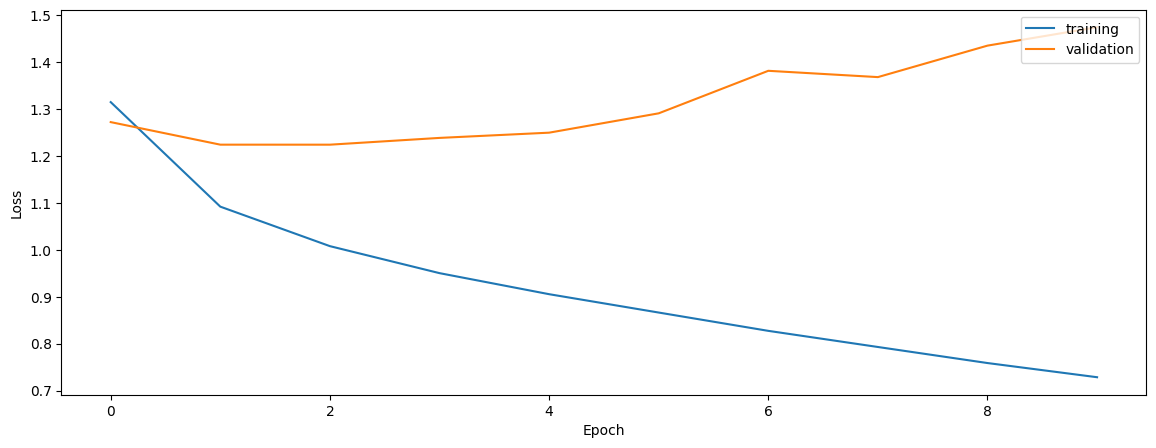

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train


0.61386664338241
0.5404461690759331
0.5842167923351664


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5542937403975353
0.5171512927501677
0.5360939510939511


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5560932823815128
0.5281891140742592
0.5393807998439621


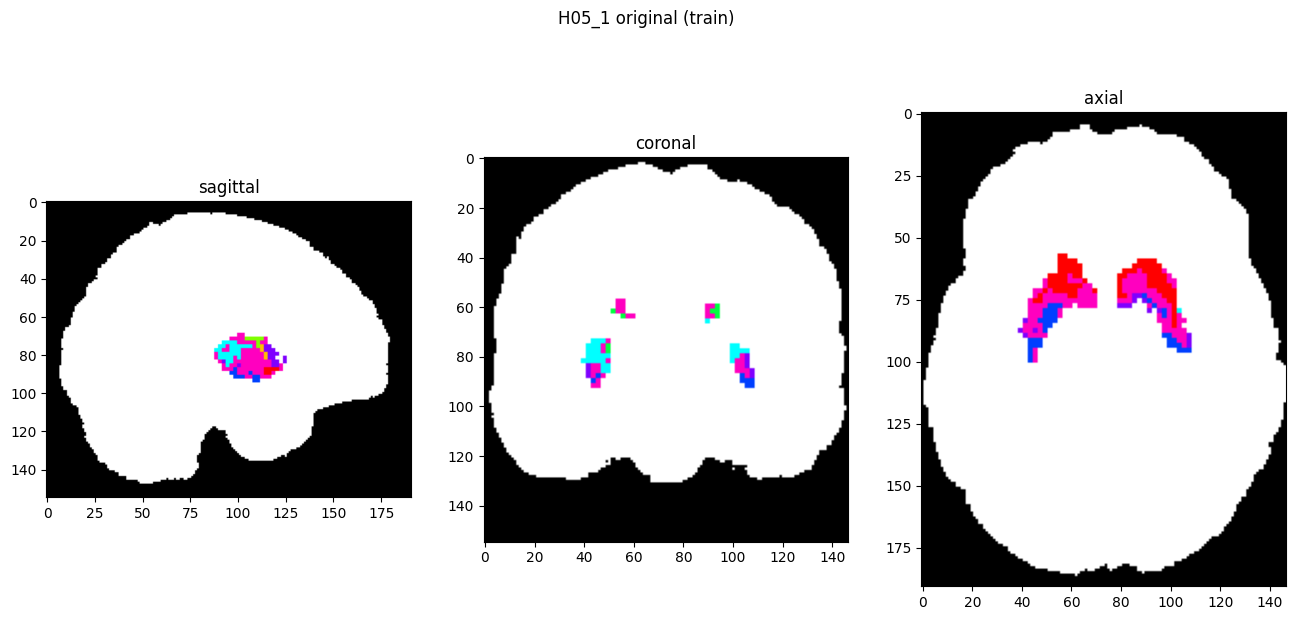

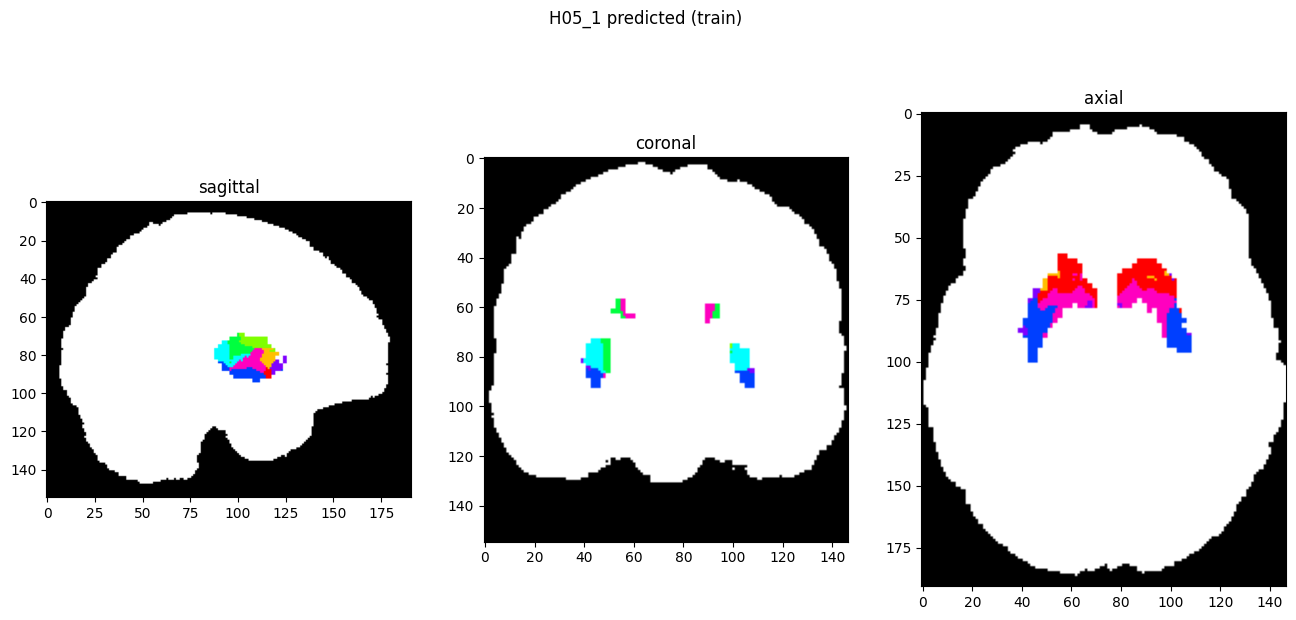

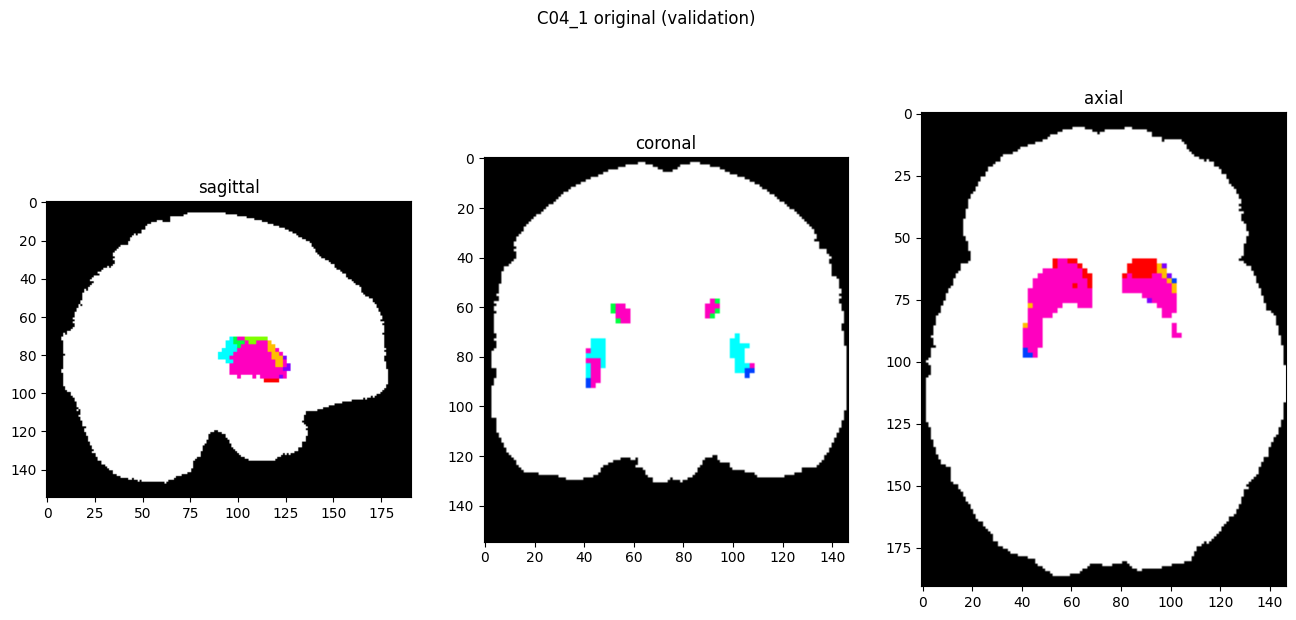

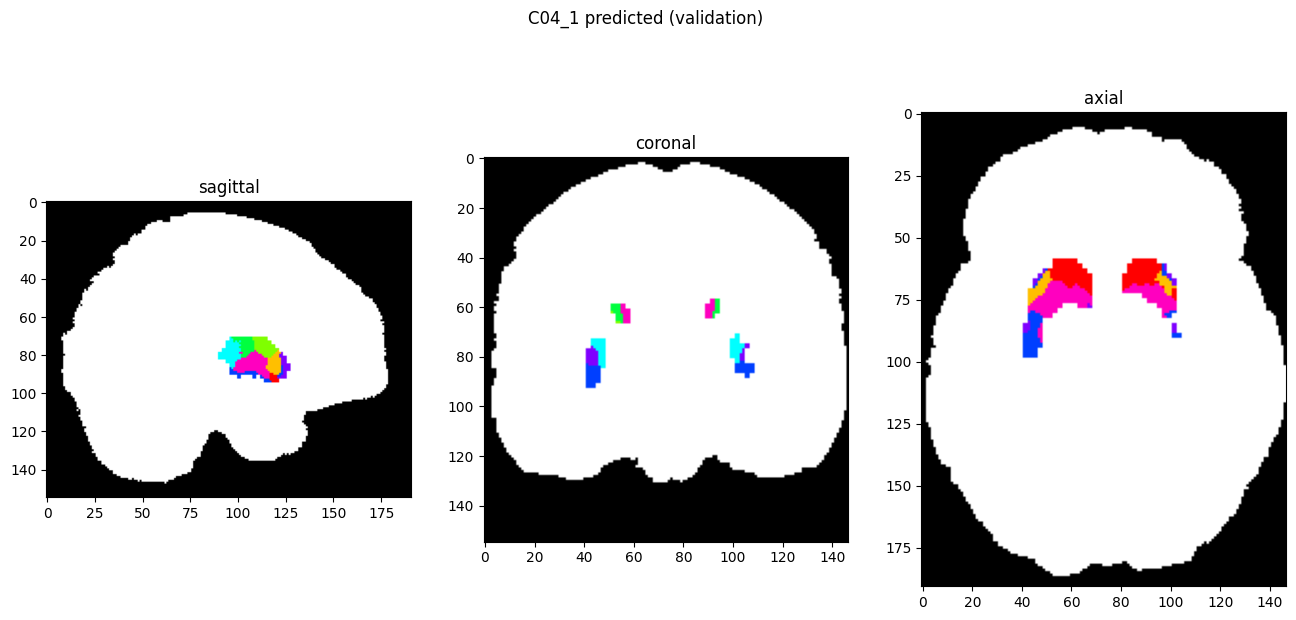

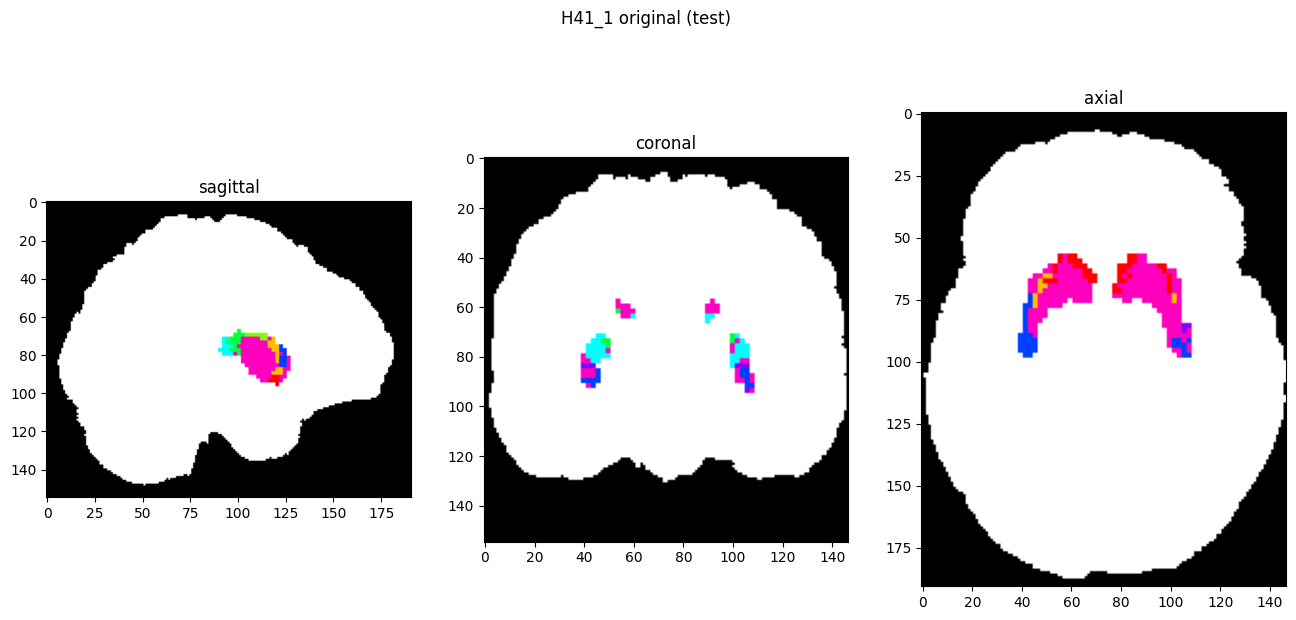

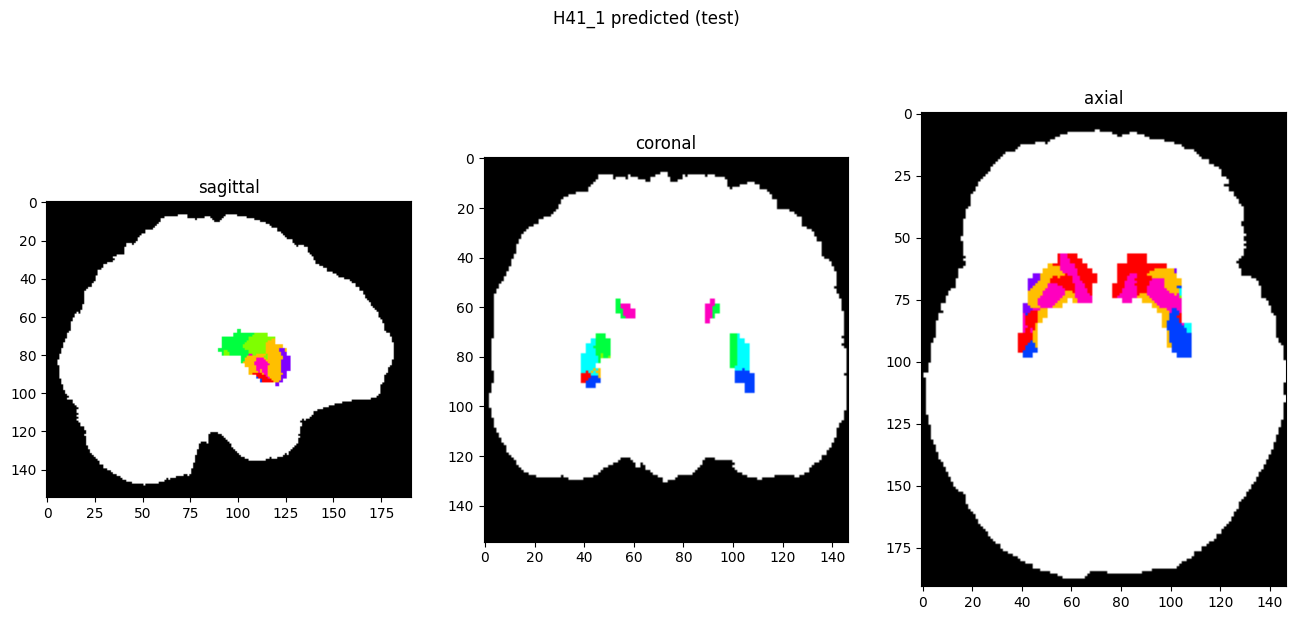

In [10]:
showResults(model, gen, threshold=0)